# Question 3 Optimising Portfolio 

In [23]:
import numpy as np
import math
import pandas as pd
import datetime
from datetime import datetime, date
from copy import deepcopy
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
from scipy.stats import norm
import cvxpy as cvx
import seaborn as sns
%matplotlib inline
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns
from pypfopt import EfficientFrontier

## Obtain Portfolio of Stocks

In [24]:
# get adjusted close price

def get_adjre_for_multiple_stocks_csv(tickers, start_date='2015-01-01',end_date= '2020-01-01'):
    #define helper function to loop through all the stocks,
    #join them based on date and return only their adj close price
    s = DataReader(tickers[0], 'yahoo', start_date, end_date)[["Adj Close"]]
    #get log returns
    s[tickers[0]] = s['Adj Close']

    stocks = s[[tickers[0]]]

    for ticker in tickers[1:]:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        s[ticker] = s['Adj Close']
        stocks[ticker] = s[ticker]
        
    return stocks.iloc[1:].fillna(0)

In [25]:
#get log returns

def get_logre(tickers, start_date='2015-01-01',end_date= '2020-01-01'):
    result = {}
    for ticker in tickers:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        for c in s['Adj Close']:
            if c is None:
                c = np.nan
            else:
                continue
        s['log returns'] = np.log(s['Adj Close']/s['Adj Close'].shift(1))
        result[ticker] = s['log returns']
    return result

In [26]:
tickers = ["GOOGL", "GOOG", "FB", "AMZN", "EBAY", "CSCO", "JNPR", "QCOM", "ACN", "AKAM", "GPN", "IBM", "V", "INTC", "KLAC", "NXPI", "SWKS", "XLNX", "CHKP", "CTXS", "MSFT", "ORCL", "SNPS", "VMW", "AAPL", "IAC", "HPQ", "NTAP", "STX", "WDC"]
portfolio_adjre = get_adjre_for_multiple_stocks_csv(tickers)
portfolio_adjre = pd.DataFrame(portfolio_adjre)
portfolio_adjre.head()

,GOOGL,GOOG,FB,AMZN,EBAY,CSCO,JNPR,QCOM,ACN,AKAM,...,MSFT,ORCL,SNPS,VMW,AAPL,IAC,HPQ,NTAP,STX,WDC
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,529.549988,523.373108,78.449997,308.519989,23.046915,22.964809,19.757004,60.774788,78.904068,63.250000,...,41.647892,40.292976,43.099998,68.177483,24.941502,19.352539,14.836161,35.532898,47.154106,91.047844
2015-01-05,519.460022,512.463013,77.190002,302.190002,22.854210,22.507343,19.536995,60.488415,77.571823,61.939999,...,41.264908,39.727905,42.540001,67.313530,24.238857,19.240211,14.589142,34.324467,46.904118,89.844086
2015-01-06,506.640015,500.585632,76.150002,295.290009,22.558998,22.499020,19.264179,59.629311,77.012268,60.669998,...,40.659245,39.317783,42.160000,65.452713,24.241146,19.310818,14.478534,34.015938,45.611343,87.840591
2015-01-07,505.149994,499.727997,76.150002,298.420013,22.522099,22.706963,19.695400,60.324776,78.628738,60.160000,...,41.175831,39.326889,42.209999,65.502556,24.581060,19.275517,14.648128,34.192368,45.904182,89.159760
2015-01-08,506.910004,501.303680,78.180000,300.459991,23.128920,22.881630,20.267429,60.962967,79.827751,61.570000,...,42.387146,39.563850,42.860001,66.275124,25.525522,19.747293,14.998387,34.898075,46.732704,91.006638


In [137]:
portfolio_logre = get_logre(tickers)
portfolio_logre = (pd.DataFrame(portfolio_logre)).iloc[1:]
portfolio_logre.head()

,GOOGL,GOOG,FB,AMZN,EBAY,CSCO,JNPR,QCOM,ACN,AKAM,...,MSFT,ORCL,SNPS,VMW,AAPL,IAC,HPQ,NTAP,STX,WDC
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-0.002094,-0.003025,0.005496,-0.005914,0.001603,-0.000724,0.005808,-0.000673,-0.005276,0.004596,...,0.006652,-0.014334,-0.008548,-0.005468,-0.009558,-0.008093,0.002738,0.000241,-0.007244,-0.002442
2015-01-05,-0.019238,-0.021066,-0.016191,-0.020731,-0.008397,-0.020121,-0.011198,-0.004723,-0.017029,-0.020929,...,-0.009238,-0.014123,-0.013078,-0.012753,-0.028576,-0.005821,-0.016790,-0.034601,-0.005316,-0.013309
2015-01-06,-0.024989,-0.023450,-0.013565,-0.023098,-0.013001,-0.000370,-0.014062,-0.014305,-0.007240,-0.020717,...,-0.014786,-0.010377,-0.008973,-0.028033,0.000094,0.003663,-0.007611,-0.009029,-0.027949,-0.022552
2015-01-07,-0.002945,-0.001715,0.000000,0.010544,-0.001637,0.009200,0.022138,0.011596,0.020773,-0.008442,...,0.012625,0.000232,0.001185,0.000761,0.013925,-0.001830,0.011646,0.005173,0.006400,0.014906
2015-01-08,0.003478,0.003148,0.026309,0.006813,0.026587,0.007663,0.028630,0.010524,0.015134,0.023167,...,0.028994,0.006007,0.015282,0.011725,0.037703,0.024181,0.023630,0.020429,0.017888,0.020503


In [28]:
benchmark_logre = get_logre(['ROGSX'])
benchmark_logre = pd.DataFrame(benchmark_logre)
benchmark_logre.head()

,ROGSX
Date,
2014-12-31,NaN
2015-01-02,-0.001783
2015-01-05,-0.015588
2015-01-06,-0.010325
2015-01-07,0.009721


# Basic Asset EDA (Correlation, Returns, Volatility, Annualised Sharpe Ratio) 

Text(0.5, 1.0, 'Asset Correlations')

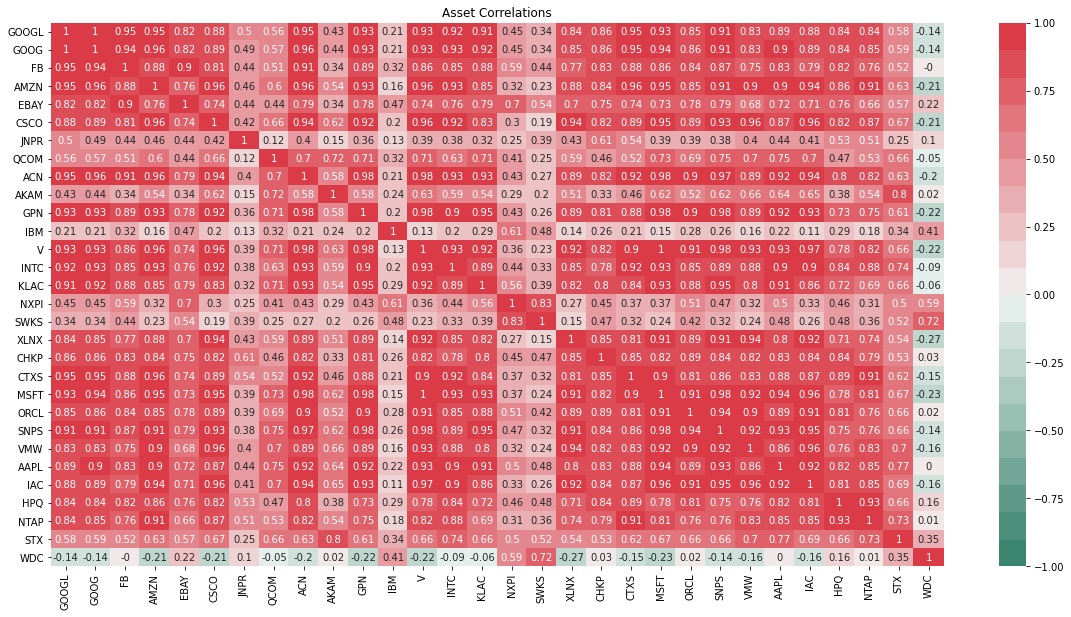

In [29]:
plt.figure(figsize=(20, 10))
sns.heatmap(round(portfolio_adjre.corr(), 2), cmap=sns.diverging_palette(160, 10, n = 20), annot=True, vmin=-1, vmax=1)
plt.title("Asset Correlations")

##### From here, we can see that WDC is negatively correlated with most of the other assets.

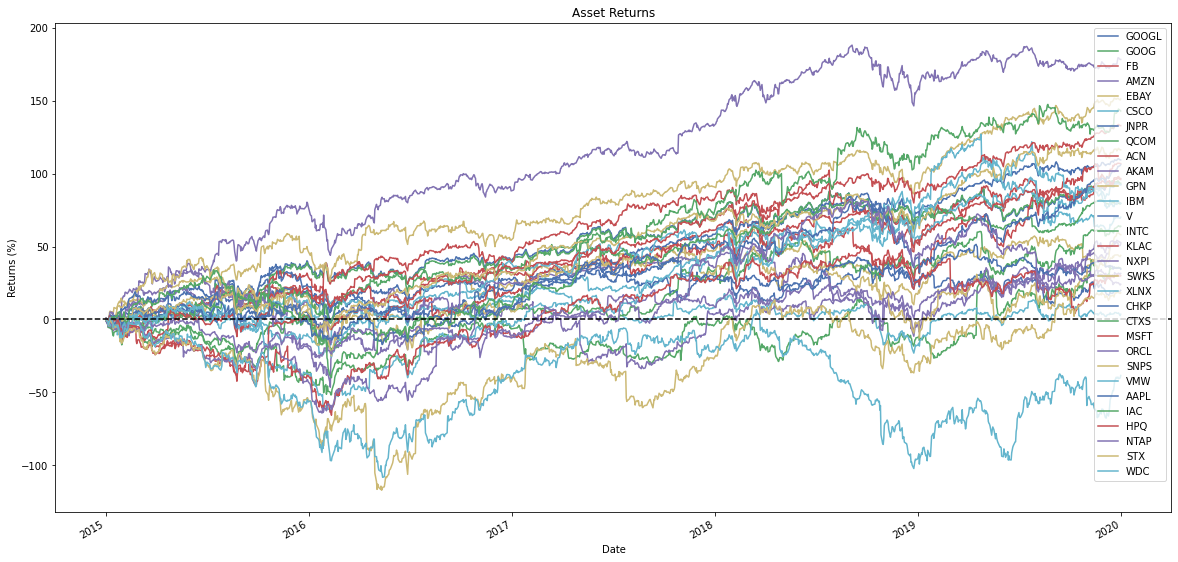

In [30]:
portfolio_logre[1:].expanding().apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (20, 10))
#portfolio_logre.plot(figsize = (20, 10))
plt.title("Asset Returns")
plt.ylabel("Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

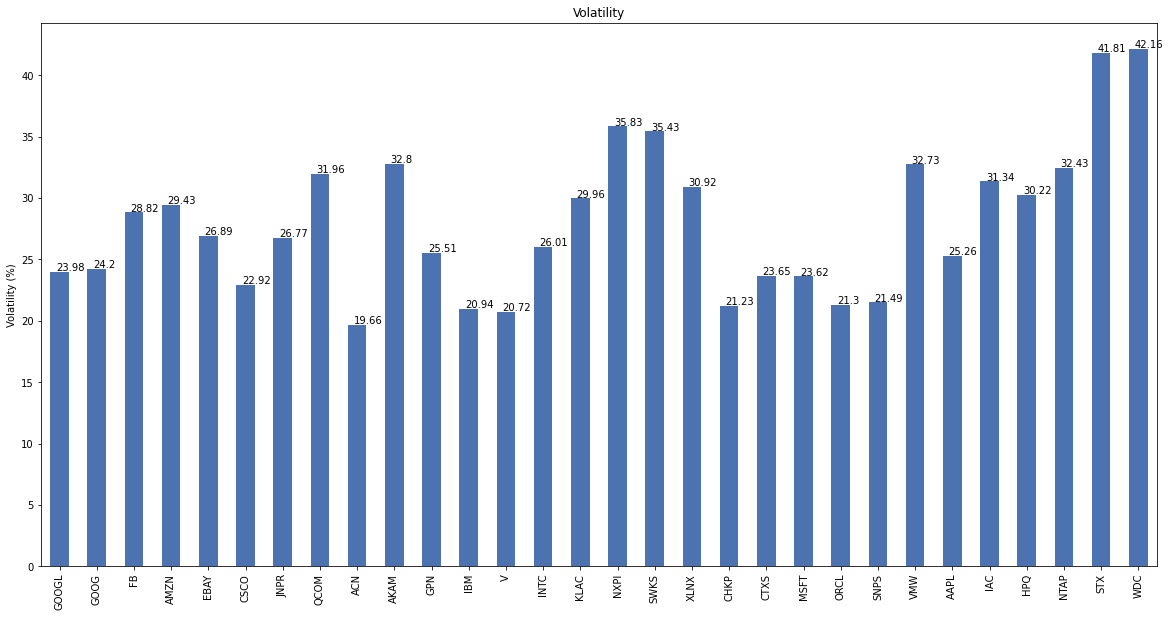

In [31]:
ax = round(portfolio_logre.std() * 260 ** 0.5 * 100, 2).plot(figsize = (20, 10), kind = "bar")
plt.title("Volatility")
plt.ylabel("Volatility (%)")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.1))

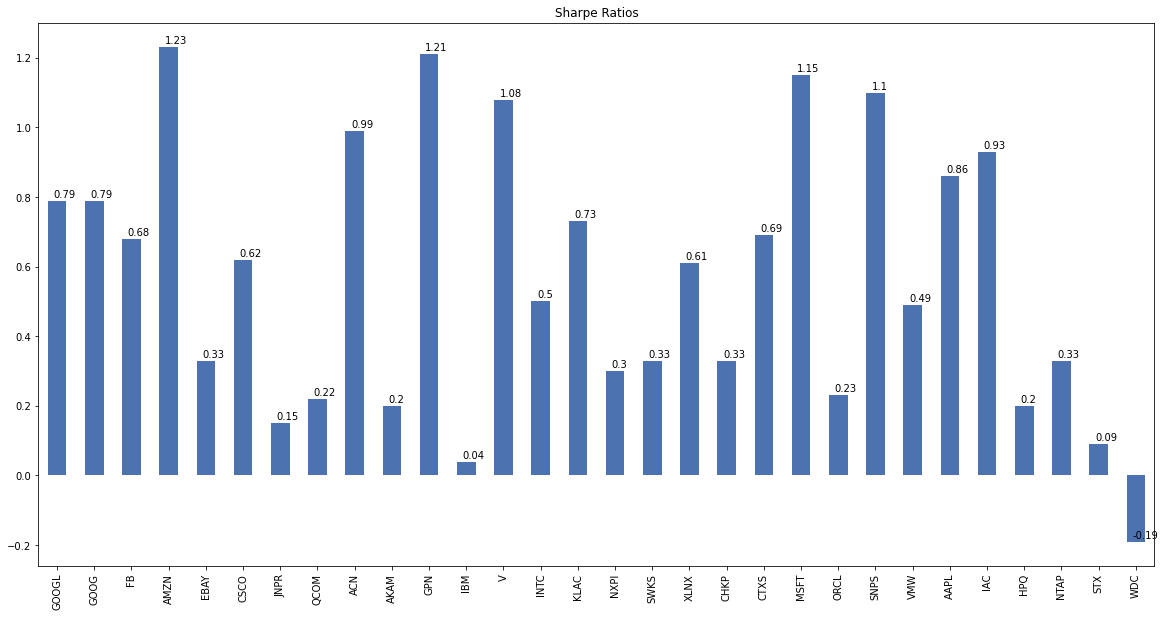

In [32]:
# Annualized sharpe ratio. Have to multiple by square root of 252 to annualize
ax = round(portfolio_logre.mean(axis = 0) / portfolio_logre.std(axis = 0) * 252 ** 0.5, 
           2).plot(kind="bar", figsize = (20, 10))

plt.title("Sharpe Ratios")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

# Basic Sector EDA (Correlation, Returns, Volatility, Annualised Sharpe Ratio)

In [33]:
#CSCO, JNPR, QCOM, ACN, AKAM, IBM, KLAC,XLNX,CHKP,MSFT,ORCL,SNPS,VMW,APPL,HPQ,NTAP,STX,WDC, CTXS (these stocks are those whose sector was stated as technology on Yahoo Finance, hence their industry was taken instead)
sector_mapper = {"GOOGL": "Communication Services", "GOOG":"Communication Services", "FB":"Communication Services", "AMZN" : "Consumer Cyclical", "EBAY":"Consumer Cyclical", "CSCO":"Communication Equipment", "JNPR": "Communication Equipment", "QCOM":"Semiconductors", "ACN":"Information Technology Services", "AKAM" : "Software—Infrastructure", 
                 "GPN" : "Consumer Defensive","IBM":" Information Technology Services", "V":"Financial Services", "INTC":"Semiconductors", "KLAC":"Semiconductor Equipment & Materials", "NXPI":"Semiconductors","SWKS":"Semiconductors","XLNX":"Semiconductors", "CHKP":"Software—Infrastructure","CTXS":" Software—Application", "MSFT":"Software—Infrastructure",
                "ORCL":"Software—Infrastructure","SNPS":"Software—Infrastructure","VMW":"Software—Infrastructure","AAPL":"Consumer Electronics","IAC":"Communication Services","HPQ":"Computer Hardware", "NTAP":"Computer Hardware","STX":"Computer Hardware","WDC":"Computer Hardware"}

In [34]:
sectors = set(sector_mapper.values())
sectors

{' Information Technology Services',
 ' Software—Application',
 'Communication Equipment',
 'Communication Services',
 'Computer Hardware',
 'Consumer Cyclical',
 'Consumer Defensive',
 'Consumer Electronics',
 'Financial Services',
 'Information Technology Services',
 'Semiconductor Equipment & Materials',
 'Semiconductors',
 'Software—Infrastructure'}

In [35]:
import collections
sector_count = collections.Counter(sector_mapper.values())
print(sector_count)

Counter({'Software—Infrastructure': 6, 'Semiconductors': 5, 'Communication Services': 4, 'Computer Hardware': 4, 'Consumer Cyclical': 2, 'Communication Equipment': 2, 'Information Technology Services': 1, 'Consumer Defensive': 1, ' Information Technology Services': 1, 'Financial Services': 1, 'Semiconductor Equipment & Materials': 1, ' Software—Application': 1, 'Consumer Electronics': 1})


In [36]:
sector_logre = deepcopy(portfolio_logre)

#rename columns to their sectors
sector_logre.columns = sector_mapper.values()

#each sector, mean log return
sector_logre = sector_logre.groupby(level = 0, axis = 1).mean()

sector_logre.head()

,Information Technology Services,Software—Application,Communication Equipment,Communication Services,Computer Hardware,Consumer Cyclical,Consumer Defensive,Consumer Electronics,Financial Services,Information Technology Services,Semiconductor Equipment & Materials,Semiconductors,Software—Infrastructure
Date,,,,,,,,,,,,,
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,0.010047,-0.005028,0.002542,-0.001929,-0.001677,-0.002156,-0.000991,-0.009558,0.010698,-0.005276,-0.000427,0.004419,-0.003084
2015-01-05,-0.015860,-0.022462,-0.015660,-0.015579,-0.017504,-0.014564,-0.017133,-0.028576,-0.022321,-0.017029,-0.022589,-0.012309,-0.012646
2015-01-06,-0.021802,-0.028433,-0.007216,-0.014585,-0.016785,-0.018050,-0.011545,0.000094,-0.006465,-0.007240,-0.029985,-0.025784,-0.013943
2015-01-07,-0.006557,0.014808,0.015669,-0.001622,0.009531,0.004453,0.011671,0.013925,0.013309,0.020773,0.016507,0.015149,0.002423


Text(0.5, 1.0, 'Sector Correlations')

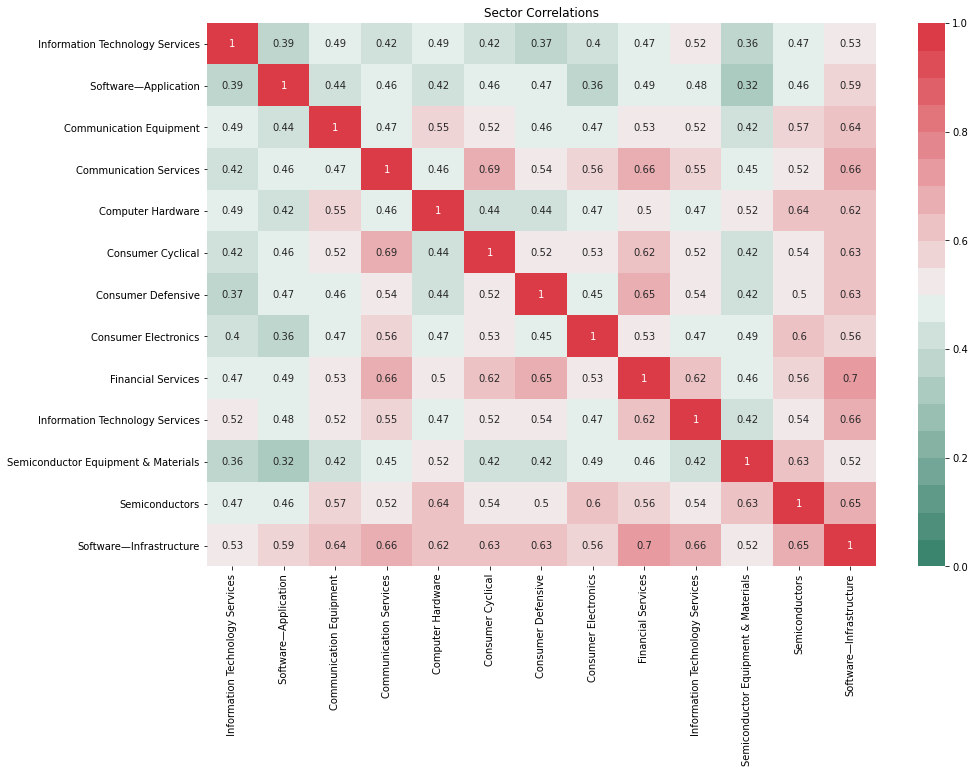

In [37]:
plt.figure(figsize=(15, 10))
sns.heatmap(round(sector_logre.corr(), 2), cmap=sns.diverging_palette(160, 10, n = 20), annot=True, vmin=0, vmax=1)
plt.title("Sector Correlations")

##### There were no negative correlations, so we changed the range to between 0 and 1 to show weak versus strong positive correlation. 

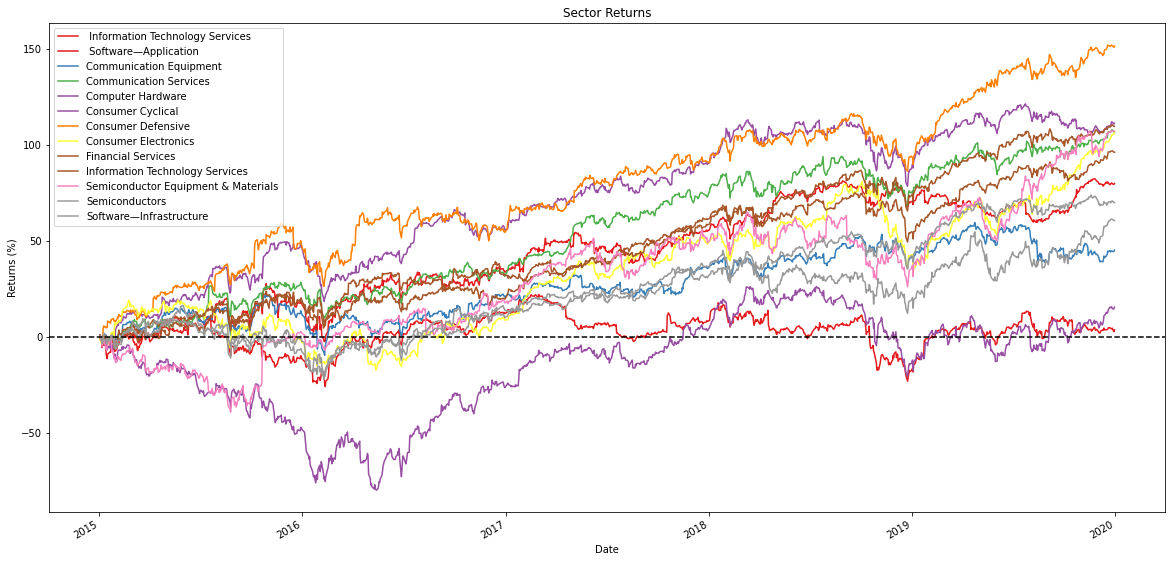

In [38]:
from matplotlib import cm
cmap = cm.get_cmap('Set1')
sector_logre[1:].expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (20, 10), cmap=cmap )
plt.title("Sector Returns")
plt.ylabel("Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

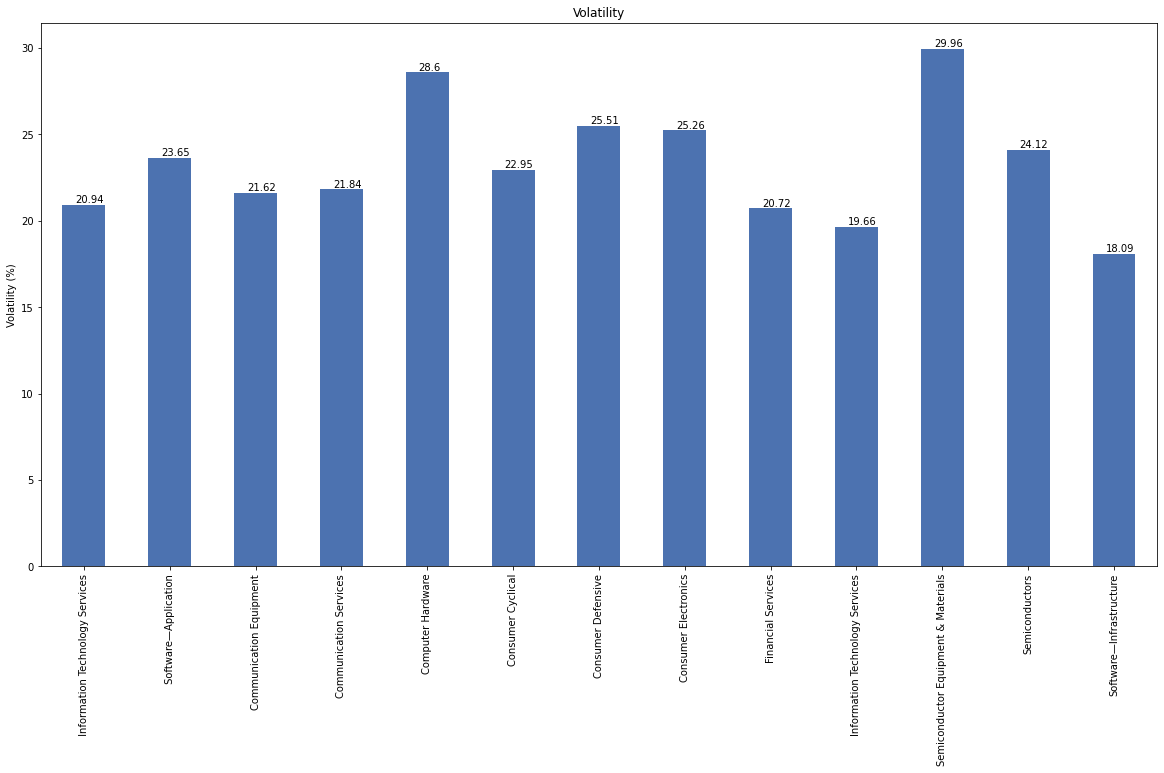

In [39]:
ax = round(sector_logre.std() * 260 ** 0.5 * 100, 2).plot(figsize = (20, 10), kind = "bar")
plt.title("Volatility")
plt.ylabel("Volatility (%)")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.1))

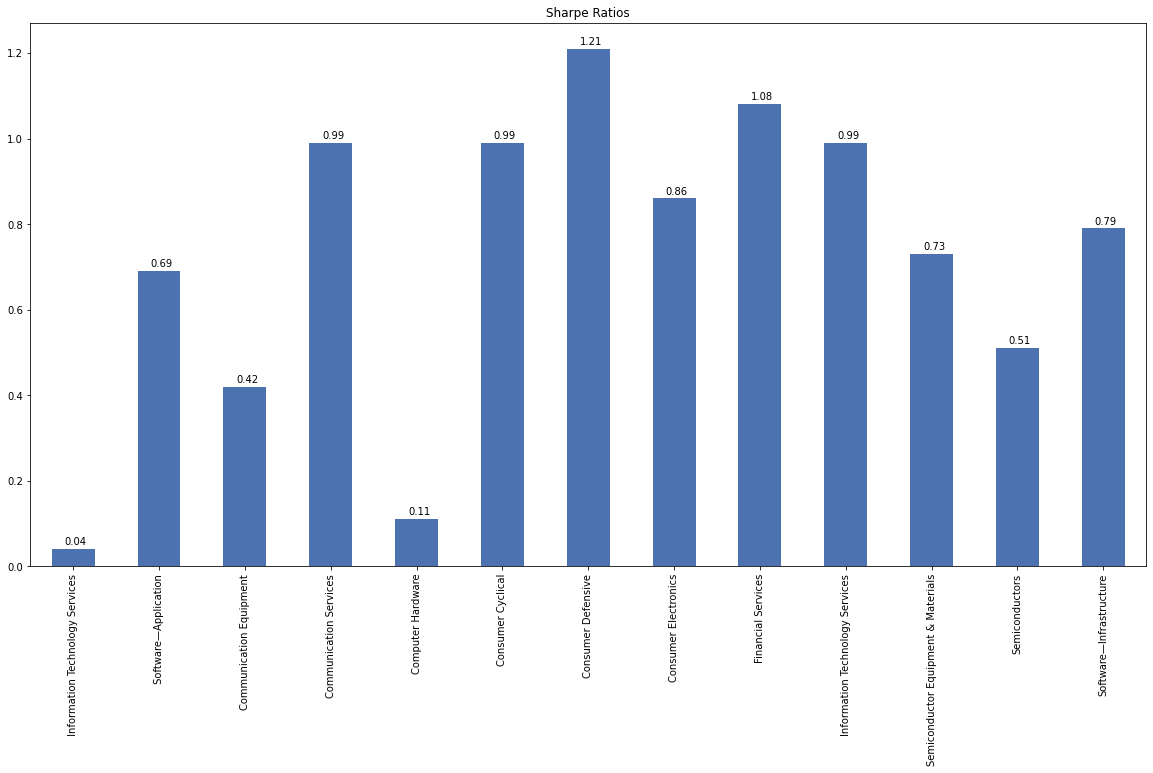

In [40]:
# Annualized sharpe ratio. Have to multiple by square root of 252 to annualize
ax = round(sector_logre.mean(axis = 0) / sector_logre.std(axis = 0) * 252 ** 0.5, 
           2).plot(kind="bar", figsize = (20, 10))

plt.title("Sharpe Ratios")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

In [41]:
sector_lower = {"Software—Infrastructure":0.2, "Semiconductors": 0.1} 
sector_upper = {"Consumer Cyclical":0.07} 
# can allocate based on number of stocks too, or future expectations of performance of sector

# Optimisation
##### Constraints that apply to all:
1. long only, x > 0
2. sum of weights = 1

In [42]:
in_sample = "2017-12-31" #3 years of data: 2015, 2016, 2017
is_adjre_df = portfolio_adjre.loc[:in_sample]
oos_adjre_df = portfolio_adjre.loc[in_sample:].iloc[1:]

is_logre_df = portfolio_logre.loc[:in_sample]
oos_logre_df = portfolio_logre.loc[in_sample:].iloc[1:] # one day after in_sample date

In [43]:
# calculate expected returns 
er_exp = expected_returns.ema_historical_return(is_logre_df, returns_data=True)
#Calculate the exponentially-weighted mean of (daily) historical returns, giving higher weight to more recent data.

#Calculate sample covariance
s = risk_models.sample_cov(is_logre_df, returns_data=True)

In [44]:
#portfolio 1: max sharpe ratio

p1 = EfficientFrontier(er_exp, s)
p1.max_sharpe()
#max sharpe ratio
w1 = p1.clean_weights()
max_sharpe = (portfolio_logre*w1).sum(axis = 1)

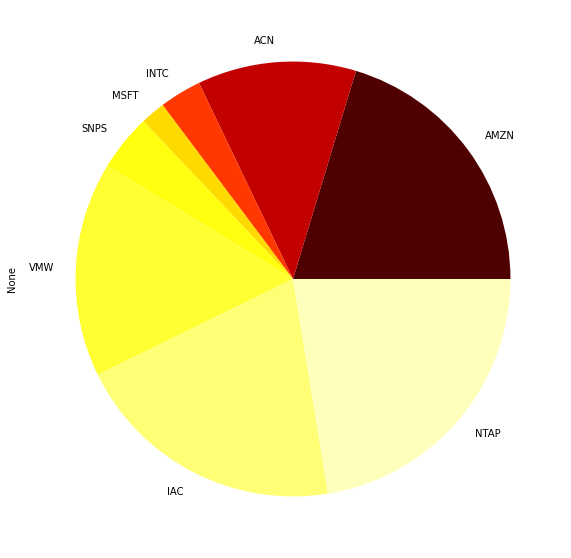

In [45]:
cmap = cm.get_cmap("hot")
pd.Series(w1).plot.pie(figsize=(10,10), cmap=cmap);

In [46]:
w1

OrderedDict([('GOOGL', 0.0),
             ('GOOG', 0.0),
             ('FB', 0.0),
             ('AMZN', 0.20325),
             ('EBAY', 0.0),
             ('CSCO', 0.0),
             ('JNPR', 0.0),
             ('QCOM', 0.0),
             ('ACN', 0.11792),
             ('AKAM', 0.0),
             ('GPN', 0.0),
             ('IBM', 0.0),
             ('V', 0.0),
             ('INTC', 0.03122),
             ('KLAC', 0.0),
             ('NXPI', 0.0),
             ('SWKS', 0.0),
             ('XLNX', 0.0),
             ('CHKP', 0.0),
             ('CTXS', 0.0),
             ('MSFT', 0.01839),
             ('ORCL', 0.0),
             ('SNPS', 0.04218),
             ('VMW', 0.15968),
             ('AAPL', 0.0),
             ('IAC', 0.20307),
             ('HPQ', 0.0),
             ('NTAP', 0.22429),
             ('STX', 0.0),
             ('WDC', 0.0)])

In [47]:
# portfolio 2: given max volatility of 15%, maximise returns
# but we shldn't focus on this because we are aggressive, so we shldn.t set volatility as constraint (technically we aren't afraid of volatility)

p2 = EfficientFrontier(er_exp,s)
p2.efficient_risk(target_volatility = 0.15)
#max returns, given 15% max volatility of portfolio
w2 = p2.clean_weights()
portfolio2 = (portfolio_logre*w2).sum(axis = 1)

In [48]:
w2

OrderedDict([('GOOGL', 0.0),
             ('GOOG', 0.01706),
             ('FB', 0.0),
             ('AMZN', 0.09349),
             ('EBAY', 0.0),
             ('CSCO', 0.04735),
             ('JNPR', 0.0),
             ('QCOM', 0.0),
             ('ACN', 0.18549),
             ('AKAM', 0.0),
             ('GPN', 0.0),
             ('IBM', 0.0),
             ('V', 0.07295),
             ('INTC', 0.05406),
             ('KLAC', 0.03543),
             ('NXPI', 0.0),
             ('SWKS', 0.0),
             ('XLNX', 0.0),
             ('CHKP', 0.0),
             ('CTXS', 0.0),
             ('MSFT', 0.0),
             ('ORCL', 0.0),
             ('SNPS', 0.15291),
             ('VMW', 0.10561),
             ('AAPL', 0.04816),
             ('IAC', 0.09453),
             ('HPQ', 0.0),
             ('NTAP', 0.09296),
             ('STX', 0.0),
             ('WDC', 0.0)])

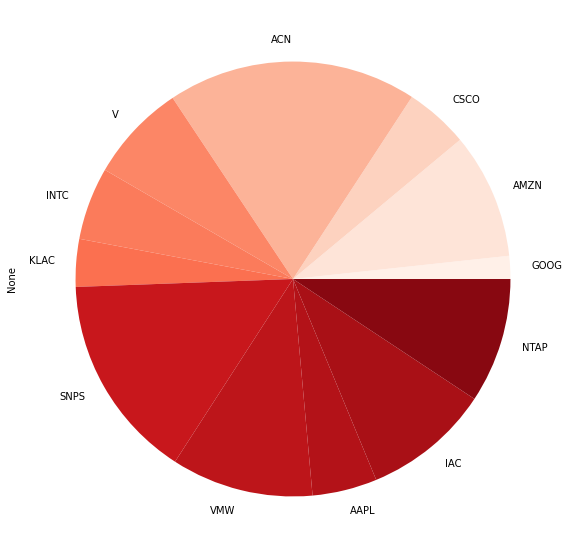

In [49]:
cmap = cm.get_cmap("Reds")
pd.Series(w2).plot.pie(figsize=(10,10), cmap=cmap);

In [50]:
#portfolio 3: given min return of 40%, min volatility

p3 = EfficientFrontier(er_exp, s)
p3.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
googl_index = p3.tickers.index("GOOGL")
p3.add_constraint(lambda w: w[googl_index] >= 0.025)
goog_index = p3.tickers.index("GOOG")
p3.add_constraint(lambda w: w[goog_index] >= 0.025)
fb = p3.tickers.index("FB")
p3.add_constraint(lambda w: w[fb] >= 0.025)
amzn = p3.tickers.index("AMZN")
p3.add_constraint(lambda w: w[amzn] >= 0.025)
msft = p3.tickers.index("MSFT")
p3.add_constraint(lambda w: w[msft] >= 0.025)
appl = p3.tickers.index("AAPL")
p3.add_constraint(lambda w: w[appl] >= 0.025)

p3.efficient_return(target_return = 0.40)
w3 = p3.clean_weights()
portfolio3 = (portfolio_logre*w3).sum(axis = 1)

In [51]:
w3

OrderedDict([('GOOGL', 0.025),
             ('GOOG', 0.025),
             ('FB', 0.025),
             ('AMZN', 0.07),
             ('EBAY', 0.0),
             ('CSCO', 0.0),
             ('JNPR', 0.0),
             ('QCOM', 0.0),
             ('ACN', 0.11837),
             ('AKAM', 0.0),
             ('GPN', 0.0),
             ('IBM', 0.0),
             ('V', 0.0),
             ('INTC', 0.1),
             ('KLAC', 0.0),
             ('NXPI', 0.0),
             ('SWKS', 0.0),
             ('XLNX', 0.0),
             ('CHKP', 0.0),
             ('CTXS', 0.0),
             ('MSFT', 0.025),
             ('ORCL', 0.0),
             ('SNPS', 0.05592),
             ('VMW', 0.14893),
             ('AAPL', 0.025),
             ('IAC', 0.18978),
             ('HPQ', 0.0),
             ('NTAP', 0.19199),
             ('STX', 0.0),
             ('WDC', 0.0)])

/Users/clara/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


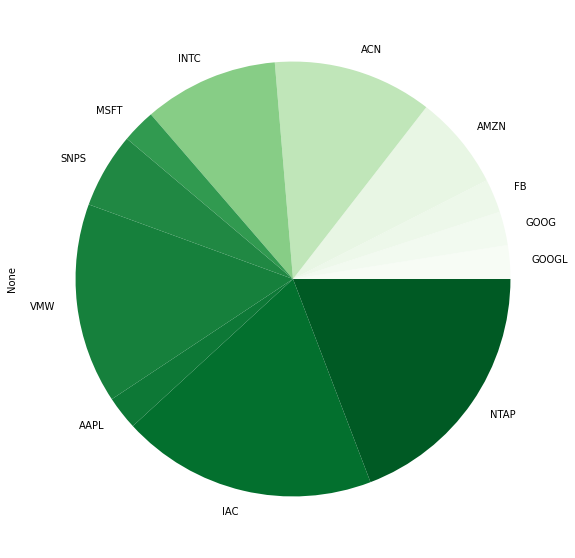

In [52]:
cmap = cm.get_cmap("Greens")
pd.Series(w3).plot.pie(figsize=(10,10), cmap=cmap);

In [53]:
from pypfopt import objective_functions
p3b = EfficientFrontier(er_exp, s)
p3b.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
googl_index = p3b.tickers.index("GOOGL")
p3b.add_constraint(lambda w: w[googl_index] >= 0.025)
goog_index = p3b.tickers.index("GOOG")
p3b.add_constraint(lambda w: w[goog_index] >= 0.025)
fb = p3b.tickers.index("FB")
p3b.add_constraint(lambda w: w[fb] >= 0.025)
amzn = p3b.tickers.index("AMZN")
p3b.add_constraint(lambda w: w[amzn] >= 0.025)
msft = p3b.tickers.index("MSFT")
p3b.add_constraint(lambda w: w[msft] >= 0.025)
appl = p3b.tickers.index("AAPL")
p3b.add_constraint(lambda w: w[appl] >= 0.025)

p3b.add_objective(objective_functions.L2_reg, gamma=2) 
p3b.efficient_return(target_return = 0.40)
w3b = p3b.clean_weights()
portfolio3b = (portfolio_logre*w3b).sum(axis = 1)

In [54]:
w3b

OrderedDict([('GOOGL', 0.025),
             ('GOOG', 0.025),
             ('FB', 0.0336),
             ('AMZN', 0.07),
             ('EBAY', 0.0),
             ('CSCO', 0.00181),
             ('JNPR', 0.0),
             ('QCOM', 0.0),
             ('ACN', 0.03346),
             ('AKAM', 0.0),
             ('GPN', 0.0104),
             ('IBM', 0.0),
             ('V', 0.02808),
             ('INTC', 0.1),
             ('KLAC', 0.00104),
             ('NXPI', 0.0),
             ('SWKS', 0.0),
             ('XLNX', 0.0),
             ('CHKP', 0.0),
             ('CTXS', 0.0),
             ('MSFT', 0.08871),
             ('ORCL', 0.0),
             ('SNPS', 0.02998),
             ('VMW', 0.14565),
             ('AAPL', 0.025),
             ('IAC', 0.17315),
             ('HPQ', 0.01975),
             ('NTAP', 0.18938),
             ('STX', 0.0),
             ('WDC', 0.0)])

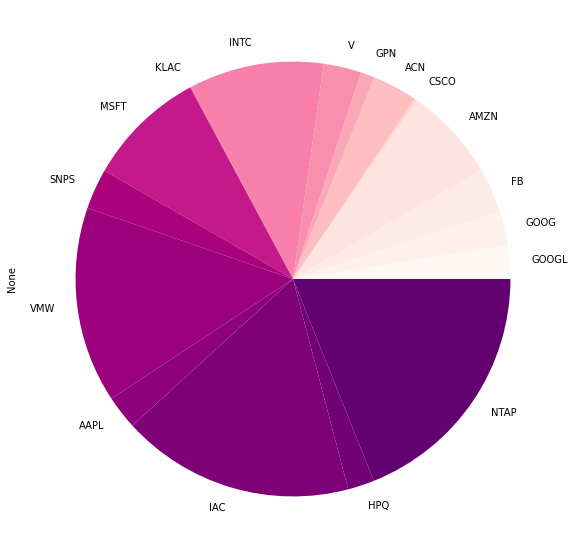

In [55]:
cmap = cm.get_cmap("RdPu")
pd.Series(w3b).plot.pie(figsize=(10,10), cmap=cmap);

In [56]:
all_portfolio_returns = pd.concat([benchmark_logre,max_sharpe, portfolio2, portfolio3, portfolio3b], axis = 1)
all_portfolio_returns.columns = ["benchmark", "max_sharpe", "portfolio2", "portfolio3", "portfolio3b"]
in_sample_results = all_portfolio_returns[:in_sample]
oos_results = all_portfolio_returns[in_sample:].iloc[1:]

# In Sample Results 
## Volatility, Sharpe Ratio, Returns

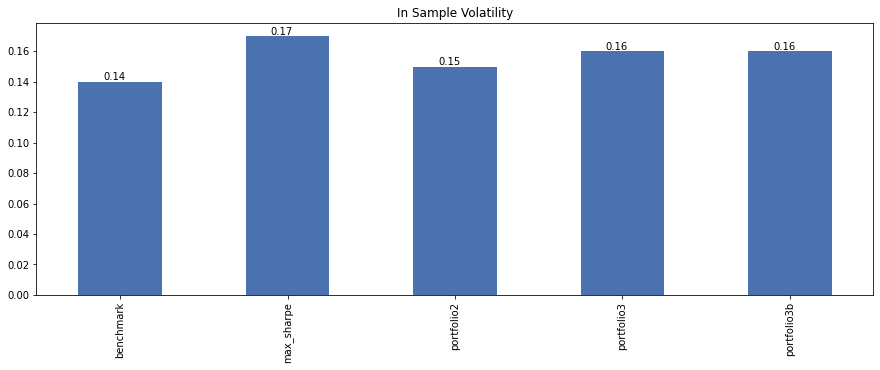

In [57]:
ax = round(in_sample_results.std(axis = 0) * 252 ** 0.5, 2).plot(kind="bar", figsize = (15, 5)) 
#avg 252 trading days a year
plt.title("In Sample Volatility")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.001))

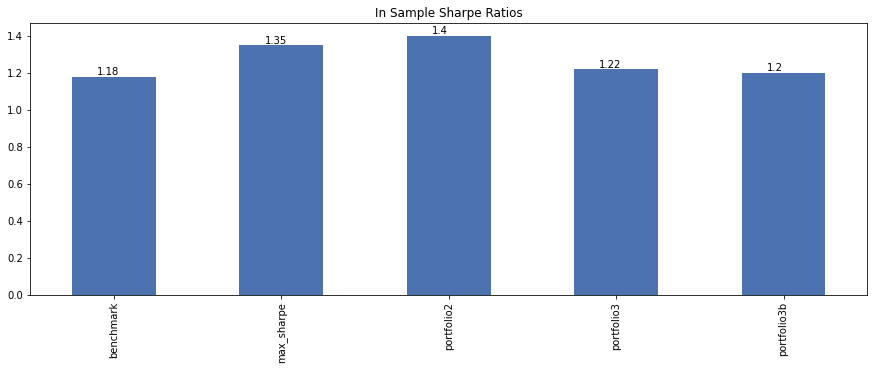

In [58]:
ax = round(in_sample_results.mean(axis = 0) / in_sample_results.std(axis = 0) * 260 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))
plt.title("In Sample Sharpe Ratios")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

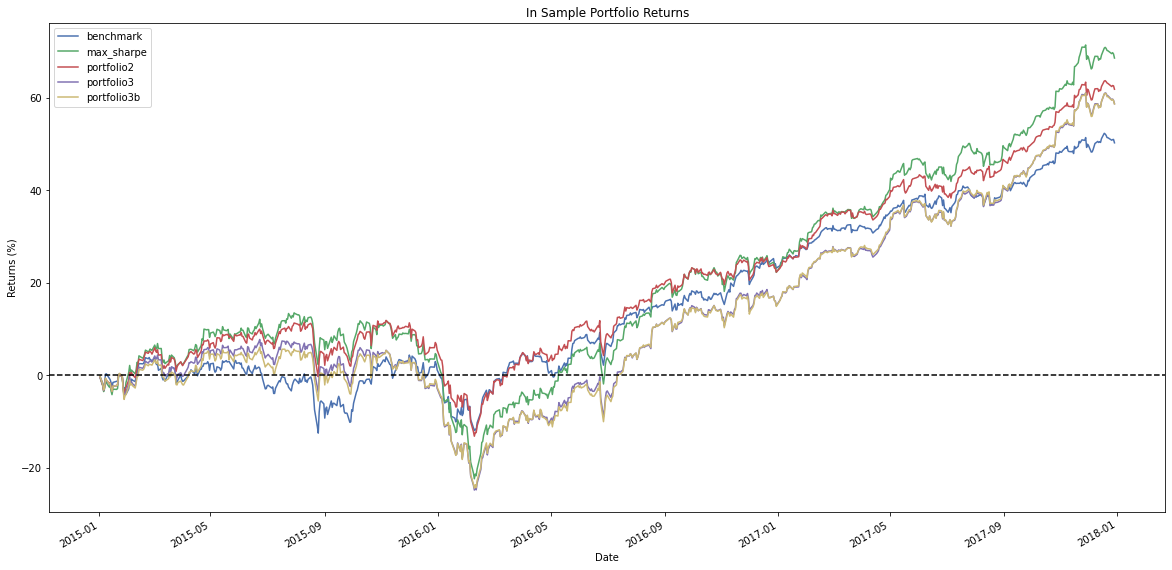

In [59]:
in_sample_results[1:].expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (20, 10))
plt.title("In Sample Portfolio Returns")
plt.ylabel("Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

# Out of Sample Results
## Volatility, Sharpe Ratio, Returns

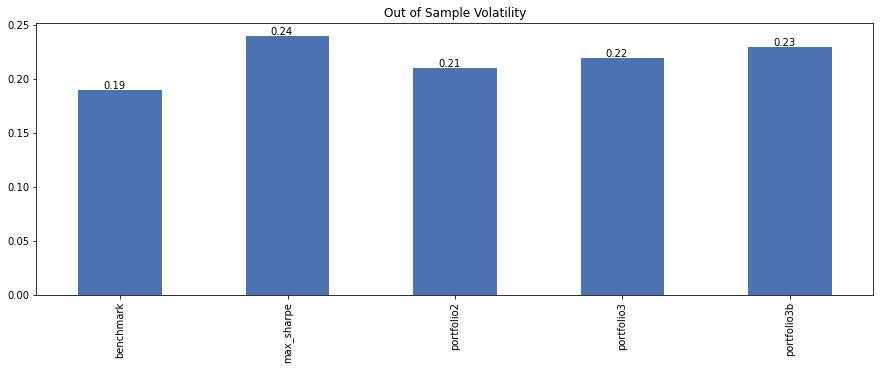

In [60]:
ax = round(oos_results.std(axis = 0) * 252 ** 0.5, 2).plot(kind="bar", figsize = (15, 5)) 
#avg 252 trading days a year
plt.title("Out of Sample Volatility")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.001))

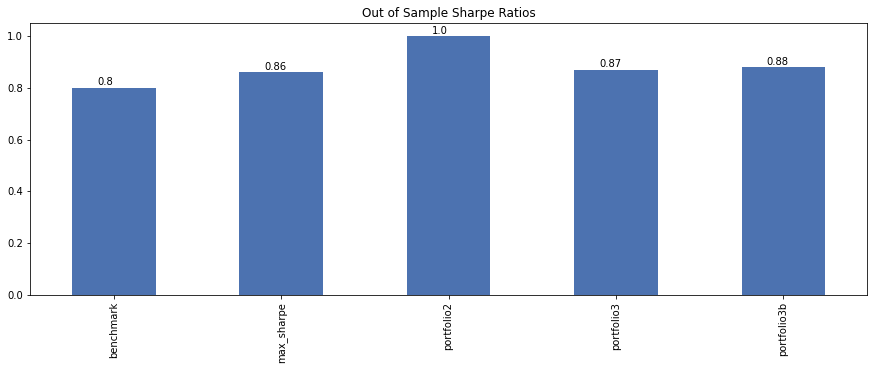

In [61]:
ax = round(oos_results.mean(axis = 0) / oos_results.std(axis = 0) * 260 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))
plt.title("Out of Sample Sharpe Ratios")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

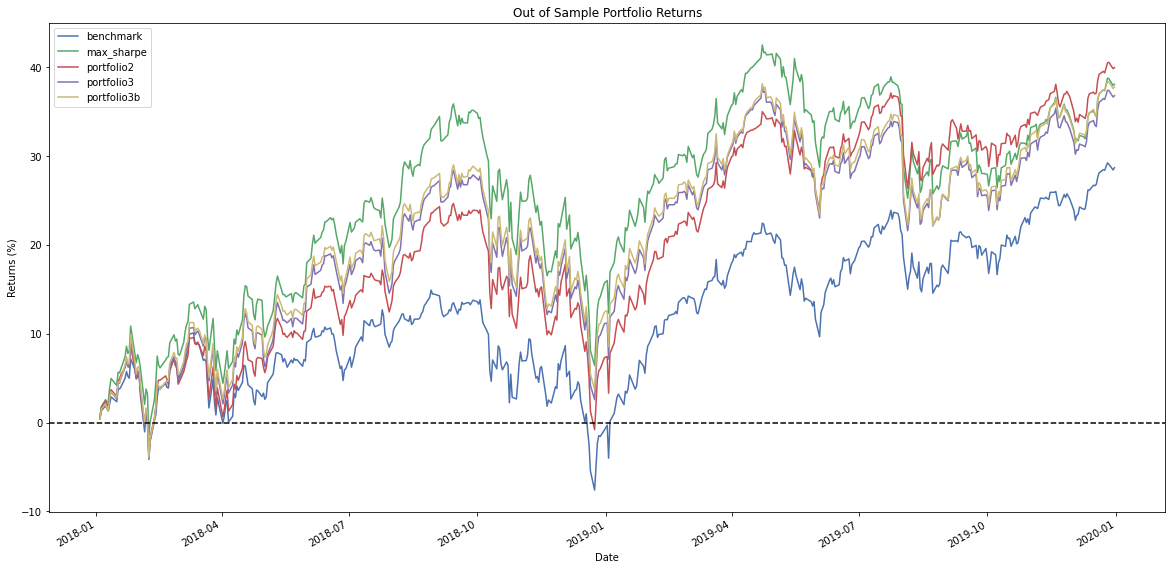

In [62]:
oos_results[1:].expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (20, 10))
plt.title("Out of Sample Portfolio Returns")
plt.ylabel("Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

In [63]:
w3b

OrderedDict([('GOOGL', 0.025),
             ('GOOG', 0.025),
             ('FB', 0.0336),
             ('AMZN', 0.07),
             ('EBAY', 0.0),
             ('CSCO', 0.00181),
             ('JNPR', 0.0),
             ('QCOM', 0.0),
             ('ACN', 0.03346),
             ('AKAM', 0.0),
             ('GPN', 0.0104),
             ('IBM', 0.0),
             ('V', 0.02808),
             ('INTC', 0.1),
             ('KLAC', 0.00104),
             ('NXPI', 0.0),
             ('SWKS', 0.0),
             ('XLNX', 0.0),
             ('CHKP', 0.0),
             ('CTXS', 0.0),
             ('MSFT', 0.08871),
             ('ORCL', 0.0),
             ('SNPS', 0.02998),
             ('VMW', 0.14565),
             ('AAPL', 0.025),
             ('IAC', 0.17315),
             ('HPQ', 0.01975),
             ('NTAP', 0.18938),
             ('STX', 0.0),
             ('WDC', 0.0)])

In [64]:
p1.portfolio_performance(verbose=True)

Expected annual return: 43.2%
Annual volatility: 17.2%
Sharpe Ratio: 2.40


(0.4320194059571783, 0.17172107586798682, 2.399352577280173)

In [65]:
p2.portfolio_performance(verbose=True)

Expected annual return: 35.8%
Annual volatility: 15.0%
Sharpe Ratio: 2.26


(0.3582885770732307, 0.15000000115410975, 2.2552571631361094)

In [66]:
p3.portfolio_performance(verbose=True)

Expected annual return: 40.0%
Annual volatility: 16.3%
Sharpe Ratio: 2.33


(0.39999999999999997, 0.16301468916822162, 2.331078272387234)

In [67]:
p3b.portfolio_performance(verbose=True)

Expected annual return: 40.0%
Annual volatility: 16.5%
Sharpe Ratio: 2.30


(0.3999999999999999, 0.16505440903528323, 2.3022711251461834)

# Question 4

In [68]:
from __future__ import division
import cvxpy as cvx
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
import datetime
from datetime import datetime, date
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as dt
from functools import reduce
import math as math
from math import sqrt, exp
import seaborn as sns
from copy import deepcopy
from scipy.stats import norm
%matplotlib inline
import collections
from collections import OrderedDict

In [69]:
#obtain portfolio of stocks
#code taken from tutorial 3 optimisation
def get_data_for_multiple_stocks(tickers, start_date, end_date):
    #read in stock data
    #date: YYYY-MM-DD
    s = DataReader(tickers[0], 'yahoo', start_date, end_date)[["Adj Close"]]
    #get log returns
    s[tickers[0]] = s['Adj Close']

    stocks = s[[tickers[0]]]

    for ticker in tickers[1:]:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        s[ticker] = s['Adj Close']
        stocks[ticker] = s[ticker]
        
    return stocks.iloc[1:].fillna(0)

### Obtain 1,3,5 year returns from US Treasury Yield 10 year as risk free rate

In [70]:
risk_free = ['^TNX']

tnx1 = get_data_for_multiple_stocks(risk_free, start_date = "2019-01-01",end_date= "2020-01-01")
tnx3 = get_data_for_multiple_stocks(risk_free, start_date = "2017-01-01", end_date = "2020-01-01")
tnx5 = get_data_for_multiple_stocks(risk_free, start_date = "2015-01-01", end_date = "2020-01-01")

tnx1
# /100 to get returns and then log
# have to deannualise to make it daily returns

,^TNX
Date,
2019-01-02,2.661
2019-01-03,2.554
2019-01-04,2.659
2019-01-07,2.682
2019-01-08,2.716
...,...
2019-12-23,1.935
2019-12-26,1.905
2019-12-27,1.874


In [71]:
tnx1['log_return'] = np.log(tnx1['^TNX']/25200 + 1)
tnx3['log_return'] = np.log(tnx3['^TNX']/25200 + 1)
tnx5['log_return'] = np.log(tnx5['^TNX']/25200 + 1)
tnx1

,^TNX,log_return
Date,,
2019-01-02,2.661,0.000106
2019-01-03,2.554,0.000101
2019-01-04,2.659,0.000106
2019-01-07,2.682,0.000106
2019-01-08,2.716,0.000108
...,...,...
2019-12-23,1.935,0.000077
2019-12-26,1.905,0.000076
2019-12-27,1.874,0.000074


### Obtain 1,3,5 year returns from top 30 holdings for best portfolio

In [72]:
#retrieved from October 21, 2019 data from https://www.oakfunds.com/assets/files/h/oak-10.31.19-annual-report.pdf
best_tickers = ["GOOGL", "GOOG", "FB", "IAC", "AMZN", "EBAY", "CSCO", "JNPR", "QCOM", "ACN", "AKAM", "GPN", "IBM", "V", "INTC", 
            "KLAC", "NXPI", "SWKS", "XLNX", "CHKP", "CTXS", "MSFT", "ORCL", "SNPS", "VMW", "AAPL", "HPQ", "NTAP", "STX", "WDC"] 

#rogsx is our best fund ticker, we will retrieve their 1, 3, 5 years of data 
rogsx1 = get_data_for_multiple_stocks(best_tickers, start_date = "2019-01-01",end_date= "2020-01-01")
rogsx3 = get_data_for_multiple_stocks(best_tickers, start_date = "2017-01-01", end_date = "2020-01-01")
rogsx5 = get_data_for_multiple_stocks(best_tickers, start_date = "2015-01-01", end_date = "2020-01-01")

In [73]:
rogsx1

,GOOGL,GOOG,FB,IAC,AMZN,EBAY,CSCO,JNPR,QCOM,ACN,...,CTXS,MSFT,ORCL,SNPS,VMW,AAPL,HPQ,NTAP,STX,WDC
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,1054.680054,1045.849976,135.679993,59.017681,1539.130005,28.105513,40.382099,25.417028,54.205219,136.644974,...,99.968712,98.860214,43.693062,84.050003,136.160004,38.629097,19.392073,56.203262,35.616638,36.312473
2019-01-03,1025.469971,1016.059998,131.740005,56.810741,1500.280029,27.589191,38.913486,24.575781,52.599842,131.979675,...,98.530945,95.223351,43.267929,81.110001,130.669998,34.781353,18.734077,53.896629,33.283512,33.835327
2019-01-04,1078.069946,1070.709961,137.949997,59.921413,1575.390015,28.222414,40.666344,25.521002,53.449738,137.111526,...,100.389267,99.652115,45.132755,83.900002,138.910004,36.266144,19.476675,55.725067,34.759945,35.268467
2019-01-07,1075.920044,1068.390015,138.050003,59.276360,1629.510010,28.709513,40.941113,26.012520,53.298649,137.587784,...,100.790291,99.779205,45.847767,85.760002,143.740005,36.185429,19.692873,55.443768,35.689545,36.521275
2019-01-08,1085.369995,1076.280029,142.529999,60.664703,1656.579956,29.225834,41.272739,26.343348,52.835922,141.067322,...,101.572746,100.502670,46.263248,86.099998,146.800003,36.875229,19.937269,55.012440,35.671322,36.170105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1344.430054,1343.560059,205.119995,80.736740,1789.209961,35.808384,46.192528,23.665251,86.927422,208.266663,...,109.769501,156.137955,52.516068,138.210007,151.020004,70.580566,20.016390,60.294880,57.015442,60.941479
2019-12-26,1362.469971,1360.400024,207.789993,81.814011,1868.770020,35.847939,46.260204,23.860109,86.565109,208.699707,...,110.354713,157.417786,52.643826,140.070007,153.460007,71.980911,20.113605,59.968758,57.427555,61.499676
2019-12-27,1354.640015,1351.890015,208.100006,82.678452,1869.800049,35.669937,46.182861,23.782164,86.956810,208.867004,...,109.888535,157.705505,52.535728,140.619995,154.160004,71.953598,19.958061,58.923237,57.101700,60.843552


### Calculation of best portfolio weightage 

In [74]:
rogsx_shares = [18300, 26276, 143225, 98885, 15400, 336300, 598000, 447000, 159000, 101275, 136200, 128157, 80900, 60000, 557800, 
                215400, 133550, 113970, 197800, 169700, 129280, 280200, 439641, 159000, 140600, 161720, 480500, 321700, 329400, 204600]
total_best = sum(rogsx_shares)

rogsx_weights = []
for s in rogsx_shares:
    w = s/total_best 
    rogsx_weights.append(w)

In [75]:
rogsx1['portfolio_value'] = rogsx1[best_tickers[0]]*rogsx_weights[0]
for i in range(1,30):
    rogsx1['portfolio_value'] += rogsx1[best_tickers[i]]*rogsx_weights[i]
    
rogsx3['portfolio_value'] = rogsx3[best_tickers[0]]*rogsx_weights[0]
for i in range(1,30):
    rogsx3['portfolio_value'] += rogsx3[best_tickers[i]]*rogsx_weights[i]
    
rogsx5['portfolio_value'] = rogsx5[best_tickers[0]]*rogsx_weights[0]
for i in range(1,30):
    rogsx5['portfolio_value'] += rogsx5[best_tickers[i]]*rogsx_weights[i]
    
rogsx1

,GOOGL,GOOG,FB,IAC,AMZN,EBAY,CSCO,JNPR,QCOM,ACN,...,MSFT,ORCL,SNPS,VMW,AAPL,HPQ,NTAP,STX,WDC,portfolio_value
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,1054.680054,1045.849976,135.679993,59.017681,1539.130005,28.105513,40.382099,25.417028,54.205219,136.644974,...,98.860214,43.693062,84.050003,136.160004,38.629097,19.392073,56.203262,35.616638,36.312473,69.153409
2019-01-03,1025.469971,1016.059998,131.740005,56.810741,1500.280029,27.589191,38.913486,24.575781,52.599842,131.979675,...,95.223351,43.267929,81.110001,130.669998,34.781353,18.734077,53.896629,33.283512,33.835327,66.652774
2019-01-04,1078.069946,1070.709961,137.949997,59.921413,1575.390015,28.222414,40.666344,25.521002,53.449738,137.111526,...,99.652115,45.132755,83.900002,138.910004,36.266144,19.476675,55.725067,34.759945,35.268467,69.626885
2019-01-07,1075.920044,1068.390015,138.050003,59.276360,1629.510010,28.709513,40.941113,26.012520,53.298649,137.587784,...,99.779205,45.847767,85.760002,143.740005,36.185429,19.692873,55.443768,35.689545,36.521275,70.386071
2019-01-08,1085.369995,1076.280029,142.529999,60.664703,1656.579956,29.225834,41.272739,26.343348,52.835922,141.067322,...,100.502670,46.263248,86.099998,146.800003,36.875229,19.937269,55.012440,35.671322,36.170105,71.038171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1344.430054,1343.560059,205.119995,80.736740,1789.209961,35.808384,46.192528,23.665251,86.927422,208.266663,...,156.137955,52.516068,138.210007,151.020004,70.580566,20.016390,60.294880,57.015442,60.941479,94.312289
2019-12-26,1362.469971,1360.400024,207.789993,81.814011,1868.770020,35.847939,46.260204,23.860109,86.565109,208.699707,...,157.417786,52.643826,140.070007,153.460007,71.980911,20.113605,59.968758,57.427555,61.499676,95.070893
2019-12-27,1354.640015,1351.890015,208.100006,82.678452,1869.800049,35.669937,46.182861,23.782164,86.956810,208.867004,...,157.705505,52.535728,140.619995,154.160004,71.953598,19.958061,58.923237,57.101700,60.843552,94.936045


### Calculation of best portfolio log returns

In [76]:
rogsx1['prev_close_val'] = rogsx1['portfolio_value'].shift(1)
rogsx1['log_return'] = np.log(rogsx1['portfolio_value']/rogsx1['prev_close_val'])

rogsx3['prev_close_val'] = rogsx3['portfolio_value'].shift(1)
rogsx3['log_return'] = np.log(rogsx3['portfolio_value']/rogsx3['prev_close_val'])

rogsx5['prev_close_val'] = rogsx5['portfolio_value'].shift(1)
rogsx5['log_return'] = np.log(rogsx5['portfolio_value']/rogsx5['prev_close_val'])

rogsx1

,GOOGL,GOOG,FB,IAC,AMZN,EBAY,CSCO,JNPR,QCOM,ACN,...,SNPS,VMW,AAPL,HPQ,NTAP,STX,WDC,portfolio_value,prev_close_val,log_return
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,1054.680054,1045.849976,135.679993,59.017681,1539.130005,28.105513,40.382099,25.417028,54.205219,136.644974,...,84.050003,136.160004,38.629097,19.392073,56.203262,35.616638,36.312473,69.153409,NaN,NaN
2019-01-03,1025.469971,1016.059998,131.740005,56.810741,1500.280029,27.589191,38.913486,24.575781,52.599842,131.979675,...,81.110001,130.669998,34.781353,18.734077,53.896629,33.283512,33.835327,66.652774,69.153409,-0.036831
2019-01-04,1078.069946,1070.709961,137.949997,59.921413,1575.390015,28.222414,40.666344,25.521002,53.449738,137.111526,...,83.900002,138.910004,36.266144,19.476675,55.725067,34.759945,35.268467,69.626885,66.652774,0.043654
2019-01-07,1075.920044,1068.390015,138.050003,59.276360,1629.510010,28.709513,40.941113,26.012520,53.298649,137.587784,...,85.760002,143.740005,36.185429,19.692873,55.443768,35.689545,36.521275,70.386071,69.626885,0.010845
2019-01-08,1085.369995,1076.280029,142.529999,60.664703,1656.579956,29.225834,41.272739,26.343348,52.835922,141.067322,...,86.099998,146.800003,36.875229,19.937269,55.012440,35.671322,36.170105,71.038171,70.386071,0.009222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1344.430054,1343.560059,205.119995,80.736740,1789.209961,35.808384,46.192528,23.665251,86.927422,208.266663,...,138.210007,151.020004,70.580566,20.016390,60.294880,57.015442,60.941479,94.312289,94.408513,-0.001020
2019-12-26,1362.469971,1360.400024,207.789993,81.814011,1868.770020,35.847939,46.260204,23.860109,86.565109,208.699707,...,140.070007,153.460007,71.980911,20.113605,59.968758,57.427555,61.499676,95.070893,94.312289,0.008011
2019-12-27,1354.640015,1351.890015,208.100006,82.678452,1869.800049,35.669937,46.182861,23.782164,86.956810,208.867004,...,140.619995,154.160004,71.953598,19.958061,58.923237,57.101700,60.843552,94.936045,95.070893,-0.001419


### Obtain 1,3,5 year returns from top 28 holdings for worst portfolio, unable to find data on 2 holdings

In [77]:
worst_tickers = ["ACIA", "ANET", "CASA", "CIEN", "CSCO", "COMM", "CMTL", "SATS", "ERIC", "EXTR", "FFIV", "INFN", "IDCC", "JNPR", 
                 "LITE", "MSI", "NTCT", "NOK", "PLT", "SWIR", "VSAT", "VIAV", "CLNXF", "ORA.VI", "GOOGL", "FSLY", "CRWD", "RPD"]

fsdcx1 = get_data_for_multiple_stocks(worst_tickers, start_date = "2019-01-01",end_date= "2020-01-01")
fsdcx3 = get_data_for_multiple_stocks(worst_tickers, start_date = "2017-01-01", end_date = "2020-01-01")
fsdcx5 = get_data_for_multiple_stocks(worst_tickers, start_date = "2015-01-01", end_date = "2020-01-01")

In [78]:
fsdcx1

,ACIA,ANET,CASA,CIEN,CSCO,COMM,CMTL,SATS,ERIC,EXTR,...,PLT,SWIR,VSAT,VIAV,CLNXF,ORA.VI,GOOGL,FSLY,CRWD,RPD
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,38.360001,210.550003,13.05,33.939999,40.382099,17.070000,23.226423,29.902756,8.379722,6.15,...,32.175091,13.82,58.020000,9.93,23.357300,13.173994,1054.680054,0.000000,0.000000,31.070000
2019-01-03,36.730000,199.600006,12.28,32.869999,38.913486,16.799999,23.091387,29.773096,8.049582,5.83,...,31.416653,13.58,57.310001,9.63,23.357300,13.253440,1025.469971,0.000000,0.000000,29.510000
2019-01-04,38.439999,202.470001,13.07,34.560001,40.666344,17.440001,23.477207,30.940033,8.437981,6.05,...,33.303013,14.06,59.799999,9.70,23.357300,13.323539,1078.069946,0.000000,0.000000,31.450001
2019-01-07,39.169998,209.919998,13.33,35.590000,40.941113,17.870001,23.554373,30.534845,8.544791,6.16,...,33.137714,14.24,60.049999,9.89,24.183100,13.253440,1075.920044,0.000000,0.000000,34.000000
2019-01-08,41.660000,214.279999,13.40,36.650002,41.272739,18.049999,23.863031,31.207455,8.700151,6.29,...,33.779469,14.15,60.490002,9.97,24.183100,12.949676,1085.369995,0.000000,0.000000,35.090000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,67.680000,204.639999,4.16,42.470001,46.192528,14.050000,35.721256,44.150002,8.706087,7.52,...,26.565973,9.31,73.800003,15.30,43.000000,0.000000,1344.430054,18.790001,47.750000,57.099998
2019-12-26,67.559998,205.610001,3.96,42.720001,46.260204,14.030000,34.977066,44.160000,8.725739,7.46,...,26.991425,9.53,73.739998,15.29,43.000000,0.000000,1362.469971,20.219999,50.029999,57.279999
2019-12-27,67.559998,204.429993,4.06,42.669998,46.182861,13.950000,34.820396,44.009998,8.706087,7.37,...,26.457136,9.35,73.040001,15.12,43.000000,12.941622,1354.640015,20.570000,48.919998,57.279999


### Calculation of worst portfolio weightage 

In [79]:
fsdcx_shares = [29366, 26004, 58869, 247265, 690263, 484767, 49300, 139168, 1803310, 591691, 59426, 14814, 18846, 79735, 
                87704, 124921, 67791, 1314859, 70800, 163900, 99451, 274212, 37200, 179900, 6, 75502, 20000, 41201]
total_worst = sum(fsdcx_shares)

fsdcx_weights = []
for s in fsdcx_shares:
    w = s/total_worst 
    fsdcx_weights.append(w)

In [80]:
fsdcx1['portfolio_value'] = fsdcx1[worst_tickers[0]]*fsdcx_weights[0]
for i in range(1,28):
    fsdcx1['portfolio_value'] += fsdcx1[worst_tickers[i]]*fsdcx_weights[i]
    
fsdcx3['portfolio_value'] = fsdcx3[worst_tickers[0]]*fsdcx_weights[0]
for i in range(1,28):
    fsdcx3['portfolio_value'] += fsdcx3[worst_tickers[i]]*fsdcx_weights[i]
    
fsdcx5['portfolio_value'] = fsdcx5[worst_tickers[0]]*fsdcx_weights[0]
for i in range(1,28):
    fsdcx5['portfolio_value'] += fsdcx5[worst_tickers[i]]*fsdcx_weights[i]
    
fsdcx1

,ACIA,ANET,CASA,CIEN,CSCO,COMM,CMTL,SATS,ERIC,EXTR,...,SWIR,VSAT,VIAV,CLNXF,ORA.VI,GOOGL,FSLY,CRWD,RPD,portfolio_value
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,38.360001,210.550003,13.05,33.939999,40.382099,17.070000,23.226423,29.902756,8.379722,6.15,...,13.82,58.020000,9.93,23.357300,13.173994,1054.680054,0.000000,0.000000,31.070000,19.424345
2019-01-03,36.730000,199.600006,12.28,32.869999,38.913486,16.799999,23.091387,29.773096,8.049582,5.83,...,13.58,57.310001,9.63,23.357300,13.253440,1025.469971,0.000000,0.000000,29.510000,18.773864
2019-01-04,38.439999,202.470001,13.07,34.560001,40.666344,17.440001,23.477207,30.940033,8.437981,6.05,...,14.06,59.799999,9.70,23.357300,13.323539,1078.069946,0.000000,0.000000,31.450001,19.573147
2019-01-07,39.169998,209.919998,13.33,35.590000,40.941113,17.870001,23.554373,30.534845,8.544791,6.16,...,14.24,60.049999,9.89,24.183100,13.253440,1075.920044,0.000000,0.000000,34.000000,19.844166
2019-01-08,41.660000,214.279999,13.40,36.650002,41.272739,18.049999,23.863031,31.207455,8.700151,6.29,...,14.15,60.490002,9.97,24.183100,12.949676,1085.369995,0.000000,0.000000,35.090000,20.155775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,67.680000,204.639999,4.16,42.470001,46.192528,14.050000,35.721256,44.150002,8.706087,7.52,...,9.31,73.800003,15.30,43.000000,0.000000,1344.430054,18.790001,47.750000,57.099998,21.983861
2019-12-26,67.559998,205.610001,3.96,42.720001,46.260204,14.030000,34.977066,44.160000,8.725739,7.46,...,9.53,73.739998,15.29,43.000000,0.000000,1362.469971,20.219999,50.029999,57.279999,22.036182
2019-12-27,67.559998,204.429993,4.06,42.669998,46.182861,13.950000,34.820396,44.009998,8.706087,7.37,...,9.35,73.040001,15.12,43.000000,12.941622,1354.640015,20.570000,48.919998,57.279999,22.307201


### Calculation of worst portfolio log returns

In [81]:
fsdcx1['prev_close_val'] = fsdcx1['portfolio_value'].shift(1)
fsdcx1['log_return'] = np.log(fsdcx1['portfolio_value']/fsdcx1['prev_close_val'])

fsdcx3['prev_close_val'] = fsdcx3['portfolio_value'].shift(1)
fsdcx3['log_return'] = np.log(fsdcx3['portfolio_value']/fsdcx3['prev_close_val'])

fsdcx5['prev_close_val'] = fsdcx5['portfolio_value'].shift(1)
fsdcx5['log_return'] = np.log(fsdcx5['portfolio_value']/fsdcx5['prev_close_val'])

fsdcx1

,ACIA,ANET,CASA,CIEN,CSCO,COMM,CMTL,SATS,ERIC,EXTR,...,VIAV,CLNXF,ORA.VI,GOOGL,FSLY,CRWD,RPD,portfolio_value,prev_close_val,log_return
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,38.360001,210.550003,13.05,33.939999,40.382099,17.070000,23.226423,29.902756,8.379722,6.15,...,9.93,23.357300,13.173994,1054.680054,0.000000,0.000000,31.070000,19.424345,NaN,NaN
2019-01-03,36.730000,199.600006,12.28,32.869999,38.913486,16.799999,23.091387,29.773096,8.049582,5.83,...,9.63,23.357300,13.253440,1025.469971,0.000000,0.000000,29.510000,18.773864,19.424345,-0.034061
2019-01-04,38.439999,202.470001,13.07,34.560001,40.666344,17.440001,23.477207,30.940033,8.437981,6.05,...,9.70,23.357300,13.323539,1078.069946,0.000000,0.000000,31.450001,19.573147,18.773864,0.041693
2019-01-07,39.169998,209.919998,13.33,35.590000,40.941113,17.870001,23.554373,30.534845,8.544791,6.16,...,9.89,24.183100,13.253440,1075.920044,0.000000,0.000000,34.000000,19.844166,19.573147,0.013751
2019-01-08,41.660000,214.279999,13.40,36.650002,41.272739,18.049999,23.863031,31.207455,8.700151,6.29,...,9.97,24.183100,12.949676,1085.369995,0.000000,0.000000,35.090000,20.155775,19.844166,0.015581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,67.680000,204.639999,4.16,42.470001,46.192528,14.050000,35.721256,44.150002,8.706087,7.52,...,15.30,43.000000,0.000000,1344.430054,18.790001,47.750000,57.099998,21.983861,22.372353,-0.017517
2019-12-26,67.559998,205.610001,3.96,42.720001,46.260204,14.030000,34.977066,44.160000,8.725739,7.46,...,15.29,43.000000,0.000000,1362.469971,20.219999,50.029999,57.279999,22.036182,21.983861,0.002377
2019-12-27,67.559998,204.429993,4.06,42.669998,46.182861,13.950000,34.820396,44.009998,8.706087,7.37,...,15.12,43.000000,12.941622,1354.640015,20.570000,48.919998,57.279999,22.307201,22.036182,0.012224


### Obtain 1,3,5 year returns from top 30 holdings for optimised portfolio

In [82]:
optimised_tickers = ["GOOGL", "GOOG", "FB", "AMZN", "EBAY", "CSCO", "JNPR", "QCOM", "ACN", "AKAM", "GPN", "IBM", "V", "INTC", "KLAC", 
                     "NXPI", "SWKS", "XLNX", "CHKP", "CTXS", "MSFT", "ORCL", "SNPS", "VMW", "AAPL", "IAC","HPQ", "NTAP", "STX", "WDC"] 

#rogsx is our best fund ticker, we will retrieve their 1, 3, 5 years of data 
optimised1 = get_data_for_multiple_stocks(optimised_tickers, start_date = "2019-01-01",end_date= "2020-01-01")
optimised3 = get_data_for_multiple_stocks(optimised_tickers, start_date = "2017-01-01", end_date = "2020-01-01")
optimised5 = get_data_for_multiple_stocks(optimised_tickers, start_date = "2015-01-01", end_date = "2020-01-01")
optimised1

,GOOGL,GOOG,FB,AMZN,EBAY,CSCO,JNPR,QCOM,ACN,AKAM,...,MSFT,ORCL,SNPS,VMW,AAPL,IAC,HPQ,NTAP,STX,WDC
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,1054.680054,1045.849976,135.679993,1539.130005,28.105513,40.382099,25.417028,54.205219,136.644974,59.009998,...,98.860214,43.693062,84.050003,136.160004,38.629097,59.017681,19.392473,56.203262,35.616638,36.312473
2019-01-03,1025.469971,1016.059998,131.740005,1500.280029,27.589191,38.913486,24.575781,52.599842,131.979675,57.700001,...,95.223351,43.267929,81.110001,130.669998,34.781353,56.810741,18.734465,53.896629,33.283512,33.835327
2019-01-04,1078.069946,1070.709961,137.949997,1575.390015,28.222414,40.666344,25.521002,53.449738,137.111526,59.380001,...,99.652115,45.132755,83.900002,138.910004,36.266144,59.921413,19.477079,55.725067,34.759945,35.268467
2019-01-07,1075.920044,1068.390015,138.050003,1629.510010,28.709513,40.941113,26.012520,53.298649,137.587784,61.240002,...,99.779205,45.847767,85.760002,143.740005,36.185429,59.276360,19.693279,55.443768,35.689545,36.521275
2019-01-08,1085.369995,1076.280029,142.529999,1656.579956,29.225834,41.272739,26.343348,52.835922,141.067322,62.450001,...,100.502670,46.263248,86.099998,146.800003,36.875229,60.664703,19.937683,55.012440,35.671322,36.170105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1344.430054,1343.560059,205.119995,1789.209961,35.808384,46.192528,23.665251,86.927422,208.266663,85.730003,...,156.137955,52.516068,138.210007,151.020004,70.580566,80.736740,20.016390,60.294880,57.015442,60.941479
2019-12-26,1362.469971,1360.400024,207.789993,1868.770020,35.847939,46.260204,23.860109,86.565109,208.699707,86.339996,...,157.417786,52.643826,140.070007,153.460007,71.980911,81.814011,20.113605,59.968758,57.427555,61.499676
2019-12-27,1354.640015,1351.890015,208.100006,1869.800049,35.669937,46.182861,23.782164,86.956810,208.867004,86.500000,...,157.705505,52.535728,140.619995,154.160004,71.953598,82.678452,19.958061,58.923237,57.101700,60.843552


### Optimised portfolio weightage 

In [83]:
optimised_weights = [0.025,  0.025, 0.0336, 0.07, 0.0,
             0.00181, 0.0, 0.0, 0.03346, 0.0,
             0.0104, 0.0, 0.02808, 0.1, 0.00104,
             0.0, 0.0, 0.0, 0.0, 0.0,
             0.08871, 0.0, 0.02998, 0.14565, 0.025,
             0.17315, 0.01975, 0.18938, 0.0, 0.0]

sum(optimised_weights)

1.00001

In [84]:
optimised1['portfolio_value'] = optimised1[optimised_tickers[0]]*optimised_weights[0]
for i in range(1,30):
    optimised1['portfolio_value'] += optimised1[optimised_tickers[i]]*optimised_weights[i]
    
optimised3['portfolio_value'] = optimised3[optimised_tickers[0]]*optimised_weights[0]
for i in range(1,30):
    optimised3['portfolio_value'] += optimised3[optimised_tickers[i]]*optimised_weights[i]
    
optimised5['portfolio_value'] = optimised5[optimised_tickers[0]]*optimised_weights[0]
for i in range(1,30):
    optimised5['portfolio_value'] += optimised5[optimised_tickers[i]]*optimised_weights[i]
    
optimised1

,GOOGL,GOOG,FB,AMZN,EBAY,CSCO,JNPR,QCOM,ACN,AKAM,...,ORCL,SNPS,VMW,AAPL,IAC,HPQ,NTAP,STX,WDC,portfolio_value
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,1054.680054,1045.849976,135.679993,1539.130005,28.105513,40.382099,25.417028,54.205219,136.644974,59.009998,...,43.693062,84.050003,136.160004,38.629097,59.017681,19.392473,56.203262,35.616638,36.312473,232.142465
2019-01-03,1025.469971,1016.059998,131.740005,1500.280029,27.589191,38.913486,24.575781,52.599842,131.979675,57.700001,...,43.267929,81.110001,130.669998,34.781353,56.810741,18.734465,53.896629,33.283512,33.835327,225.097529
2019-01-04,1078.069946,1070.709961,137.949997,1575.390015,28.222414,40.666344,25.521002,53.449738,137.111526,59.380001,...,45.132755,83.900002,138.910004,36.266144,59.921413,19.477079,55.725067,34.759945,35.268467,236.495660
2019-01-07,1075.920044,1068.390015,138.050003,1629.510010,28.709513,40.941113,26.012520,53.298649,137.587784,61.240002,...,45.847767,85.760002,143.740005,36.185429,59.276360,19.693279,55.443768,35.689545,36.521275,240.911506
2019-01-08,1085.369995,1076.280029,142.529999,1656.579956,29.225834,41.272739,26.343348,52.835922,141.067322,62.450001,...,46.263248,86.099998,146.800003,36.875229,60.664703,19.937683,55.012440,35.671322,36.170105,244.284816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1344.430054,1343.560059,205.119995,1789.209961,35.808384,46.192528,23.665251,86.927422,208.266663,85.730003,...,52.516068,138.210007,151.020004,70.580566,80.736740,20.016390,60.294880,57.015442,60.941479,287.096854
2019-12-26,1362.469971,1360.400024,207.789993,1868.770020,35.847939,46.260204,23.860109,86.565109,208.699707,86.339996,...,52.643826,140.070007,153.460007,71.980911,81.814011,20.113605,59.968758,57.427555,61.499676,294.420890
2019-12-27,1354.640015,1351.890015,208.100006,1869.800049,35.669937,46.182861,23.782164,86.956810,208.867004,86.500000,...,52.535728,140.619995,154.160004,71.953598,82.678452,19.958061,58.923237,57.101700,60.843552,294.217783


### Calculation of optimised portfolio log returns

In [85]:
optimised1['prev_close_val'] = optimised1['portfolio_value'].shift(1)
optimised1['log_return'] = np.log(optimised1['portfolio_value']/optimised1['prev_close_val'])

optimised3['prev_close_val'] = optimised3['portfolio_value'].shift(1)
optimised3['log_return'] = np.log(optimised3['portfolio_value']/optimised3['prev_close_val'])

optimised5['prev_close_val'] = optimised5['portfolio_value'].shift(1)
optimised5['log_return'] = np.log(optimised5['portfolio_value']/optimised5['prev_close_val'])

optimised1

,GOOGL,GOOG,FB,AMZN,EBAY,CSCO,JNPR,QCOM,ACN,AKAM,...,VMW,AAPL,IAC,HPQ,NTAP,STX,WDC,portfolio_value,prev_close_val,log_return
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,1054.680054,1045.849976,135.679993,1539.130005,28.105513,40.382099,25.417028,54.205219,136.644974,59.009998,...,136.160004,38.629097,59.017681,19.392473,56.203262,35.616638,36.312473,232.142465,NaN,NaN
2019-01-03,1025.469971,1016.059998,131.740005,1500.280029,27.589191,38.913486,24.575781,52.599842,131.979675,57.700001,...,130.669998,34.781353,56.810741,18.734465,53.896629,33.283512,33.835327,225.097529,232.142465,-0.030817
2019-01-04,1078.069946,1070.709961,137.949997,1575.390015,28.222414,40.666344,25.521002,53.449738,137.111526,59.380001,...,138.910004,36.266144,59.921413,19.477079,55.725067,34.759945,35.268467,236.495660,225.097529,0.049396
2019-01-07,1075.920044,1068.390015,138.050003,1629.510010,28.709513,40.941113,26.012520,53.298649,137.587784,61.240002,...,143.740005,36.185429,59.276360,19.693279,55.443768,35.689545,36.521275,240.911506,236.495660,0.018500
2019-01-08,1085.369995,1076.280029,142.529999,1656.579956,29.225834,41.272739,26.343348,52.835922,141.067322,62.450001,...,146.800003,36.875229,60.664703,19.937683,55.012440,35.671322,36.170105,244.284816,240.911506,0.013905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1344.430054,1343.560059,205.119995,1789.209961,35.808384,46.192528,23.665251,86.927422,208.266663,85.730003,...,151.020004,70.580566,80.736740,20.016390,60.294880,57.015442,60.941479,287.096854,287.834283,-0.002565
2019-12-26,1362.469971,1360.400024,207.789993,1868.770020,35.847939,46.260204,23.860109,86.565109,208.699707,86.339996,...,153.460007,71.980911,81.814011,20.113605,59.968758,57.427555,61.499676,294.420890,287.096854,0.025191
2019-12-27,1354.640015,1351.890015,208.100006,1869.800049,35.669937,46.182861,23.782164,86.956810,208.867004,86.500000,...,154.160004,71.953598,82.678452,19.958061,58.923237,57.101700,60.843552,294.217783,294.420890,-0.000690


### Calculation of Sharpe Ratio for 3 portfolios

In [86]:
from copy import deepcopy

tnx1year = deepcopy(tnx1)
tnx1year.dropna(inplace=True)

tnx3year = deepcopy(tnx3)
tnx3year.dropna(inplace=True)

tnx5year = deepcopy(tnx5)
tnx5year.dropna(inplace=True)

rogsx1year = deepcopy(rogsx1)
rogsx1year.dropna(inplace=True)

rogsx3year = deepcopy(rogsx3)
rogsx3year.dropna(inplace=True)

rogsx5year = deepcopy(rogsx5)
rogsx5year.dropna(inplace=True)

fsdcx1year = deepcopy(fsdcx1)
fsdcx1year.dropna(inplace=True)

fsdcx3year = deepcopy(fsdcx3)
fsdcx3year.dropna(inplace=True)

fsdcx5year = deepcopy(fsdcx5)
fsdcx5year.dropna(inplace=True)

optimised1year = deepcopy(optimised1)
optimised1year.dropna(inplace=True)

optimised3year = deepcopy(optimised3)
optimised3year.dropna(inplace=True)

optimised5year = deepcopy(optimised5)
optimised5year.dropna(inplace=True)


#all sharpe ratio will minus risk free rate based on US treasury yield

rogsx_sharpe_ratio = [float(round((rogsx1year['log_return'].mean(axis = 0) - tnx1year['log_return'].mean(axis = 0)) / 
                                   rogsx1year['log_return'].std(axis = 0) * 252 ** 0.5, 2)),
                      float(round((rogsx3year['log_return'].mean(axis = 0)- tnx3year['log_return'].mean(axis = 0)) / 
                                  rogsx3year['log_return'].std(axis = 0) * 252 ** 0.5, 2)),
                      float(round((rogsx5year['log_return'].mean(axis = 0) - tnx5year['log_return'].mean(axis = 0))
                                  / rogsx5year['log_return'].std(axis = 0) * 252 ** 0.5, 2))]

fsdcx_sharpe_ratio = [float(round((fsdcx1year['log_return'].mean(axis = 0) - tnx1year['log_return'].mean(axis = 0))
                                  / fsdcx1year['log_return'].std(axis = 0) * 252 ** 0.5, 2)),
                      float(round((fsdcx3year['log_return'].mean(axis = 0) - tnx3year['log_return'].mean(axis = 0))
                                  / fsdcx3year['log_return'].std(axis = 0) * 252 ** 0.5, 2)),
                      float(round((fsdcx5year['log_return'].mean(axis = 0) - tnx5year['log_return'].mean(axis = 0))
                                  / fsdcx5year['log_return'].std(axis = 0) * 252 ** 0.5, 2))]

optimised_sharpe_ratio = [float(round((optimised1year['log_return'].mean(axis = 0) - tnx1year['log_return'].mean(axis = 0))
                                  / optimised1year['log_return'].std(axis = 0) * 252 ** 0.5, 2)),
                      float(round((optimised3year['log_return'].mean(axis = 0) - tnx3year['log_return'].mean(axis = 0))
                                  / optimised3year['log_return'].std(axis = 0) * 252 ** 0.5, 2)),
                      float(round((optimised5year['log_return'].mean(axis = 0) - tnx5year['log_return'].mean(axis = 0))
                                  / optimised5year['log_return'].std(axis = 0) * 252 ** 0.5, 2))]

years = ['1 year', '3 year','5 year']


Data = {'Year': years,
        'ROGSX Sharpe ratio': rogsx_sharpe_ratio,
        'FSDCX Sharpe ratio': fsdcx_sharpe_ratio,
        'Optimised Sharpe ratio': optimised_sharpe_ratio
       }
  
df = pd.DataFrame(Data,columns=['Year','ROGSX Sharpe ratio', 'FSDCX Sharpe ratio', 'Optimised Sharpe ratio'])
df

,Year,ROGSX Sharpe ratio,FSDCX Sharpe ratio,Optimised Sharpe ratio
0,1 year,1.67,0.51,1.06
1,3 year,0.93,0.28,1.08
2,5 year,0.69,0.46,1.06


### Calculation of Annualised Returns for 3 portfolios

In [87]:
rogsx_annual_returns = [float(round(((rogsx1['portfolio_value'][-1] / rogsx1['portfolio_value'][0]) - 1 ) * 100, 2)),
                       float(round(((rogsx3['portfolio_value'][-1] / rogsx3['portfolio_value'][0])**(1/3) - 1 ) * 100, 2)),
                       float(round( ((rogsx5['portfolio_value'][-1] / rogsx5['portfolio_value'][0])**(1/5) - 1 ) * 100, 2))]

fsdcx_annual_returns = [float(round(((fsdcx1['portfolio_value'][-1] / fsdcx1['portfolio_value'][0]) - 1 ) * 100, 2)),
                       float(round(((fsdcx3['portfolio_value'][-1] / fsdcx3['portfolio_value'][0])**(1/3) - 1 ) * 100, 2)),
                       float(round( ((fsdcx5['portfolio_value'][-1] / fsdcx5['portfolio_value'][0])**(1/5) - 1 ) * 100, 2))]

optimised_annual_returns = [float(round(((optimised1['portfolio_value'][-1] / optimised1['portfolio_value'][0]) - 1 ) * 100, 2)),
                       float(round(((optimised3['portfolio_value'][-1] / optimised3['portfolio_value'][0])**(1/3) - 1 ) * 100, 2)),
                       float(round( ((optimised5['portfolio_value'][-1] / optimised5['portfolio_value'][0])**(1/5) - 1 ) * 100, 2))]

years = ['1 year', '3 year','5 year']


Data = {'Year': years,
        'ROGSX Annualised Returns(%)': rogsx_annual_returns,
        'FSDCX Annualised Returns(%)': fsdcx_annual_returns,
        'Optimised Annualised Returns(%)': optimised_annual_returns
       }
  
df = pd.DataFrame(Data,columns=['Year', 'ROGSX Annualised Returns(%)', 'FSDCX Annualised Returns(%)', 'Optimised Annualised Returns(%)'])
df

,Year,ROGSX Annualised Returns(%),FSDCX Annualised Returns(%),Optimised Annualised Returns(%)
0,1 year,36.60,13.18,25.44
1,3 year,20.59,8.28,29.39
2,5 year,15.37,8.50,28.07


### Calculation of Standard Deviations for 3 portfolios

In [88]:
from math import exp
rogsx_stand_dev = [float(round((1-exp(rogsx1year['log_return'].std(axis = 0))) * 252 ** 0.5 * -100, 2)),
                   float(round((1-exp(rogsx3year['log_return'].std(axis = 0))) * 252 ** 0.5 * -100, 2)),
                   float(round((1-exp(rogsx5year['log_return'].std(axis = 0))) * 252 ** 0.5 * -100, 2))]

fsdcx_stand_dev = [float(round((1-exp(fsdcx1year['log_return'].std(axis = 0))) * 252 ** 0.5 * -100, 2)),
                   float(round((1-exp(fsdcx3year['log_return'].std(axis = 0))) * 252 ** 0.5 * -100, 2)),
                   float(round((1-exp(fsdcx5year['log_return'].std(axis = 0))) * 252 ** 0.5 * -100, 2))]

optimised_stand_dev = [float(round((1-exp(optimised1year['log_return'].std(axis = 0))) * 252 ** 0.5 * -100, 2)),
                   float(round((1-exp(optimised3year['log_return'].std(axis = 0))) * 252 ** 0.5 * -100, 2)),
                   float(round((1-exp(optimised5year['log_return'].std(axis = 0))) * 252 ** 0.5 * -100, 2))]

years = ['1 year', '3 year','5 year']


Data = {'Year': years,
        'ROGSX Volatility (%)': rogsx_stand_dev,
        'FSDCX Volatility (%)': fsdcx_stand_dev,
        'Optimised Volatility (%)': optimised_stand_dev
       }
  
df = pd.DataFrame(Data,columns=['Year', 'ROGSX Volatility (%)', 'FSDCX Volatility (%)', 'Optimised Volatility (%)'])
df 

,Year,ROGSX Volatility (%),FSDCX Volatility (%),Optimised Volatility (%)
0,1 year,17.60,20.18,19.60
1,3 year,17.67,19.75,21.84
2,5 year,17.61,19.71,21.43


# Question 5 VaR & ES from HS & Parametric

In [90]:
from __future__ import division
import cvxpy as cvx
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
import datetime
from datetime import datetime, date
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as dt
from functools import reduce
import math as math
from math import sqrt, exp
import seaborn as sns
from copy import deepcopy
from scipy.stats import norm
%matplotlib inline
import collections
from collections import OrderedDict

In [91]:
#obtain portfolio of stocks
#code taken from tutorial 3 optimisation
def get_data_for_multiple_stocks(tickers, start_date, end_date):
    #read in stock data
    #date: YYYY-MM-DD
    s = DataReader(tickers[0], 'yahoo', start_date, end_date)[["Adj Close"]]
    #get log returns
    s[tickers[0]] = s['Adj Close']

    stocks = s[[tickers[0]]]

    for ticker in tickers[1:]:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        s[ticker] = s['Adj Close']
        stocks[ticker] = s[ticker]
        
    return stocks.iloc[1:].fillna(0)

In [92]:
#tickers not included but are in the holdings, not top 30: GLW, DELL, HPE
#retrieved from October 21, 2019 data from https://www.oakfunds.com/assets/files/h/oak-10.31.19-annual-report.pdf
best_tickers = ["GOOGL", "GOOG", "FB", "IAC", "AMZN", "EBAY", "CSCO", "JNPR", "QCOM", "ACN", "AKAM", "GPN", "IBM", "V", "INTC", "KLAC", "NXPI", "SWKS", "XLNX", "CHKP", "CTXS", "MSFT", "ORCL", "SNPS", "VMW", "AAPL", "HPQ", "NTAP", "STX", "WDC"] 
best_holdings_shares = [18300, 26276, 143225, 98885, 15400, 336300, 598000, 447000, 159000, 101275, 136200, 128157, 80900, 60000, 557800, 215400, 133550, 113970, 197800, 169700, 129280, 280200, 439641, 159000, 140600, 161720, 480500, 321700, 329400, 204600]
best_holdings = pd.DataFrame(columns=best_tickers)
best_holdings.loc[0] = best_holdings_shares
best_returns_df = get_data_for_multiple_stocks(best_tickers, start_date="2015-01-01", end_date="2020-08-01")
best_returns_df

,GOOGL,GOOG,FB,IAC,AMZN,EBAY,CSCO,JNPR,QCOM,ACN,...,CTXS,MSFT,ORCL,SNPS,VMW,AAPL,HPQ,NTAP,STX,WDC
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,529.549988,523.373108,78.449997,19.352539,308.519989,23.046915,22.964809,19.757004,60.774788,78.904068,...,49.282051,41.647892,40.292976,43.099998,68.177483,24.941502,15.134839,35.532898,47.154106,91.047844
2015-01-05,519.460022,512.463013,77.190002,19.240211,302.190002,22.854210,22.507343,19.536995,60.488415,77.571823,...,48.187405,41.264908,39.727905,42.540001,67.313530,24.238857,14.882843,34.324467,46.904118,89.844086
2015-01-06,506.640015,500.585632,76.150002,19.310818,295.290009,22.558998,22.499020,19.264179,59.629311,77.012268,...,46.836571,40.659245,39.317783,42.160000,65.452713,24.241146,14.770003,34.015938,45.611343,87.840591
2015-01-07,505.149994,499.727997,76.150002,19.275517,298.420013,22.522099,22.706963,19.695400,60.324776,78.628738,...,47.535278,41.175831,39.326889,42.209999,65.502556,24.581060,14.943014,34.192368,45.904182,89.159760
2015-01-08,506.910004,501.303680,78.180000,19.747293,300.459991,23.128920,22.881630,20.267429,60.962967,79.827751,...,47.752651,42.387146,39.563850,42.860001,66.275124,25.525522,15.300328,34.898075,46.732704,91.006638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,1529.430054,1530.199951,233.500000,127.800003,3055.209961,57.061272,46.758713,24.911190,92.206146,222.448944,...,141.648834,203.358429,55.116817,197.089996,141.139999,94.639359,17.646996,43.615383,48.911808,43.730000
2020-07-28,1503.650024,1500.339966,230.119995,125.959999,3000.330078,56.183865,45.857029,24.058338,90.962807,221.313370,...,137.688644,201.532837,55.126778,194.899994,138.479996,93.084671,16.547157,42.487656,47.915417,42.849998
2020-07-29,1523.510010,1522.020020,233.289993,130.509995,3033.530029,54.369232,46.283100,24.782270,92.534393,223.504807,...,138.945526,203.567917,55.475368,198.419998,139.830002,94.868950,16.923677,41.973255,43.712833,42.419998


In [93]:
#worst unable to access: Fidelity Cash Central Fund & Fidelity Securities Lending Cash Central Fund (6.4% of a 101.5% portfolio)
#retrieved from February 29 2020 data from https://www.actionsxchangerepository.fidelity.com/ShowDocument/documentPDF.htm?_fax=-18%2342%23-61%23-110%23114%2378%23117%2320%23-1%2396%2339%23-62%23-21%2386%23-100%2337%2316%2335%23-68%2391%23-66%2354%23103%23-16%2369%23-30%2358%23-20%2376%23-84%23-11%23-87%230%23-50%23-20%23-92%23-98%23-116%23-28%2358%23-38%23-43%23-39%23-42%23-96%23-88%2388%23-45%23106%23114%2374%23124%23-65%23-39%23120%23-89%23-74%235%23-89%23-105%23-67%23126%2377%23-126%2318%23120%2345%23-53%23-98%2364%23-49%23-12%236%23-33%23-50%2340%23-82%2388%23-13%2368%23-79%23-117%2317%23-98%23-87%23-35%23-28%2318%2364%23-76%2355%23-35%2314%23100%2316%23119%2345%23-114%23-115%2326%23-73%23122%23-43%23110%23-17%23-104%23-82%23-116%2314%232%23-71%2388%23-66%23-49%23109%23-101%2357%23-68%2330%23-78%23-22%23100%2362%23-56%23-118%2384%2326%2336%23-75%23-54%2324%2343%23-48%23-44%2368%234%23111%236%23-102%234%23-50%2378%2348%23-38%2396%23-58%23122%23-6%2392%23-52%23-1%2336%2367%2379%23-48%23-119%2354%232%2311%23-64%23
worst_tickers = ["ACIA", "ANET", "CASA", "CIEN", "CSCO", "COMM", "CMTL", "SATS", "ERIC", "EXTR", "FFIV", "INFN", "IDCC", "JNPR", "LITE", "MSI", "NTCT", "NOK", "PLT", "SWIR", "VSAT", "VIAV", "CLNXF", "ORA.VI", "GOOGL", "FSLY", "CRWD", "RPD"]
worst_holdings = pd.DataFrame(columns=worst_tickers)
worst_holdings_shares = [29366, 26004, 58869, 247265, 690263, 484767, 49300, 139168, 1803310, 591691, 59426, 14814, 18846, 79735, 87704, 124921, 67791, 1314859, 70800, 163900, 99451, 274212, 37200, 179900, 6, 75502, 20000, 41201]
worst_holdings.loc[0] = worst_holdings_shares
worst_returns_df = get_data_for_multiple_stocks(worst_tickers, start_date="2015-01-01", end_date="2020-08-01")
worst_returns_df #only returns data from May 16 2016

,ACIA,ANET,CASA,CIEN,CSCO,COMM,CMTL,SATS,ERIC,EXTR,...,PLT,SWIR,VSAT,VIAV,CLNXF,ORA.VI,GOOGL,FSLY,CRWD,RPD
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-16,28.120001,68.010002,0.00,15.860000,23.352606,30.110001,19.922659,32.836304,7.157005,3.41,...,40.259090,19.180000,75.000000,6.26,0.000000,0.00000,730.299988,0.000000,0.000000,11.530000
2016-05-17,28.450001,66.900002,0.00,16.160000,23.075531,29.709999,19.711184,32.196110,7.054093,3.40,...,39.486317,19.059999,73.800003,6.23,0.000000,14.21285,720.190002,0.000000,0.000000,11.140000
2016-05-18,28.000000,68.029999,0.00,16.309999,23.136143,29.690001,20.063635,32.115074,7.091516,3.40,...,39.807892,18.940001,73.440002,6.28,0.000000,14.21285,721.780029,0.000000,0.000000,11.490000
2016-05-19,28.379999,68.199997,0.00,15.890000,23.872135,29.500000,19.922659,31.782820,7.026027,3.45,...,39.486320,18.860001,72.699997,6.16,0.000000,14.21285,715.309998,0.000000,0.000000,11.380000
2016-05-20,29.379999,70.120003,0.00,16.100000,24.218481,29.879999,20.186998,32.374393,7.091516,3.51,...,40.337528,19.260000,74.000000,6.19,0.000000,14.21285,721.710022,0.000000,0.000000,11.580000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,67.750000,245.830002,4.76,58.919998,46.758713,8.530000,16.260548,26.780001,11.598755,4.54,...,19.559999,12.890000,37.450001,13.63,71.000000,10.40500,1529.430054,80.110001,103.599998,56.230000
2020-07-28,67.699997,240.839996,4.62,57.590000,45.857029,8.510000,16.071703,27.270000,11.380473,4.34,...,18.610001,12.930000,38.599998,13.31,63.700001,10.44500,1503.650024,80.669998,105.730003,55.580002
2020-07-29,67.500000,246.919998,4.82,59.450001,46.283100,9.050000,16.290365,27.440001,11.489614,4.60,...,21.889999,13.070000,38.889999,13.61,63.700001,10.50500,1523.510010,84.940002,112.919998,58.759998


In [94]:
best_holdings

,GOOGL,GOOG,FB,IAC,AMZN,EBAY,CSCO,JNPR,QCOM,ACN,...,CTXS,MSFT,ORCL,SNPS,VMW,AAPL,HPQ,NTAP,STX,WDC
0,18300,26276,143225,98885,15400,336300,598000,447000,159000,101275,...,129280,280200,439641,159000,140600,161720,480500,321700,329400,204600


In [95]:
worst_holdings

,ACIA,ANET,CASA,CIEN,CSCO,COMM,CMTL,SATS,ERIC,EXTR,...,PLT,SWIR,VSAT,VIAV,CLNXF,ORA.VI,GOOGL,FSLY,CRWD,RPD
0,29366,26004,58869,247265,690263,484767,49300,139168,1803310,591691,...,70800,163900,99451,274212,37200,179900,6,75502,20000,41201


In [96]:
#calculating portfolio value & log return for best portfolio
best_returns_df['portfolio_value'] = 0
for i in range(len(best_returns_df)):
    portfolio_value = 0
    for j in range(30): #set to 30 otherwise it will include the portfolio_value column
        stock_price = best_returns_df.iloc[i, j]
        stock_holdings = best_holdings.iloc[0, j]
        stock_value = stock_price * stock_holdings
        portfolio_value += stock_value
        best_returns_df.iloc[i, 30] = round(portfolio_value,2)
best_returns_df['prev_close_value'] = best_returns_df['portfolio_value'].shift(1)
best_returns_df['log_return'] = np.log(best_returns_df['portfolio_value']/best_returns_df['prev_close_value'])
best_returns_df.reset_index(inplace=True)
best_returns_df['Date'] = pd.to_datetime(best_returns_df['Date'], infer_datetime_format=True)
best_returns_df

,Date,GOOGL,GOOG,FB,IAC,AMZN,EBAY,CSCO,JNPR,QCOM,...,SNPS,VMW,AAPL,HPQ,NTAP,STX,WDC,portfolio_value,prev_close_value,log_return
0,2015-01-02,529.549988,523.373108,78.449997,19.352539,308.519989,23.046915,22.964809,19.757004,60.774788,...,43.099998,68.177483,24.941502,15.134839,35.532898,47.154106,91.047844,2.950575e+08,NaN,NaN
1,2015-01-05,519.460022,512.463013,77.190002,19.240211,302.190002,22.854210,22.507343,19.536995,60.488415,...,42.540001,67.313530,24.238857,14.882843,34.324467,46.904118,89.844086,2.905785e+08,2.950575e+08,-0.015296
2,2015-01-06,506.640015,500.585632,76.150002,19.310818,295.290009,22.558998,22.499020,19.264179,59.629311,...,42.160000,65.452713,24.241146,14.770003,34.015938,45.611343,87.840591,2.855337e+08,2.905785e+08,-0.017514
3,2015-01-07,505.149994,499.727997,76.150002,19.275517,298.420013,22.522099,22.706963,19.695400,60.324776,...,42.209999,65.502556,24.581060,14.943014,34.192368,45.904182,89.159760,2.879410e+08,2.855337e+08,0.008396
4,2015-01-08,506.910004,501.303680,78.180000,19.747293,300.459991,23.128920,22.881630,20.267429,60.962967,...,42.860001,66.275124,25.525522,15.300328,34.898075,46.732704,91.006638,2.936746e+08,2.879410e+08,0.019717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,2020-07-27,1529.430054,1530.199951,233.500000,127.800003,3055.209961,57.061272,46.758713,24.911190,92.206146,...,197.089996,141.139999,94.639359,17.646996,43.615383,48.911808,43.730000,6.735393e+08,6.623299e+08,0.016782
1401,2020-07-28,1503.650024,1500.339966,230.119995,125.959999,3000.330078,56.183865,45.857029,24.058338,90.962807,...,194.899994,138.479996,93.084671,16.547157,42.487656,47.915417,42.849998,6.620933e+08,6.735393e+08,-0.017140
1402,2020-07-29,1523.510010,1522.020020,233.289993,130.509995,3033.530029,54.369232,46.283100,24.782270,92.534393,...,198.419998,139.830002,94.868950,16.923677,41.973255,43.712833,42.419998,6.675524e+08,6.620933e+08,0.008211
1403,2020-07-30,1538.369995,1531.449951,234.500000,132.520004,3051.879883,54.558674,46.015568,24.722769,106.618958,...,199.339996,138.880005,96.016884,17.082212,42.388729,43.801620,42.759998,6.726086e+08,6.675524e+08,0.007546


In [97]:
#From the optimised portfolio convert the weights into a df for easy calculation later
w3b = OrderedDict([('GOOGL', 0.025), ('GOOG', 0.025), ('FB', 0.0336), ('AMZN', 0.07), ('EBAY', 0.0),
             ('CSCO', 0.00181), ('JNPR', 0.0), ('QCOM', 0.0), ('ACN', 0.03346), ('AKAM', 0.0), ('GPN', 0.0104),
             ('IBM', 0.0), ('V', 0.02808), ('INTC', 0.1), ('KLAC', 0.00104), ('NXPI', 0.0), ('SWKS', 0.0),
             ('XLNX', 0.0), ('CHKP', 0.0), ('CTXS', 0.0), ('MSFT', 0.08871), ('ORCL', 0.0), ('SNPS', 0.02998),
             ('VMW', 0.14565), ('AAPL', 0.025), ('IAC', 0.17315), ('HPQ', 0.01975), ('NTAP', 0.18938),
             ('STX', 0.0), ('WDC', 0.0)])
w3b_df = pd.DataFrame(w3b, index=[0])
w3b_df = w3b_df.loc[:, (w3b_df != 0).any(axis=0)]
w3b_df.loc[1] = 0
w3b_df.loc[2] = 0

In [98]:
#Calculate the stocks holdings for optimised portfolio based on 2019-12-31 portfolio value
end_best_value = best_returns_df.iloc[len(best_returns_df.index)-1, best_returns_df.columns.get_loc("portfolio_value")]
for i in range(len(w3b_df.columns)):
    #second row would be the total amount allocated to that stock based on optimised weightage
    w3b_df.iloc[1, i] = end_best_value * w3b_df.iloc[0, i]
    #third row would be the amount of stock owned based on the total amount allocated to it
    stock_price = best_returns_df.iloc[len(best_returns_df.index)-1, best_returns_df.columns.get_loc(w3b_df.columns[i])]
    #used floor to ensure whole stocks are owned
    w3b_df.iloc[2, i] = math.floor(w3b_df.iloc[1, i]/stock_price)    
w3b_df
#first row is the weights of each stock
#second row is the absolute value that is allocated to that stock
#third row is the number of stocks being held, also assumed that the number of stocks stays constant throughout

,GOOGL,GOOG,FB,AMZN,CSCO,ACN,GPN,V,INTC,KLAC,MSFT,SNPS,VMW,AAPL,IAC,HPQ,NTAP
0,2.500000e-02,2.500000e-02,3.360000e-02,0.07,1.810000e-03,3.346000e-02,1.040000e-02,2.808000e-02,0.1,0.00104,8.871000e-02,2.998000e-02,1.456500e-01,2.500000e-02,1.731500e-01,1.975000e-02,1.893800e-01
1,1.697979e+07,1.697979e+07,2.282083e+07,47543403.04,1.229337e+06,2.272575e+07,7.063591e+06,1.907170e+07,67919147.2,706359.13088,6.025108e+07,2.036216e+07,9.892424e+07,1.697979e+07,1.176020e+08,1.341403e+07,1.286253e+08
2,1.141100e+04,1.144900e+04,8.996200e+04,15023.00,2.634100e+04,1.014980e+05,3.972500e+04,1.003170e+05,1432650.0,3550.00000,2.946030e+05,1.022090e+05,7.055430e+05,1.600820e+05,8.880980e+05,7.700750e+05,2.935100e+06


In [99]:
#get ticker prices for optimised portfolio
optimised_tickers = list(w3b_df.columns.values)
optimised_names = optimised_tickers
optimised_holdings = (pd.DataFrame(w3b_df.iloc[2])).transpose()
optimised_returns_df = get_data_for_multiple_stocks(optimised_tickers, start_date="2015-01-01", end_date="2020-08-01")
optimised_returns_df

,GOOGL,GOOG,FB,AMZN,CSCO,ACN,GPN,V,INTC,KLAC,MSFT,SNPS,VMW,AAPL,IAC,HPQ,NTAP
Date,,,,,,,,,,,,,,,,,
2015-01-02,529.549988,523.373108,78.449997,308.519989,22.964809,78.904068,40.040497,63.571438,31.082489,60.265717,41.647892,43.099998,68.177483,24.941502,19.352539,15.134839,35.532898
2015-01-05,519.460022,512.463013,77.190002,302.190002,22.507343,77.571823,39.360336,62.168182,30.732008,58.919609,41.264908,42.540001,67.313530,24.238857,19.240211,14.882843,34.324467
2015-01-06,506.640015,500.585632,76.150002,295.290009,22.499020,77.012268,38.908539,61.767582,30.159252,57.179123,40.659245,42.160000,65.452713,24.241146,19.310818,14.770003,34.015938
2015-01-07,505.149994,499.727997,76.150002,298.420013,22.706963,78.628738,39.365299,62.595154,30.791851,58.130825,41.175831,42.209999,65.502556,24.581060,19.275517,14.943014,34.192368
2015-01-08,506.910004,501.303680,78.180000,300.459991,22.881630,79.827751,42.090927,63.434727,31.364601,59.099659,42.387146,42.860001,66.275124,25.525522,19.747293,15.300328,34.898075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,1529.430054,1530.199951,233.500000,3055.209961,46.758713,222.448944,174.086594,196.612778,49.235615,196.225266,203.358429,197.089996,141.139999,94.639359,127.800003,17.646996,43.615383
2020-07-28,1503.650024,1500.339966,230.119995,3000.330078,45.857029,221.313370,171.669418,196.443024,48.907845,191.644974,201.532837,194.899994,138.479996,93.084671,125.959999,16.547157,42.487656
2020-07-29,1523.510010,1522.020020,233.289993,3033.530029,46.283100,223.504807,177.153015,198.280243,47.745735,194.293579,203.567917,198.419998,139.830002,94.868950,130.509995,16.923677,41.973255


In [100]:
optimised_returns_df

,GOOGL,GOOG,FB,AMZN,CSCO,ACN,GPN,V,INTC,KLAC,MSFT,SNPS,VMW,AAPL,IAC,HPQ,NTAP
Date,,,,,,,,,,,,,,,,,
2015-01-02,529.549988,523.373108,78.449997,308.519989,22.964809,78.904068,40.040497,63.571438,31.082489,60.265717,41.647892,43.099998,68.177483,24.941502,19.352539,15.134839,35.532898
2015-01-05,519.460022,512.463013,77.190002,302.190002,22.507343,77.571823,39.360336,62.168182,30.732008,58.919609,41.264908,42.540001,67.313530,24.238857,19.240211,14.882843,34.324467
2015-01-06,506.640015,500.585632,76.150002,295.290009,22.499020,77.012268,38.908539,61.767582,30.159252,57.179123,40.659245,42.160000,65.452713,24.241146,19.310818,14.770003,34.015938
2015-01-07,505.149994,499.727997,76.150002,298.420013,22.706963,78.628738,39.365299,62.595154,30.791851,58.130825,41.175831,42.209999,65.502556,24.581060,19.275517,14.943014,34.192368
2015-01-08,506.910004,501.303680,78.180000,300.459991,22.881630,79.827751,42.090927,63.434727,31.364601,59.099659,42.387146,42.860001,66.275124,25.525522,19.747293,15.300328,34.898075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,1529.430054,1530.199951,233.500000,3055.209961,46.758713,222.448944,174.086594,196.612778,49.235615,196.225266,203.358429,197.089996,141.139999,94.639359,127.800003,17.646996,43.615383
2020-07-28,1503.650024,1500.339966,230.119995,3000.330078,45.857029,221.313370,171.669418,196.443024,48.907845,191.644974,201.532837,194.899994,138.479996,93.084671,125.959999,16.547157,42.487656
2020-07-29,1523.510010,1522.020020,233.289993,3033.530029,46.283100,223.504807,177.153015,198.280243,47.745735,194.293579,203.567917,198.419998,139.830002,94.868950,130.509995,16.923677,41.973255


In [101]:
#calculating portfolio value & log return for optimised portfolio
optimised_returns_df['portfolio_value'] = 0
for i in range(len(optimised_returns_df)):
    portfolio_value = 0
    for j in range(len(optimised_returns_df.columns)-1): #set to len(columns)-1 otherwise it will include the portfolio_value column
        stock_price = optimised_returns_df.iloc[i, j]
        stock_holdings = optimised_holdings.iloc[0, j]
        stock_value = stock_price * stock_holdings
        portfolio_value += stock_value
        optimised_returns_df.iloc[i, len(optimised_returns_df.columns)-1] = round(portfolio_value,2)
optimised_returns_df['prev_close_value'] = optimised_returns_df['portfolio_value'].shift(1)
optimised_returns_df['log_return'] = np.log(optimised_returns_df['portfolio_value']/optimised_returns_df['prev_close_value'])
optimised_returns_df.reset_index(inplace=True)
optimised_returns_df['Date'] = pd.to_datetime(optimised_returns_df['Date'], infer_datetime_format=True)
optimised_returns_df

,Date,GOOGL,GOOG,FB,AMZN,CSCO,ACN,GPN,V,INTC,...,MSFT,SNPS,VMW,AAPL,IAC,HPQ,NTAP,portfolio_value,prev_close_value,log_return
0,2015-01-02,529.549988,523.373108,78.449997,308.519989,22.964809,78.904068,40.040497,63.571438,31.082489,...,41.647892,43.099998,68.177483,24.941502,19.352539,15.134839,35.532898,2.869571e+08,NaN,NaN
1,2015-01-05,519.460022,512.463013,77.190002,302.190002,22.507343,77.571823,39.360336,62.168182,30.732008,...,41.264908,42.540001,67.313530,24.238857,19.240211,14.882843,34.324467,2.809538e+08,2.869571e+08,-0.021142
2,2015-01-06,506.640015,500.585632,76.150002,295.290009,22.499020,77.012268,38.908539,61.767582,30.159252,...,40.659245,42.160000,65.452713,24.241146,19.310818,14.770003,34.015938,2.770729e+08,2.809538e+08,-0.013910
3,2015-01-07,505.149994,499.727997,76.150002,298.420013,22.706963,78.628738,39.365299,62.595154,30.791851,...,41.175831,42.209999,65.502556,24.581060,19.275517,14.943014,34.192368,2.791401e+08,2.770729e+08,0.007433
4,2015-01-08,506.910004,501.303680,78.180000,300.459991,22.881630,79.827751,42.090927,63.434727,31.364601,...,42.387146,42.860001,66.275124,25.525522,19.747293,15.300328,34.898075,2.844193e+08,2.791401e+08,0.018736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,2020-07-27,1529.430054,1530.199951,233.500000,3055.209961,46.758713,222.448944,174.086594,196.612778,49.235615,...,203.358429,197.089996,141.139999,94.639359,127.800003,17.646996,43.615383,6.734478e+08,6.667047e+08,0.010063
1401,2020-07-28,1503.650024,1500.339966,230.119995,3000.330078,45.857029,221.313370,171.669418,196.443024,48.907845,...,201.532837,194.899994,138.479996,93.084671,125.959999,16.547157,42.487656,6.622670e+08,6.734478e+08,-0.016742
1402,2020-07-29,1523.510010,1522.020020,233.289993,3033.530029,46.283100,223.504807,177.153015,198.280243,47.745735,...,203.567917,198.419998,139.830002,94.868950,130.509995,16.923677,41.973255,6.675245e+08,6.622670e+08,0.007907
1403,2020-07-30,1538.369995,1531.449951,234.500000,3051.879883,46.015568,223.106354,175.874512,193.767059,47.666275,...,203.408295,199.339996,138.880005,96.016884,132.520004,17.082212,42.388729,6.702186e+08,6.675245e+08,0.004028


In [102]:
#calculating portfolio value & log return for worst portfolio
worst_returns_df['portfolio_value'] = 0
for i in range(len(worst_returns_df)):
    portfolio_value = 0
    for j in range(28): #set to 28 otherwise it will include the portfolio_value column
        stock_price = worst_returns_df.iloc[i, j]
        stock_holdings = worst_holdings.iloc[0, j]
        stock_value = stock_price * stock_holdings
        portfolio_value += stock_value
        worst_returns_df.iloc[i, 28] = round(portfolio_value,2)
worst_returns_df['prev_close_value'] = worst_returns_df['portfolio_value'].shift(1)
worst_returns_df['log_return'] = np.log(worst_returns_df['portfolio_value']/worst_returns_df['prev_close_value'])
worst_returns_df.reset_index(inplace=True)
worst_returns_df['Date'] = pd.to_datetime(worst_returns_df['Date'], infer_datetime_format=True)
worst_returns_df

,Date,ACIA,ANET,CASA,CIEN,CSCO,COMM,CMTL,SATS,ERIC,...,VIAV,CLNXF,ORA.VI,GOOGL,FSLY,CRWD,RPD,portfolio_value,prev_close_value,log_return
0,2016-05-16,28.120001,68.010002,0.00,15.860000,23.352606,30.110001,19.922659,32.836304,7.157005,...,6.26,0.000000,0.00000,730.299988,0.000000,0.000000,11.530000,1.001581e+08,NaN,NaN
1,2016-05-17,28.450001,66.900002,0.00,16.160000,23.075531,29.709999,19.711184,32.196110,7.054093,...,6.23,0.000000,14.21285,720.190002,0.000000,0.000000,11.140000,1.013358e+08,1.001581e+08,0.011690
2,2016-05-18,28.000000,68.029999,0.00,16.309999,23.136143,29.690001,20.063635,32.115074,7.091516,...,6.28,0.000000,14.21285,721.780029,0.000000,0.000000,11.490000,1.017555e+08,1.013358e+08,0.004134
3,2016-05-19,28.379999,68.199997,0.00,15.890000,23.872135,29.500000,19.922659,31.782820,7.026027,...,6.16,0.000000,14.21285,715.309998,0.000000,0.000000,11.380000,1.014468e+08,1.017555e+08,-0.003039
4,2016-05-20,29.379999,70.120003,0.00,16.100000,24.218481,29.879999,20.186998,32.374393,7.091516,...,6.19,0.000000,14.21285,721.710022,0.000000,0.000000,11.580000,1.028390e+08,1.014468e+08,0.013631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,2020-07-27,67.750000,245.830002,4.76,58.919998,46.758713,8.530000,16.260548,26.780001,11.598755,...,13.63,71.000000,10.40500,1529.430054,80.110001,103.599998,56.230000,1.587714e+08,1.559152e+08,0.018153
1057,2020-07-28,67.699997,240.839996,4.62,57.590000,45.857029,8.510000,16.071703,27.270000,11.380473,...,13.31,63.700001,10.44500,1503.650024,80.669998,105.730003,55.580002,1.552472e+08,1.587714e+08,-0.022446
1058,2020-07-29,67.500000,246.919998,4.82,59.450001,46.283100,9.050000,16.290365,27.440001,11.489614,...,13.61,63.700001,10.50500,1523.510010,84.940002,112.919998,58.759998,1.586033e+08,1.552472e+08,0.021387
1059,2020-07-30,67.660004,249.389999,5.62,59.110001,46.015568,9.080000,16.230730,27.480000,11.449926,...,13.74,63.774300,9.88200,1538.369995,92.559998,111.910004,59.009998,1.587372e+08,1.586033e+08,0.000844


In [103]:
best_returns_df1 = deepcopy(best_returns_df)
optimised_returns_df1 = deepcopy(optimised_returns_df)
worst_returns_df1 = deepcopy(worst_returns_df)
best_quantiles05 = best_returns_df1['log_return'].quantile([0.05])
optimised_quantiles05 = optimised_returns_df1['log_return'].quantile([0.05])
worst_quantiles05 = worst_returns_df1['log_return'].quantile([0.05])

In [104]:
#Historical simluation for best portfolio
for i in range(0, len(best_returns_df1)):
    past_250 = best_returns_df1.loc[(i-250):(i-1), 'log_return']
    if len(past_250) == 250:
        best_returns_df1.loc[i, 'VaR_HS'], best_returns_df1.loc[i, 'VaR_HS_Value'] = past_250.quantile(0.05), round(abs(best_returns_df1.loc[i, 'prev_close_value']*(1-math.exp(past_250.quantile(0.05)))), 2)
    else:
        best_returns_df1.loc[i, 'VaR_HS'], best_returns_df1.loc[i, 'VaR_HS_Value'] = np.NaN, np.NaN
best_returns_df1

,Date,GOOGL,GOOG,FB,IAC,AMZN,EBAY,CSCO,JNPR,QCOM,...,AAPL,HPQ,NTAP,STX,WDC,portfolio_value,prev_close_value,log_return,VaR_HS,VaR_HS_Value
0,2015-01-02,529.549988,523.373108,78.449997,19.352539,308.519989,23.046915,22.964809,19.757004,60.774788,...,24.941502,15.134839,35.532898,47.154106,91.047844,2.950575e+08,NaN,NaN,NaN,NaN
1,2015-01-05,519.460022,512.463013,77.190002,19.240211,302.190002,22.854210,22.507343,19.536995,60.488415,...,24.238857,14.882843,34.324467,46.904118,89.844086,2.905785e+08,2.950575e+08,-0.015296,NaN,NaN
2,2015-01-06,506.640015,500.585632,76.150002,19.310818,295.290009,22.558998,22.499020,19.264179,59.629311,...,24.241146,14.770003,34.015938,45.611343,87.840591,2.855337e+08,2.905785e+08,-0.017514,NaN,NaN
3,2015-01-07,505.149994,499.727997,76.150002,19.275517,298.420013,22.522099,22.706963,19.695400,60.324776,...,24.581060,14.943014,34.192368,45.904182,89.159760,2.879410e+08,2.855337e+08,0.008396,NaN,NaN
4,2015-01-08,506.910004,501.303680,78.180000,19.747293,300.459991,23.128920,22.881630,20.267429,60.962967,...,25.525522,15.300328,34.898075,46.732704,91.006638,2.936746e+08,2.879410e+08,0.019717,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,2020-07-27,1529.430054,1530.199951,233.500000,127.800003,3055.209961,57.061272,46.758713,24.911190,92.206146,...,94.639359,17.646996,43.615383,48.911808,43.730000,6.735393e+08,6.623299e+08,0.016782,-0.037851,24601627.76
1401,2020-07-28,1503.650024,1500.339966,230.119995,125.959999,3000.330078,56.183865,45.857029,24.058338,90.962807,...,93.084671,16.547157,42.487656,47.915417,42.849998,6.620933e+08,6.735393e+08,-0.017140,-0.037851,25017987.87
1402,2020-07-29,1523.510010,1522.020020,233.289993,130.509995,3033.530029,54.369232,46.283100,24.782270,92.534393,...,94.868950,16.923677,41.973255,43.712833,42.419998,6.675524e+08,6.620933e+08,0.008211,-0.037851,24592836.81
1403,2020-07-30,1538.369995,1531.449951,234.500000,132.520004,3051.879883,54.558674,46.015568,24.722769,106.618958,...,96.016884,17.082212,42.388729,43.801620,42.759998,6.726086e+08,6.675524e+08,0.007546,-0.037851,24795610.68


In [105]:
#Historical simluation for optimised portfolio
for i in range(0, len(optimised_returns_df1)):
    past_250 = optimised_returns_df1.loc[(i-250):(i-1), 'log_return']
    if len(past_250) == 250:
        optimised_returns_df1.loc[i, 'VaR_HS'], optimised_returns_df1.loc[i, 'VaR_HS_Value'] = past_250.quantile(0.05), round(abs(optimised_returns_df1.loc[i, 'prev_close_value']*(1-math.exp(past_250.quantile(0.05)))), 2)
    else:
        optimised_returns_df1.loc[i, 'VaR_HS'], optimised_returns_df1.loc[i, 'VaR_HS_Value'] = np.NaN, np.NaN
optimised_returns_df1

,Date,GOOGL,GOOG,FB,AMZN,CSCO,ACN,GPN,V,INTC,...,VMW,AAPL,IAC,HPQ,NTAP,portfolio_value,prev_close_value,log_return,VaR_HS,VaR_HS_Value
0,2015-01-02,529.549988,523.373108,78.449997,308.519989,22.964809,78.904068,40.040497,63.571438,31.082489,...,68.177483,24.941502,19.352539,15.134839,35.532898,2.869571e+08,NaN,NaN,NaN,NaN
1,2015-01-05,519.460022,512.463013,77.190002,302.190002,22.507343,77.571823,39.360336,62.168182,30.732008,...,67.313530,24.238857,19.240211,14.882843,34.324467,2.809538e+08,2.869571e+08,-0.021142,NaN,NaN
2,2015-01-06,506.640015,500.585632,76.150002,295.290009,22.499020,77.012268,38.908539,61.767582,30.159252,...,65.452713,24.241146,19.310818,14.770003,34.015938,2.770729e+08,2.809538e+08,-0.013910,NaN,NaN
3,2015-01-07,505.149994,499.727997,76.150002,298.420013,22.706963,78.628738,39.365299,62.595154,30.791851,...,65.502556,24.581060,19.275517,14.943014,34.192368,2.791401e+08,2.770729e+08,0.007433,NaN,NaN
4,2015-01-08,506.910004,501.303680,78.180000,300.459991,22.881630,79.827751,42.090927,63.434727,31.364601,...,66.275124,25.525522,19.747293,15.300328,34.898075,2.844193e+08,2.791401e+08,0.018736,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,2020-07-27,1529.430054,1530.199951,233.500000,3055.209961,46.758713,222.448944,174.086594,196.612778,49.235615,...,141.139999,94.639359,127.800003,17.646996,43.615383,6.734478e+08,6.667047e+08,0.010063,-0.038339,25077005.33
1401,2020-07-28,1503.650024,1500.339966,230.119995,3000.330078,45.857029,221.313370,171.669418,196.443024,48.907845,...,138.479996,93.084671,125.959999,16.547157,42.487656,6.622670e+08,6.734478e+08,-0.016742,-0.038339,25330638.77
1402,2020-07-29,1523.510010,1522.020020,233.289993,3033.530029,46.283100,223.504807,177.153015,198.280243,47.745735,...,139.830002,94.868950,130.509995,16.923677,41.973255,6.675245e+08,6.622670e+08,0.007907,-0.038339,24910090.56
1403,2020-07-30,1538.369995,1531.449951,234.500000,3051.879883,46.015568,223.106354,175.874512,193.767059,47.666275,...,138.880005,96.016884,132.520004,17.082212,42.388729,6.702186e+08,6.675245e+08,0.004028,-0.038339,25107842.24


In [106]:
#Historical simluation for worst portfolio
for i in range(0, len(worst_returns_df1)):
    past_250 = worst_returns_df1.loc[(i-250):(i-1), 'log_return']
    if len(past_250) == 250:
        worst_returns_df1.loc[i, 'VaR_HS'], worst_returns_df1.loc[i, 'VaR_HS_Value'] = past_250.quantile(0.05), round(abs(worst_returns_df1.loc[i, 'prev_close_value']*(1-math.exp(past_250.quantile(0.05)))),2)
    else:
        worst_returns_df1.loc[i, 'VaR_HS'], worst_returns_df1.loc[i, 'VaR_HS_Value'] = np.NaN, np.NaN
worst_returns_df1

,Date,ACIA,ANET,CASA,CIEN,CSCO,COMM,CMTL,SATS,ERIC,...,ORA.VI,GOOGL,FSLY,CRWD,RPD,portfolio_value,prev_close_value,log_return,VaR_HS,VaR_HS_Value
0,2016-05-16,28.120001,68.010002,0.00,15.860000,23.352606,30.110001,19.922659,32.836304,7.157005,...,0.00000,730.299988,0.000000,0.000000,11.530000,1.001581e+08,NaN,NaN,NaN,NaN
1,2016-05-17,28.450001,66.900002,0.00,16.160000,23.075531,29.709999,19.711184,32.196110,7.054093,...,14.21285,720.190002,0.000000,0.000000,11.140000,1.013358e+08,1.001581e+08,0.011690,NaN,NaN
2,2016-05-18,28.000000,68.029999,0.00,16.309999,23.136143,29.690001,20.063635,32.115074,7.091516,...,14.21285,721.780029,0.000000,0.000000,11.490000,1.017555e+08,1.013358e+08,0.004134,NaN,NaN
3,2016-05-19,28.379999,68.199997,0.00,15.890000,23.872135,29.500000,19.922659,31.782820,7.026027,...,14.21285,715.309998,0.000000,0.000000,11.380000,1.014468e+08,1.017555e+08,-0.003039,NaN,NaN
4,2016-05-20,29.379999,70.120003,0.00,16.100000,24.218481,29.879999,20.186998,32.374393,7.091516,...,14.21285,721.710022,0.000000,0.000000,11.580000,1.028390e+08,1.014468e+08,0.013631,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,2020-07-27,67.750000,245.830002,4.76,58.919998,46.758713,8.530000,16.260548,26.780001,11.598755,...,10.40500,1529.430054,80.110001,103.599998,56.230000,1.587714e+08,1.559152e+08,0.018153,-0.037081,5675638.07
1057,2020-07-28,67.699997,240.839996,4.62,57.590000,45.857029,8.510000,16.071703,27.270000,11.380473,...,10.44500,1503.650024,80.669998,105.730003,55.580002,1.552472e+08,1.587714e+08,-0.022446,-0.037081,5779607.84
1058,2020-07-29,67.500000,246.919998,4.82,59.450001,46.283100,9.050000,16.290365,27.440001,11.489614,...,10.50500,1523.510010,84.940002,112.919998,58.759998,1.586033e+08,1.552472e+08,0.021387,-0.037081,5651321.22
1059,2020-07-30,67.660004,249.389999,5.62,59.110001,46.015568,9.080000,16.230730,27.480000,11.449926,...,9.88200,1538.369995,92.559998,111.910004,59.009998,1.587372e+08,1.586033e+08,0.000844,-0.037081,5773489.13


In [107]:
#ES taken from tutorial 3
#ES for best portfolio
alpha = 0.05 
confidence = 0.95

for i in range(0, len(best_returns_df1)):
    past_250 = best_returns_df1.loc[(i-250):(i-1), 'log_return']
    T_days = len(past_250)
    if T_days == 250:
        VaR = [past_250.quantile(alpha)]
        log_returns_sorted = sorted(past_250.dropna())
        length = len(log_returns_sorted)
        cutoff_rt0_index = math.floor(length*alpha +1) - 1

        sum_rt0 = sum(log_returns_sorted[:cutoff_rt0_index])
        best_returns_df1.loc[i, 'sum_log_95'] = sum_rt0
        best_returns_df1.loc[i, 'ES_HS'] = sum_rt0/len(log_returns_sorted[:cutoff_rt0_index])
        best_returns_df1.loc[i, 'ES_HS_Value'] = round((abs(best_returns_df1.loc[i, 'prev_close_value']*(1-math.exp(best_returns_df1.loc[i, 'ES_HS'])))),2)
    else:
        best_returns_df1.loc[i, 'ES_HS'] = np.NaN
        best_returns_df1.loc[i, 'ES_HS_Value'] = np.NaN
                                                                                    
best_returns_df1

,Date,GOOGL,GOOG,FB,IAC,AMZN,EBAY,CSCO,JNPR,QCOM,...,STX,WDC,portfolio_value,prev_close_value,log_return,VaR_HS,VaR_HS_Value,ES_HS,ES_HS_Value,sum_log_95
0,2015-01-02,529.549988,523.373108,78.449997,19.352539,308.519989,23.046915,22.964809,19.757004,60.774788,...,47.154106,91.047844,2.950575e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,519.460022,512.463013,77.190002,19.240211,302.190002,22.854210,22.507343,19.536995,60.488415,...,46.904118,89.844086,2.905785e+08,2.950575e+08,-0.015296,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,506.640015,500.585632,76.150002,19.310818,295.290009,22.558998,22.499020,19.264179,59.629311,...,45.611343,87.840591,2.855337e+08,2.905785e+08,-0.017514,NaN,NaN,NaN,NaN,NaN
3,2015-01-07,505.149994,499.727997,76.150002,19.275517,298.420013,22.522099,22.706963,19.695400,60.324776,...,45.904182,89.159760,2.879410e+08,2.855337e+08,0.008396,NaN,NaN,NaN,NaN,NaN
4,2015-01-08,506.910004,501.303680,78.180000,19.747293,300.459991,23.128920,22.881630,20.267429,60.962967,...,46.732704,91.006638,2.936746e+08,2.879410e+08,0.019717,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,2020-07-27,1529.430054,1530.199951,233.500000,127.800003,3055.209961,57.061272,46.758713,24.911190,92.206146,...,48.911808,43.730000,6.735393e+08,6.623299e+08,0.016782,-0.037851,24601627.76,-0.057246,36851077.05,-0.686956
1401,2020-07-28,1503.650024,1500.339966,230.119995,125.959999,3000.330078,56.183865,45.857029,24.058338,90.962807,...,47.915417,42.849998,6.620933e+08,6.735393e+08,-0.017140,-0.037851,25017987.87,-0.057246,37474747.91,-0.686956
1402,2020-07-29,1523.510010,1522.020020,233.289993,130.509995,3033.530029,54.369232,46.283100,24.782270,92.534393,...,43.712833,42.419998,6.675524e+08,6.620933e+08,0.008211,-0.037851,24592836.81,-0.057246,36837908.98,-0.686956
1403,2020-07-30,1538.369995,1531.449951,234.500000,132.520004,3051.879883,54.558674,46.015568,24.722769,106.618958,...,43.801620,42.759998,6.726086e+08,6.675524e+08,0.007546,-0.037851,24795610.68,-0.057246,37141646.41,-0.686956


In [108]:
#ES for best portfolio
alpha = 0.05 
confidence = 0.95

for i in range(0, len(optimised_returns_df1)):
    past_250 = optimised_returns_df1.loc[(i-250):(i-1), 'log_return']
    T_days = len(past_250)
    if T_days == 250:
        VaR = [past_250.quantile(alpha)]
        log_returns_sorted = sorted(past_250.dropna())
        length = len(log_returns_sorted)
        cutoff_rt0_index = math.floor(length*alpha +1) - 1

        sum_rt0 = sum(log_returns_sorted[:cutoff_rt0_index])
        optimised_returns_df1.loc[i, 'sum_log_95'] = sum_rt0
        optimised_returns_df1.loc[i, 'ES_HS'] = sum_rt0/len(log_returns_sorted[:cutoff_rt0_index])
        optimised_returns_df1.loc[i, 'ES_HS_Value'] = round((abs(optimised_returns_df1.loc[i, 'prev_close_value']*(1-math.exp(optimised_returns_df1.loc[i, 'ES_HS'])))),2)
    else:
        optimised_returns_df1.loc[i, 'ES_HS'] = np.NaN
        optimised_returns_df1.loc[i, 'ES_HS_Value'] = np.NaN
                                                                                    
optimised_returns_df1

,Date,GOOGL,GOOG,FB,AMZN,CSCO,ACN,GPN,V,INTC,...,HPQ,NTAP,portfolio_value,prev_close_value,log_return,VaR_HS,VaR_HS_Value,ES_HS,ES_HS_Value,sum_log_95
0,2015-01-02,529.549988,523.373108,78.449997,308.519989,22.964809,78.904068,40.040497,63.571438,31.082489,...,15.134839,35.532898,2.869571e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,519.460022,512.463013,77.190002,302.190002,22.507343,77.571823,39.360336,62.168182,30.732008,...,14.882843,34.324467,2.809538e+08,2.869571e+08,-0.021142,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,506.640015,500.585632,76.150002,295.290009,22.499020,77.012268,38.908539,61.767582,30.159252,...,14.770003,34.015938,2.770729e+08,2.809538e+08,-0.013910,NaN,NaN,NaN,NaN,NaN
3,2015-01-07,505.149994,499.727997,76.150002,298.420013,22.706963,78.628738,39.365299,62.595154,30.791851,...,14.943014,34.192368,2.791401e+08,2.770729e+08,0.007433,NaN,NaN,NaN,NaN,NaN
4,2015-01-08,506.910004,501.303680,78.180000,300.459991,22.881630,79.827751,42.090927,63.434727,31.364601,...,15.300328,34.898075,2.844193e+08,2.791401e+08,0.018736,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,2020-07-27,1529.430054,1530.199951,233.500000,3055.209961,46.758713,222.448944,174.086594,196.612778,49.235615,...,17.646996,43.615383,6.734478e+08,6.667047e+08,0.010063,-0.038339,25077005.33,-0.064505,41648079.97,-0.774060
1401,2020-07-28,1503.650024,1500.339966,230.119995,3000.330078,45.857029,221.313370,171.669418,196.443024,48.907845,...,16.547157,42.487656,6.622670e+08,6.734478e+08,-0.016742,-0.038339,25330638.77,-0.064505,42069316.31,-0.774060
1402,2020-07-29,1523.510010,1522.020020,233.289993,3033.530029,46.283100,223.504807,177.153015,198.280243,47.745735,...,16.923677,41.973255,6.675245e+08,6.622670e+08,0.007907,-0.038339,24910090.56,-0.064505,41370866.67,-0.774060
1403,2020-07-30,1538.369995,1531.449951,234.500000,3051.879883,46.015568,223.106354,175.874512,193.767059,47.666275,...,17.082212,42.388729,6.702186e+08,6.675245e+08,0.004028,-0.038339,25107842.24,-0.064505,41699294.15,-0.774060


In [109]:
#ES for worst portfolio
alpha = 0.05 
confidence = 0.95

for i in range(0, len(worst_returns_df1)):
    past_250 = worst_returns_df1.loc[(i-250):(i-1), 'log_return']
    T_days = len(past_250)
    if T_days == 250:
        VaR = [past_250.quantile(alpha)]
        log_returns_sorted = sorted(past_250.dropna())
        length = len(log_returns_sorted)
        cutoff_rt0_index = math.floor(length*alpha +1) - 1

        sum_rt0 = sum(log_returns_sorted[:cutoff_rt0_index])
        worst_returns_df1.loc[i, 'sum_log_95'] = sum_rt0
        worst_returns_df1.loc[i, 'ES_HS'] = sum_rt0/len(log_returns_sorted[:cutoff_rt0_index])
        worst_returns_df1.loc[i, 'ES_HS_Value'] = round((abs(worst_returns_df1.loc[i, 'prev_close_value']*(1-math.exp(worst_returns_df1.loc[i, 'ES_HS'])))),2)
    else:
        worst_returns_df1.loc[i, 'ES_HS'] = np.NaN
        worst_returns_df1.loc[i, 'ES_HS_Value'] = np.NaN
                                                                                    
worst_returns_df1

,Date,ACIA,ANET,CASA,CIEN,CSCO,COMM,CMTL,SATS,ERIC,...,CRWD,RPD,portfolio_value,prev_close_value,log_return,VaR_HS,VaR_HS_Value,ES_HS,ES_HS_Value,sum_log_95
0,2016-05-16,28.120001,68.010002,0.00,15.860000,23.352606,30.110001,19.922659,32.836304,7.157005,...,0.000000,11.530000,1.001581e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-05-17,28.450001,66.900002,0.00,16.160000,23.075531,29.709999,19.711184,32.196110,7.054093,...,0.000000,11.140000,1.013358e+08,1.001581e+08,0.011690,NaN,NaN,NaN,NaN,NaN
2,2016-05-18,28.000000,68.029999,0.00,16.309999,23.136143,29.690001,20.063635,32.115074,7.091516,...,0.000000,11.490000,1.017555e+08,1.013358e+08,0.004134,NaN,NaN,NaN,NaN,NaN
3,2016-05-19,28.379999,68.199997,0.00,15.890000,23.872135,29.500000,19.922659,31.782820,7.026027,...,0.000000,11.380000,1.014468e+08,1.017555e+08,-0.003039,NaN,NaN,NaN,NaN,NaN
4,2016-05-20,29.379999,70.120003,0.00,16.100000,24.218481,29.879999,20.186998,32.374393,7.091516,...,0.000000,11.580000,1.028390e+08,1.014468e+08,0.013631,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,2020-07-27,67.750000,245.830002,4.76,58.919998,46.758713,8.530000,16.260548,26.780001,11.598755,...,103.599998,56.230000,1.587714e+08,1.559152e+08,0.018153,-0.037081,5675638.07,-0.060286,9121850.36,-0.723437
1057,2020-07-28,67.699997,240.839996,4.62,57.590000,45.857029,8.510000,16.071703,27.270000,11.380473,...,105.730003,55.580002,1.552472e+08,1.587714e+08,-0.022446,-0.037081,5779607.84,-0.060286,9288949.95,-0.723437
1058,2020-07-29,67.500000,246.919998,4.82,59.450001,46.283100,9.050000,16.290365,27.440001,11.489614,...,112.919998,58.759998,1.586033e+08,1.552472e+08,0.021387,-0.037081,5651321.22,-0.060286,9082768.48,-0.723437
1059,2020-07-30,67.660004,249.389999,5.62,59.110001,46.015568,9.080000,16.230730,27.480000,11.449926,...,111.910004,59.009998,1.587372e+08,1.586033e+08,0.000844,-0.037081,5773489.13,-0.060286,9279115.98,-0.723437


In [110]:
best_returns_df2 = deepcopy(best_returns_df)
optimised_returns_df2 = deepcopy(optimised_returns_df)
worst_returns_df2 = deepcopy(worst_returns_df)

In [111]:
#parametric for best portfolio
#computation of 5% VaR and Expected Shortfall
z = norm.ppf(0.05, loc=0, scale=1) #z-score
for i in range(0, len(best_returns_df2)):
    past_250 = best_returns_df2.loc[(i-250):(i-1), 'log_return']
    if len(past_250) == 250:
        mu = past_250.mean()
        sigma = past_250.std()
        best_returns_df2.loc[i, 'VaR_Parametric'] = mu+sigma*z
        best_returns_df2.loc[i, 'VaR_Parametric_Value'] = round((abs(best_returns_df2.loc[i, 'prev_close_value']*(1-math.exp(mu+sigma*z)))),2)
        best_returns_df2.loc[i, 'ES_Parametric'] = mu+sigma*norm.pdf(norm.ppf(confidence, loc=0, scale=1), loc=0, scale=1)/(1-confidence)
        best_returns_df2.loc[i, 'ES_Parametric_Value'] = round((abs(best_returns_df2.loc[i, 'prev_close_value']*(1-math.exp(best_returns_df2.loc[i, 'ES_Parametric'])))),2)
    else:
        best_returns_df2.loc[i,'VaR_Parametric'], best_returns_df2.loc[i, 'ES_Parametric'] = np.NaN, np.NaN

best_returns_df2

,Date,GOOGL,GOOG,FB,IAC,AMZN,EBAY,CSCO,JNPR,QCOM,...,NTAP,STX,WDC,portfolio_value,prev_close_value,log_return,VaR_Parametric,ES_Parametric,VaR_Parametric_Value,ES_Parametric_Value
0,2015-01-02,529.549988,523.373108,78.449997,19.352539,308.519989,23.046915,22.964809,19.757004,60.774788,...,35.532898,47.154106,91.047844,2.950575e+08,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,519.460022,512.463013,77.190002,19.240211,302.190002,22.854210,22.507343,19.536995,60.488415,...,34.324467,46.904118,89.844086,2.905785e+08,2.950575e+08,-0.015296,NaN,NaN,NaN,NaN
2,2015-01-06,506.640015,500.585632,76.150002,19.310818,295.290009,22.558998,22.499020,19.264179,59.629311,...,34.015938,45.611343,87.840591,2.855337e+08,2.905785e+08,-0.017514,NaN,NaN,NaN,NaN
3,2015-01-07,505.149994,499.727997,76.150002,19.275517,298.420013,22.522099,22.706963,19.695400,60.324776,...,34.192368,45.904182,89.159760,2.879410e+08,2.855337e+08,0.008396,NaN,NaN,NaN,NaN
4,2015-01-08,506.910004,501.303680,78.180000,19.747293,300.459991,23.128920,22.881630,20.267429,60.962967,...,34.898075,46.732704,91.006638,2.936746e+08,2.879410e+08,0.019717,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,2020-07-27,1529.430054,1530.199951,233.500000,127.800003,3055.209961,57.061272,46.758713,24.911190,92.206146,...,43.615383,48.911808,43.730000,6.735393e+08,6.623299e+08,0.016782,-0.036464,0.047025,23716184.45,31889871.04
1401,2020-07-28,1503.650024,1500.339966,230.119995,125.959999,3000.330078,56.183865,45.857029,24.058338,90.962807,...,42.487656,47.915417,42.849998,6.620933e+08,6.735393e+08,-0.017140,-0.036413,0.047153,24084475.43,32520270.34
1402,2020-07-29,1523.510010,1522.020020,233.289993,130.509995,3033.530029,54.369232,46.283100,24.782270,92.534393,...,41.973255,43.712833,42.419998,6.675524e+08,6.620933e+08,0.008211,-0.036424,0.047156,23682470.08,31969650.82
1403,2020-07-30,1538.369995,1531.449951,234.500000,132.520004,3051.879883,54.558674,46.015568,24.722769,106.618958,...,42.388729,43.801620,42.759998,6.726086e+08,6.675524e+08,0.007546,-0.036383,0.047210,23851247.25,32271099.60


In [112]:
#parametric for optimised portfolio
#computation of 5% VaR and Expected Shortfall
z = norm.ppf(0.05, loc=0, scale=1) #z-score
for i in range(0, len(optimised_returns_df2)):
    past_250 = optimised_returns_df2.loc[(i-250):(i-1), 'log_return']
    if len(past_250) == 250:
        mu = past_250.mean()
        sigma = past_250.std()
        optimised_returns_df2.loc[i, 'VaR_Parametric'] = mu+sigma*z
        optimised_returns_df2.loc[i, 'VaR_Parametric_Value'] = round((abs(optimised_returns_df2.loc[i, 'prev_close_value']*(1-math.exp(mu+sigma*z)))),2)
        optimised_returns_df2.loc[i, 'ES_Parametric'] = mu+sigma*norm.pdf(norm.ppf(confidence, loc=0, scale=1), loc=0, scale=1)/(1-confidence)
        optimised_returns_df2.loc[i, 'ES_Parametric_Value'] = round((abs(optimised_returns_df2.loc[i, 'prev_close_value']*(1-math.exp(optimised_returns_df2.loc[i, 'ES_Parametric'])))),2)
    else:
        optimised_returns_df2.loc[i,'VaR_Parametric'], optimised_returns_df2.loc[i, 'ES_Parametric'] = np.NaN, np.NaN

optimised_returns_df2

,Date,GOOGL,GOOG,FB,AMZN,CSCO,ACN,GPN,V,INTC,...,IAC,HPQ,NTAP,portfolio_value,prev_close_value,log_return,VaR_Parametric,ES_Parametric,VaR_Parametric_Value,ES_Parametric_Value
0,2015-01-02,529.549988,523.373108,78.449997,308.519989,22.964809,78.904068,40.040497,63.571438,31.082489,...,19.352539,15.134839,35.532898,2.869571e+08,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,519.460022,512.463013,77.190002,302.190002,22.507343,77.571823,39.360336,62.168182,30.732008,...,19.240211,14.882843,34.324467,2.809538e+08,2.869571e+08,-0.021142,NaN,NaN,NaN,NaN
2,2015-01-06,506.640015,500.585632,76.150002,295.290009,22.499020,77.012268,38.908539,61.767582,30.159252,...,19.310818,14.770003,34.015938,2.770729e+08,2.809538e+08,-0.013910,NaN,NaN,NaN,NaN
3,2015-01-07,505.149994,499.727997,76.150002,298.420013,22.706963,78.628738,39.365299,62.595154,30.791851,...,19.275517,14.943014,34.192368,2.791401e+08,2.770729e+08,0.007433,NaN,NaN,NaN,NaN
4,2015-01-08,506.910004,501.303680,78.180000,300.459991,22.881630,79.827751,42.090927,63.434727,31.364601,...,19.747293,15.300328,34.898075,2.844193e+08,2.791401e+08,0.018736,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,2020-07-27,1529.430054,1530.199951,233.500000,3055.209961,46.758713,222.448944,174.086594,196.612778,49.235615,...,127.800003,17.646996,43.615383,6.734478e+08,6.667047e+08,0.010063,-0.038990,0.049341,25494417.63,33720776.49
1401,2020-07-28,1503.650024,1500.339966,230.119995,3000.330078,45.857029,221.313370,171.669418,196.443024,48.907845,...,125.959999,16.547157,42.487656,6.622670e+08,6.734478e+08,-0.016742,-0.038942,0.049412,25721145.01,34112239.98
1402,2020-07-29,1523.510010,1522.020020,233.289993,3033.530029,46.283100,223.504807,177.153015,198.280243,47.745735,...,130.509995,16.923677,41.973255,6.675245e+08,6.622670e+08,0.007907,-0.038951,0.049414,25299856.04,33547159.75
1403,2020-07-30,1538.369995,1531.449951,234.500000,3051.879883,46.015568,223.106354,175.874512,193.767059,47.666275,...,132.520004,17.082212,42.388729,6.702186e+08,6.675245e+08,0.004028,-0.038915,0.049465,25477695.87,33849370.07


In [113]:
#parametric for worst portfolio
#computation of 5% VaR and Expected Shortfall
z = norm.ppf(0.05, loc=0, scale=1) #z-score
for i in range(0, len(worst_returns_df2)):
    past_250 = worst_returns_df2.loc[(i-250):(i-1), 'log_return']
    if len(past_250) == 250:
        mu = past_250.mean()
        sigma = past_250.std()
        worst_returns_df2.loc[i, 'VaR_Parametric'] = mu+sigma*z
        worst_returns_df2.loc[i, 'VaR_Parametric_Value'] = round((abs(worst_returns_df2.loc[i, 'prev_close_value']*(1-math.exp(mu+sigma*z)))),2)
        worst_returns_df2.loc[i, 'ES_Parametric'] = mu+sigma*norm.pdf(norm.ppf(confidence, loc=0, scale=1), loc=0, scale=1)/(1-confidence)
        worst_returns_df2.loc[i, 'ES_Parametric_Value'] = round((abs(worst_returns_df2.loc[i, 'prev_close_value']*(1-math.exp(worst_returns_df2.loc[i, 'ES_Parametric'])))),2)
    else:
        worst_returns_df2.loc[i,'VaR_Parametric'], worst_returns_df2.loc[i, 'ES_Parametric'] = np.NaN, np.NaN

worst_returns_df2

,Date,ACIA,ANET,CASA,CIEN,CSCO,COMM,CMTL,SATS,ERIC,...,FSLY,CRWD,RPD,portfolio_value,prev_close_value,log_return,VaR_Parametric,ES_Parametric,VaR_Parametric_Value,ES_Parametric_Value
0,2016-05-16,28.120001,68.010002,0.00,15.860000,23.352606,30.110001,19.922659,32.836304,7.157005,...,0.000000,0.000000,11.530000,1.001581e+08,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-05-17,28.450001,66.900002,0.00,16.160000,23.075531,29.709999,19.711184,32.196110,7.054093,...,0.000000,0.000000,11.140000,1.013358e+08,1.001581e+08,0.011690,NaN,NaN,NaN,NaN
2,2016-05-18,28.000000,68.029999,0.00,16.309999,23.136143,29.690001,20.063635,32.115074,7.091516,...,0.000000,0.000000,11.490000,1.017555e+08,1.013358e+08,0.004134,NaN,NaN,NaN,NaN
3,2016-05-19,28.379999,68.199997,0.00,15.890000,23.872135,29.500000,19.922659,31.782820,7.026027,...,0.000000,0.000000,11.380000,1.014468e+08,1.017555e+08,-0.003039,NaN,NaN,NaN,NaN
4,2016-05-20,29.379999,70.120003,0.00,16.100000,24.218481,29.879999,20.186998,32.374393,7.091516,...,0.000000,0.000000,11.580000,1.028390e+08,1.014468e+08,0.013631,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,2020-07-27,67.750000,245.830002,4.76,58.919998,46.758713,8.530000,16.260548,26.780001,11.598755,...,80.110001,103.599998,56.230000,1.587714e+08,1.559152e+08,0.018153,-0.038549,0.047739,5896004.11,7623807.66
1057,2020-07-28,67.699997,240.839996,4.62,57.590000,45.857029,8.510000,16.071703,27.270000,11.380473,...,80.669998,105.730003,55.580002,1.552472e+08,1.587714e+08,-0.022446,-0.038483,0.047893,5993862.49,7789121.45
1058,2020-07-29,67.500000,246.919998,4.82,59.450001,46.283100,9.050000,16.290365,27.440001,11.489614,...,84.940002,112.919998,58.759998,1.586033e+08,1.552472e+08,0.021387,-0.038583,0.047915,5875748.92,7619726.95
1059,2020-07-30,67.660004,249.389999,5.62,59.110001,46.015568,9.080000,16.230730,27.480000,11.449926,...,92.559998,111.910004,59.009998,1.587372e+08,1.586033e+08,0.000844,-0.038533,0.048101,5995262.52,7815388.83


In [114]:
#combining back with the main df for best portfolio
best_returns_df['VaR_HS'] = best_returns_df1['VaR_HS']
best_returns_df['ES_HS'] = best_returns_df1['ES_HS']
best_returns_df['VaR_Parametric'] = best_returns_df2['VaR_Parametric']
best_returns_df['ES_Parametric'] = best_returns_df2['ES_Parametric']
best_returns_df['VaR_HS_Value'] = best_returns_df1['VaR_HS_Value']
best_returns_df['ES_HS_Value'] = best_returns_df1['ES_HS_Value']
best_returns_df['VaR_Parametric_Value'] = best_returns_df2['VaR_Parametric_Value']
best_returns_df['ES_Parametric_Value'] = best_returns_df2['ES_Parametric_Value']
best_returns_df

,Date,GOOGL,GOOG,FB,IAC,AMZN,EBAY,CSCO,JNPR,QCOM,...,prev_close_value,log_return,VaR_HS,ES_HS,VaR_Parametric,ES_Parametric,VaR_HS_Value,ES_HS_Value,VaR_Parametric_Value,ES_Parametric_Value
0,2015-01-02,529.549988,523.373108,78.449997,19.352539,308.519989,23.046915,22.964809,19.757004,60.774788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,519.460022,512.463013,77.190002,19.240211,302.190002,22.854210,22.507343,19.536995,60.488415,...,2.950575e+08,-0.015296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,506.640015,500.585632,76.150002,19.310818,295.290009,22.558998,22.499020,19.264179,59.629311,...,2.905785e+08,-0.017514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-07,505.149994,499.727997,76.150002,19.275517,298.420013,22.522099,22.706963,19.695400,60.324776,...,2.855337e+08,0.008396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-08,506.910004,501.303680,78.180000,19.747293,300.459991,23.128920,22.881630,20.267429,60.962967,...,2.879410e+08,0.019717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,2020-07-27,1529.430054,1530.199951,233.500000,127.800003,3055.209961,57.061272,46.758713,24.911190,92.206146,...,6.623299e+08,0.016782,-0.037851,-0.057246,-0.036464,0.047025,24601627.76,36851077.05,23716184.45,31889871.04
1401,2020-07-28,1503.650024,1500.339966,230.119995,125.959999,3000.330078,56.183865,45.857029,24.058338,90.962807,...,6.735393e+08,-0.017140,-0.037851,-0.057246,-0.036413,0.047153,25017987.87,37474747.91,24084475.43,32520270.34
1402,2020-07-29,1523.510010,1522.020020,233.289993,130.509995,3033.530029,54.369232,46.283100,24.782270,92.534393,...,6.620933e+08,0.008211,-0.037851,-0.057246,-0.036424,0.047156,24592836.81,36837908.98,23682470.08,31969650.82
1403,2020-07-30,1538.369995,1531.449951,234.500000,132.520004,3051.879883,54.558674,46.015568,24.722769,106.618958,...,6.675524e+08,0.007546,-0.037851,-0.057246,-0.036383,0.047210,24795610.68,37141646.41,23851247.25,32271099.60


In [115]:
#combining back with the main df for optimised portfolio
optimised_returns_df['VaR_HS'] = optimised_returns_df1['VaR_HS']
optimised_returns_df['ES_HS'] = optimised_returns_df1['ES_HS']
optimised_returns_df['VaR_Parametric'] = optimised_returns_df2['VaR_Parametric']
optimised_returns_df['ES_Parametric'] = optimised_returns_df2['ES_Parametric']
optimised_returns_df['VaR_HS_Value'] = optimised_returns_df1['VaR_HS_Value']
optimised_returns_df['ES_HS_Value'] = optimised_returns_df1['ES_HS_Value']
optimised_returns_df['VaR_Parametric_Value'] = optimised_returns_df2['VaR_Parametric_Value']
optimised_returns_df['ES_Parametric_Value'] = optimised_returns_df2['ES_Parametric_Value']
optimised_returns_df

,Date,GOOGL,GOOG,FB,AMZN,CSCO,ACN,GPN,V,INTC,...,prev_close_value,log_return,VaR_HS,ES_HS,VaR_Parametric,ES_Parametric,VaR_HS_Value,ES_HS_Value,VaR_Parametric_Value,ES_Parametric_Value
0,2015-01-02,529.549988,523.373108,78.449997,308.519989,22.964809,78.904068,40.040497,63.571438,31.082489,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,519.460022,512.463013,77.190002,302.190002,22.507343,77.571823,39.360336,62.168182,30.732008,...,2.869571e+08,-0.021142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,506.640015,500.585632,76.150002,295.290009,22.499020,77.012268,38.908539,61.767582,30.159252,...,2.809538e+08,-0.013910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-07,505.149994,499.727997,76.150002,298.420013,22.706963,78.628738,39.365299,62.595154,30.791851,...,2.770729e+08,0.007433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-08,506.910004,501.303680,78.180000,300.459991,22.881630,79.827751,42.090927,63.434727,31.364601,...,2.791401e+08,0.018736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,2020-07-27,1529.430054,1530.199951,233.500000,3055.209961,46.758713,222.448944,174.086594,196.612778,49.235615,...,6.667047e+08,0.010063,-0.038339,-0.064505,-0.038990,0.049341,25077005.33,41648079.97,25494417.63,33720776.49
1401,2020-07-28,1503.650024,1500.339966,230.119995,3000.330078,45.857029,221.313370,171.669418,196.443024,48.907845,...,6.734478e+08,-0.016742,-0.038339,-0.064505,-0.038942,0.049412,25330638.77,42069316.31,25721145.01,34112239.98
1402,2020-07-29,1523.510010,1522.020020,233.289993,3033.530029,46.283100,223.504807,177.153015,198.280243,47.745735,...,6.622670e+08,0.007907,-0.038339,-0.064505,-0.038951,0.049414,24910090.56,41370866.67,25299856.04,33547159.75
1403,2020-07-30,1538.369995,1531.449951,234.500000,3051.879883,46.015568,223.106354,175.874512,193.767059,47.666275,...,6.675245e+08,0.004028,-0.038339,-0.064505,-0.038915,0.049465,25107842.24,41699294.15,25477695.87,33849370.07


In [116]:
#combining back with the main df for worst portfolio
worst_returns_df['VaR_HS'] = worst_returns_df1['VaR_HS']
worst_returns_df['ES_HS'] = worst_returns_df1['ES_HS']
worst_returns_df['VaR_Parametric'] = worst_returns_df2['VaR_Parametric']
worst_returns_df['ES_Parametric'] = worst_returns_df2['ES_Parametric']
worst_returns_df['VaR_HS_Value'] = worst_returns_df1['VaR_HS_Value']
worst_returns_df['ES_HS_Value'] = worst_returns_df1['ES_HS_Value']
worst_returns_df['VaR_Parametric_Value'] = worst_returns_df2['VaR_Parametric_Value']
worst_returns_df['ES_Parametric_Value'] = worst_returns_df2['ES_Parametric_Value']
worst_returns_df

,Date,ACIA,ANET,CASA,CIEN,CSCO,COMM,CMTL,SATS,ERIC,...,prev_close_value,log_return,VaR_HS,ES_HS,VaR_Parametric,ES_Parametric,VaR_HS_Value,ES_HS_Value,VaR_Parametric_Value,ES_Parametric_Value
0,2016-05-16,28.120001,68.010002,0.00,15.860000,23.352606,30.110001,19.922659,32.836304,7.157005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-05-17,28.450001,66.900002,0.00,16.160000,23.075531,29.709999,19.711184,32.196110,7.054093,...,1.001581e+08,0.011690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-05-18,28.000000,68.029999,0.00,16.309999,23.136143,29.690001,20.063635,32.115074,7.091516,...,1.013358e+08,0.004134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-05-19,28.379999,68.199997,0.00,15.890000,23.872135,29.500000,19.922659,31.782820,7.026027,...,1.017555e+08,-0.003039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-05-20,29.379999,70.120003,0.00,16.100000,24.218481,29.879999,20.186998,32.374393,7.091516,...,1.014468e+08,0.013631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,2020-07-27,67.750000,245.830002,4.76,58.919998,46.758713,8.530000,16.260548,26.780001,11.598755,...,1.559152e+08,0.018153,-0.037081,-0.060286,-0.038549,0.047739,5675638.07,9121850.36,5896004.11,7623807.66
1057,2020-07-28,67.699997,240.839996,4.62,57.590000,45.857029,8.510000,16.071703,27.270000,11.380473,...,1.587714e+08,-0.022446,-0.037081,-0.060286,-0.038483,0.047893,5779607.84,9288949.95,5993862.49,7789121.45
1058,2020-07-29,67.500000,246.919998,4.82,59.450001,46.283100,9.050000,16.290365,27.440001,11.489614,...,1.552472e+08,0.021387,-0.037081,-0.060286,-0.038583,0.047915,5651321.22,9082768.48,5875748.92,7619726.95
1059,2020-07-30,67.660004,249.389999,5.62,59.110001,46.015568,9.080000,16.230730,27.480000,11.449926,...,1.586033e+08,0.000844,-0.037081,-0.060286,-0.038533,0.048101,5773489.13,9279115.98,5995262.52,7815388.83


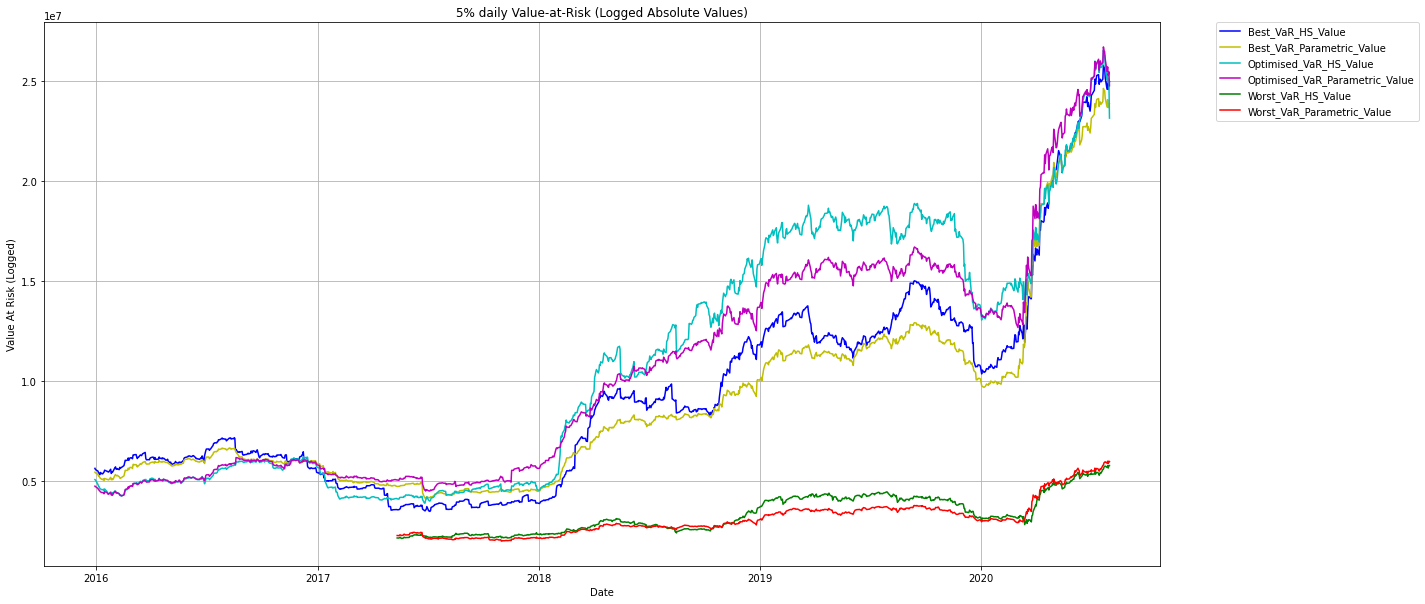

In [117]:
#plot for VaR in absolute value
plt.figure(figsize=(20,10))
plt.plot(best_returns_df['Date'], best_returns_df['VaR_HS_Value'], 'b-', label='Best_VaR_HS_Value')
plt.plot(best_returns_df['Date'], best_returns_df['VaR_Parametric_Value'], 'y-', label='Best_VaR_Parametric_Value')
plt.plot(optimised_returns_df['Date'], optimised_returns_df['VaR_HS_Value'], 'c-', label='Optimised_VaR_HS_Value')
plt.plot(optimised_returns_df['Date'], optimised_returns_df['VaR_Parametric_Value'], 'm-', label='Optimised_VaR_Parametric_Value')
plt.plot(worst_returns_df['Date'], worst_returns_df['VaR_HS_Value'], 'g-', label='Worst_VaR_HS_Value')
plt.plot(worst_returns_df['Date'], worst_returns_df['VaR_Parametric_Value'], 'r-', label='Worst_VaR_Parametric_Value')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value At Risk (Logged)')
plt.title('5% daily Value-at-Risk (Logged Absolute Values)')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
locs, labels = plt.xticks()
plt.show()

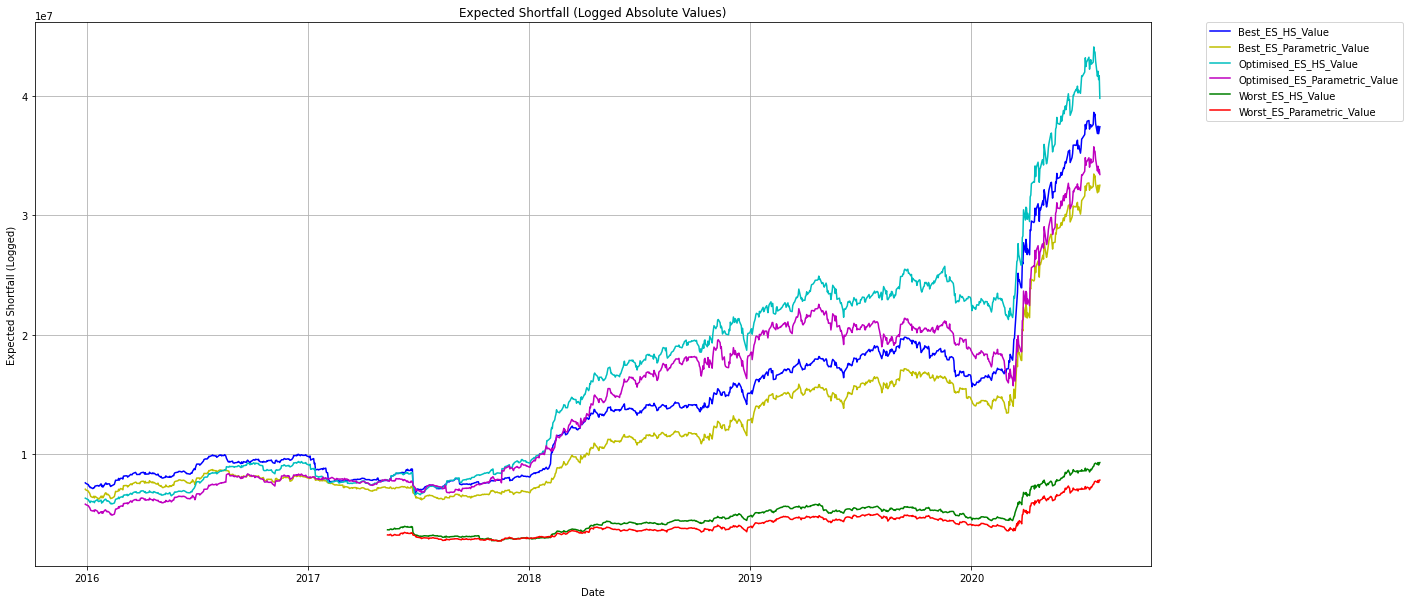

In [118]:
#plot for ES in absolute value
plt.figure(figsize=(20,10))
plt.plot(best_returns_df['Date'], best_returns_df['ES_HS_Value'], 'b-', label='Best_ES_HS_Value')
plt.plot(best_returns_df['Date'], best_returns_df['ES_Parametric_Value'], 'y-', label='Best_ES_Parametric_Value')
plt.plot(optimised_returns_df['Date'], optimised_returns_df['ES_HS_Value'], 'c-', label='Optimised_ES_HS_Value')
plt.plot(optimised_returns_df['Date'], optimised_returns_df['ES_Parametric_Value'], 'm-', label='Optimised_ES_Parametric_Value')
plt.plot(worst_returns_df['Date'], worst_returns_df['ES_HS_Value'], 'g-', label='Worst_ES_HS_Value')
plt.plot(worst_returns_df['Date'], worst_returns_df['ES_Parametric_Value'], 'r-', label='Worst_ES_Parametric_Value')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Expected Shortfall (Logged)')
plt.title('Expected Shortfall (Logged Absolute Values)')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
locs, labels = plt.xticks()
plt.show()

In [119]:
#In absolute values, percentage values will be below
Best_VaR_HS_Value = best_returns_df.iloc[len(best_returns_df.index)-1, best_returns_df.columns.get_loc("VaR_HS_Value")]
Best_VaR_Parametric_Value = best_returns_df.iloc[len(best_returns_df.index)-1, best_returns_df.columns.get_loc("VaR_Parametric_Value")]
Best_ES_HS_Value = best_returns_df.iloc[len(best_returns_df.index)-1, best_returns_df.columns.get_loc("ES_HS_Value")]
Best_ES_Parametric_Value = best_returns_df.iloc[len(best_returns_df.index)-1, best_returns_df.columns.get_loc("ES_Parametric_Value")]
print("Best portfolio: 5% VaR HS value is $" + str(Best_VaR_HS_Value))
print("Best portfolio: 5% VaR parametric value is $" + str(Best_VaR_Parametric_Value))
print("Best portfolio: Expected shortfall HS value is $" + str(Best_ES_HS_Value))
print("Best portfolio: Expected shortfall parametric value is $" + str(Best_ES_Parametric_Value))

Best portfolio: 5% VaR HS value is $24983417.77
Best portfolio: 5% VaR parametric value is $23881659.73
Best portfolio: Expected shortfall HS value is $37422964.94
Best portfolio: Expected shortfall parametric value is $32523475.68


In [120]:
#In absolute values, percentage values will be below
Optimised_VaR_HS_Value = optimised_returns_df.iloc[len(optimised_returns_df.index)-1, optimised_returns_df.columns.get_loc("VaR_HS_Value")]
Optimised_VaR_Parametric_Value = optimised_returns_df.iloc[len(optimised_returns_df.index)-1, optimised_returns_df.columns.get_loc("VaR_Parametric_Value")]
Optimised_ES_HS_Value = optimised_returns_df.iloc[len(optimised_returns_df.index)-1, optimised_returns_df.columns.get_loc("ES_HS_Value")]
Optimised_ES_Parametric_Value = optimised_returns_df.iloc[len(optimised_returns_df.index)-1, optimised_returns_df.columns.get_loc("ES_Parametric_Value")]
print("Optimised portfolio: 5% VaR HS value is $" + str(Optimised_VaR_HS_Value))
print("Optimised portfolio: 5% VaR parametric value is $" + str(Optimised_VaR_Parametric_Value))
print("Optimised portfolio: Expected shortfall HS value is $" + str(Optimised_ES_HS_Value))
print("Optimised portfolio: Expected shortfall parametric value is $" + str(Optimised_ES_Parametric_Value))

Optimised portfolio: 5% VaR HS value is $23156768.22
Optimised portfolio: 5% VaR parametric value is $24776904.31
Optimised portfolio: Expected shortfall HS value is $39800323.28
Optimised portfolio: Expected shortfall parametric value is $33420455.17


In [121]:
#In absolute values, percentage values will be below
Worst_VaR_HS_Value = worst_returns_df.iloc[len(worst_returns_df.index)-1, worst_returns_df.columns.get_loc("VaR_HS_Value")]
Worst_VaR_Parametric_Value = worst_returns_df.iloc[len(worst_returns_df.index)-1, worst_returns_df.columns.get_loc("VaR_Parametric_Value")]
Worst_ES_HS_Value = worst_returns_df.iloc[len(worst_returns_df.index)-1, worst_returns_df.columns.get_loc("ES_HS_Value")]
Worst_ES_Parametric_Value = worst_returns_df.iloc[len(worst_returns_df.index)-1, worst_returns_df.columns.get_loc("ES_Parametric_Value")]
print("Worst portfolio: 5% VaR HS value is $" + str(Worst_VaR_HS_Value))
print("Worst portfolio: 5% VaR parametric value is $" + str(Worst_VaR_Parametric_Value))
print("Worst portfolio: Expected shortfall HS value is $" + str(Worst_ES_HS_Value))
print("Worst portfolio: Expected shortfall parametric value is $" + str(Worst_ES_Parametric_Value))

Worst portfolio: 5% VaR HS value is $5778363.6
Worst portfolio: 5% VaR parametric value is $5972809.63
Worst portfolio: Expected shortfall HS value is $9286950.2
Worst portfolio: Expected shortfall parametric value is $7821629.34


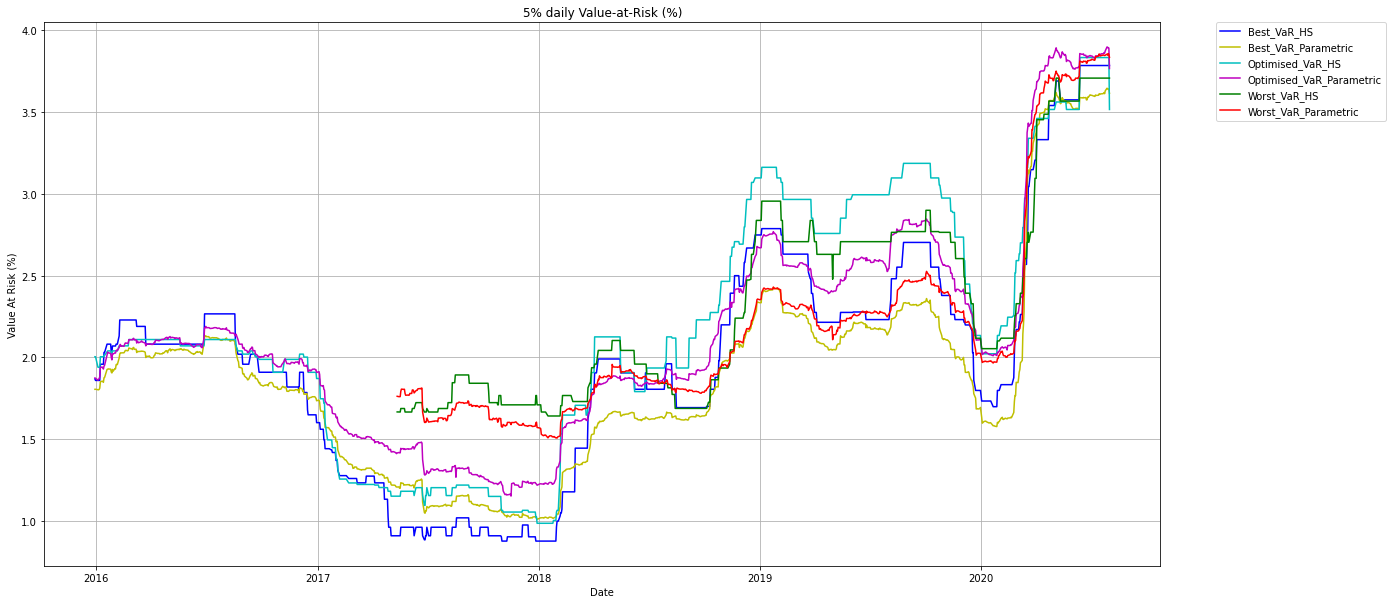

In [122]:
#plot for VaR (%)
plt.figure(figsize=(20,10))
plt.plot(best_returns_df['Date'], abs(best_returns_df['VaR_HS']*100), 'b-', label='Best_VaR_HS')
plt.plot(best_returns_df['Date'], abs(best_returns_df['VaR_Parametric']*100), 'y-', label='Best_VaR_Parametric')
plt.plot(optimised_returns_df['Date'], abs(optimised_returns_df['VaR_HS']*100), 'c-', label='Optimised_VaR_HS')
plt.plot(optimised_returns_df['Date'], abs(optimised_returns_df['VaR_Parametric']*100), 'm-', label='Optimised_VaR_Parametric')
plt.plot(worst_returns_df['Date'], abs(worst_returns_df['VaR_HS']*100), 'g-', label='Worst_VaR_HS')
plt.plot(worst_returns_df['Date'], abs(worst_returns_df['VaR_Parametric']*100), 'r-', label='Worst_VaR_Parametric')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value At Risk (%)')
plt.title('5% daily Value-at-Risk (%)')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
locs, labels = plt.xticks()
plt.show()
#do I need to return the abs() value instead so it's not negative? same for ES below

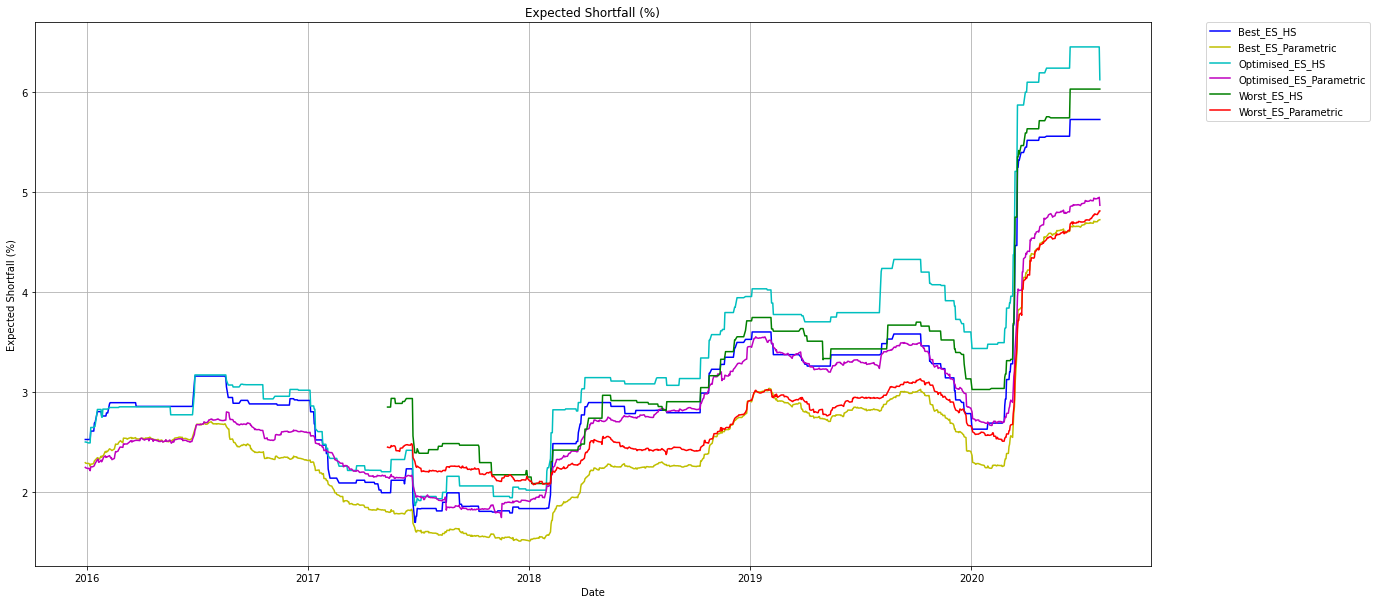

In [123]:
#plot for ES (%)
plt.figure(figsize=(20,10))
plt.plot(best_returns_df['Date'], abs(best_returns_df['ES_HS']*100), 'b-', label='Best_ES_HS')
plt.plot(best_returns_df['Date'], abs(best_returns_df['ES_Parametric']*100), 'y-', label='Best_ES_Parametric')
plt.plot(optimised_returns_df['Date'], abs(optimised_returns_df['ES_HS']*100), 'c-', label='Optimised_ES_HS')
plt.plot(optimised_returns_df['Date'], abs(optimised_returns_df['ES_Parametric']*100), 'm-', label='Optimised_ES_Parametric')
plt.plot(worst_returns_df['Date'], abs(worst_returns_df['ES_HS']*100), 'g-', label='Worst_ES_HS')
plt.plot(worst_returns_df['Date'], abs(worst_returns_df['ES_Parametric']*100), 'r-', label='Worst_ES_Parametric')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Expected Shortfall (%)')
plt.title('Expected Shortfall (%)')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
locs, labels = plt.xticks()
plt.show()

In [124]:
#best portfolio in percentage
Best_VaR_HS = abs(round(best_returns_df.iloc[len(best_returns_df.index)-1, best_returns_df.columns.get_loc("VaR_HS")]*100,2))
Best_VaR_Parametric = abs(round(best_returns_df.iloc[len(best_returns_df.index)-1, best_returns_df.columns.get_loc("VaR_Parametric")]*100,2))
Best_ES_HS = abs(round(best_returns_df.iloc[len(best_returns_df.index)-1, best_returns_df.columns.get_loc("ES_HS")]*100,2))
Best_ES_Parametric = abs(round(best_returns_df.iloc[len(best_returns_df.index)-1, best_returns_df.columns.get_loc("ES_Parametric")]*100,2))
print("Best portfolio: 5% VaR HS is " + str(Best_VaR_HS) + "%")
print("Best portfolio: 5% VaR parametric is " + str(Best_VaR_Parametric) + "%")
print("Best portfolio: Expected shortfall HS is " + str(Best_ES_HS) + "%")
print("Best portfolio: Expected shortfall parametric is " + str(Best_ES_Parametric) + "%")
#same as above, should I return the abs() value?

Best portfolio: 5% VaR HS is 3.79%
Best portfolio: 5% VaR parametric is 3.62%
Best portfolio: Expected shortfall HS is 5.72%
Best portfolio: Expected shortfall parametric is 4.72%


In [125]:
#optimised portfolio in percentage
Optimised_VaR_HS = abs(round(optimised_returns_df.iloc[len(optimised_returns_df.index)-1, optimised_returns_df.columns.get_loc("VaR_HS")]*100,2))
Optimised_VaR_Parametric = abs(round(optimised_returns_df.iloc[len(optimised_returns_df.index)-1, optimised_returns_df.columns.get_loc("VaR_Parametric")]*100,2))
Optimised_ES_HS = abs(round(optimised_returns_df.iloc[len(optimised_returns_df.index)-1, optimised_returns_df.columns.get_loc("ES_HS")]*100,2))
Optimised_ES_Parametric = abs(round(optimised_returns_df.iloc[len(optimised_returns_df.index)-1, optimised_returns_df.columns.get_loc("ES_Parametric")]*100,2))
print("Optimised portfolio: 5% VaR HS is " + str(Optimised_VaR_HS) + "%")
print("Optimised portfolio: 5% VaR parametric is " + str(Optimised_VaR_Parametric) + "%")
print("Optimised portfolio: Expected shortfall HS is " + str(Optimised_ES_HS) + "%")
print("Optimised portfolio: Expected shortfall parametric is " + str(Optimised_ES_Parametric) + "%")

Optimised portfolio: 5% VaR HS is 3.52%
Optimised portfolio: 5% VaR parametric is 3.77%
Optimised portfolio: Expected shortfall HS is 6.12%
Optimised portfolio: Expected shortfall parametric is 4.87%


In [126]:
#worst portfolio in percentage
Worst_VaR_HS = abs(round(worst_returns_df.iloc[len(worst_returns_df.index)-1, worst_returns_df.columns.get_loc("VaR_HS")]*100,2))
Worst_VaR_Parametric = abs(round(worst_returns_df.iloc[len(worst_returns_df.index)-1, worst_returns_df.columns.get_loc("VaR_Parametric")]*100,2))
Worst_ES_HS = abs(round(worst_returns_df.iloc[len(worst_returns_df.index)-1, worst_returns_df.columns.get_loc("ES_HS")]*100,2))
Worst_ES_Parametric = abs(round(worst_returns_df.iloc[len(worst_returns_df.index)-1, worst_returns_df.columns.get_loc("ES_Parametric")]*100,2))
print("Worst portfolio: 5% VaR HS is " + str(Worst_VaR_HS) + "%")
print("Worst portfolio: 5% VaR parametric is " + str(Worst_VaR_Parametric) + "%")
print("Worst portfolio: Expected shortfall HS is " + str(Worst_ES_HS) + "%")
print("Worst portfolio: Expected shortfall parametric is " + str(Worst_ES_Parametric) + "%")

Worst portfolio: 5% VaR HS is 3.71%
Worst portfolio: 5% VaR parametric is 3.84%
Worst portfolio: Expected shortfall HS is 6.03%
Worst portfolio: Expected shortfall parametric is 4.81%


## Question 6

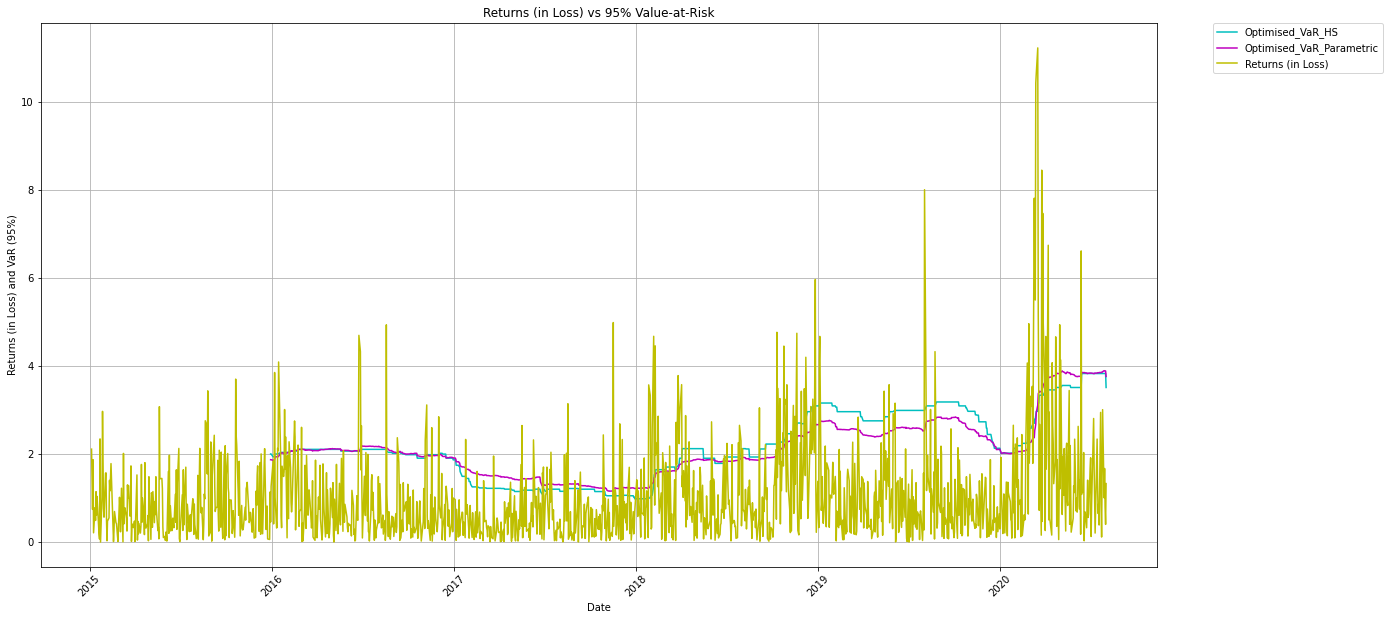

In [127]:
# Plot: Returns vs VaR 95%
plt.figure(figsize=(20,10))
plt.plot(optimised_returns_df['Date'], abs(optimised_returns_df['VaR_HS']*100), 'c-', label='Optimised_VaR_HS')
plt.plot(optimised_returns_df['Date'], abs(optimised_returns_df['VaR_Parametric']*100), 'm-', label='Optimised_VaR_Parametric')
plt.plot(optimised_returns_df['Date'], abs(optimised_returns_df['log_return']*100), 'y-', label='Returns (in Loss)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Returns (in Loss) and VaR (95%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Returns (in Loss) vs 95% Value-at-Risk')
plt.show()

In [128]:
# Zoom in: from '2020-01' to '2020-12'
start_date = '2020-01-01'
end_date = '2020-08-01'
mask2 = (optimised_returns_df['Date'] > start_date) & (optimised_returns_df['Date'] <= end_date)
zoomin_2 = optimised_returns_df[mask2]

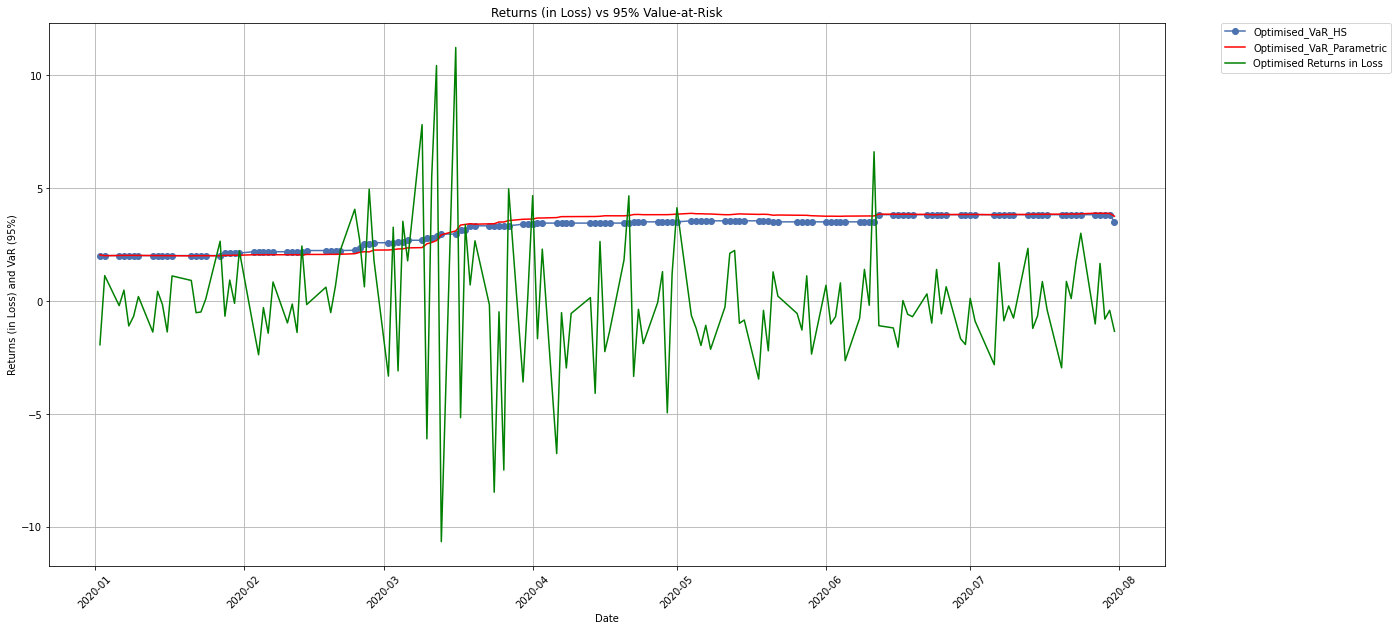

In [129]:
# Plot: Returns vs VaR 95%
plt.figure(figsize=(20,10))
plt.plot(zoomin_2['Date'], abs(zoomin_2['VaR_HS']*100), 'o-', label='Optimised_VaR_HS')
plt.plot(zoomin_2['Date'], abs(zoomin_2['VaR_Parametric']*100), 'r-', label='Optimised_VaR_Parametric')
plt.plot(zoomin_2['Date'], -zoomin_2['log_return']*100, 'g-', label='Optimised Returns in Loss')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Returns (in Loss) and VaR (95%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Returns (in Loss) vs 95% Value-at-Risk')
plt.show()

In [130]:
# A VaR failure or violation happens when the VaR is exceeded by negative return (i.e., loss). 
# Select and Zoom in on dates with exceptions.
exception_parametric_date = optimised_returns_df[optimised_returns_df['VaR_Parametric']>optimised_returns_df['log_return']]['Date']
exception_historical_date = optimised_returns_df[optimised_returns_df['VaR_HS']>optimised_returns_df['log_return']]['Date']
exception_date = pd.concat([exception_parametric_date,exception_historical_date]).drop_duplicates().reset_index(drop=True)

In [131]:
# Statistical tests for VaR backtesting
# Compare the different test results for the normal distribution approach at the 95% and 99% VaR levels.
observed_level = 1 - len(optimised_returns_df[optimised_returns_df['VaR_Parametric']>optimised_returns_df['log_return']])/len(optimised_returns_df)
observations = len(optimised_returns_df)
failures = len(optimised_returns_df[optimised_returns_df['VaR_Parametric']>optimised_returns_df['log_return']])
expected = observations*0.05


print("VaR 95%") 
print("VaR level: %s" %(0.95))
print("Observed level: %s" %(observed_level))
print("Observations: %s" %(observations))
print("Failures: %s" %(failures)) 
print("Expected: %s" %(expected))

VaR 95%
VaR level: 0.95
Observed level: 0.9444839857651246
Observations: 1405
Failures: 78
Expected: 70.25


In [132]:
# Statistical tests for VaR backtesting
# Compare the different test results for the normal distribution approach at the 95% and 99% VaR levels.
observed_level = 1 - len(optimised_returns_df[optimised_returns_df['VaR_HS']>optimised_returns_df['log_return']])/len(optimised_returns_df)
observations = len(optimised_returns_df)
failures = len(optimised_returns_df[optimised_returns_df['VaR_HS']>optimised_returns_df['log_return']])
expected = observations*0.05


print("VaR 95%") 
print("VaR level: %s" %(0.95))
print("Observed level: %s" %(observed_level))
print("Observations: %s" %(observations))
print("Failures: %s" %(failures)) 
print("Expected: %s" %(expected))

VaR 95%
VaR level: 0.95
Observed level: 0.9480427046263346
Observations: 1405
Failures: 73
Expected: 70.25


## Bernoulli test

In [133]:
# Use equations to get p value of 95% Parametric VaR
from scipy.stats import binom

observed_level = 1 - len(optimised_returns_df[optimised_returns_df['VaR_Parametric']>optimised_returns_df['log_return']])/len(optimised_returns_df)
observations = len(optimised_returns_df)
failures = len(optimised_returns_df[optimised_returns_df['VaR_Parametric']>optimised_returns_df['log_return']])
expected = observations*0.05
ratio = failures/expected
backtesting_alpha = 0.05 #backtesting confidence interval
p_value_95 = 1-binom.cdf(failures, observations, 0.05)
print("P-value of VaR 95%: ", p_value_95)
if(p_value_95 < backtesting_alpha):
    print("Reject null hypothesis")
else:
    print(f"Not enough evidence to reject null at {backtesting_alpha} backtesting significance level under binomial distribution")

P-value of VaR 95%:  0.1562397504056583
Not enough evidence to reject null at 0.05 backtesting significance level under binomial distribution


In [134]:
# Use equations to get p value of 95% Historical Simulated VaR
from scipy.stats import binom

observed_level = 1 - len(optimised_returns_df[optimised_returns_df['VaR_HS']>optimised_returns_df['log_return']])/len(optimised_returns_df)
observations = len(optimised_returns_df)
failures = len(optimised_returns_df[optimised_returns_df['VaR_HS']>optimised_returns_df['log_return']])
expected = observations*0.05
ratio = failures/expected
backtesting_alpha = 0.05 #backtesting confidence interval
p_value_95 = 1-binom.cdf(failures, observations, 0.05)
print("P-value of VaR 95%: ", p_value_95)
if(p_value_95 < backtesting_alpha):
    print("Reject null hypothesis")
else:
    print(f"Not enough evidence to reject null at {backtesting_alpha} backtesting significance level under binomial distribution")

P-value of VaR 95%:  0.33972371603517715
Not enough evidence to reject null at 0.05 backtesting significance level under binomial distribution


In [135]:
# Calculate p value for 95% parametric VaR based on normal distribution
from scipy.stats import norm

observed_level = 1 - len([optimised_returns_df['VaR_Parametric']>optimised_returns_df['log_return']])/len(optimised_returns_df)
observations = len(optimised_returns_df)
failures = len(optimised_returns_df[optimised_returns_df['VaR_Parametric']>optimised_returns_df['log_return']])
expected = observations*0.05
ratio = failures/expected

z_score = (failures-expected)/sqrt(expected*0.95)
p_VaR_95 = 1-norm.cdf(z_score, 0, 1)
print("z score: ", z_score)
print("P-value of VaR 95%: ", p_VaR_95)
if(p_VaR_95 < backtesting_alpha):
    print("Reject null hypothesis")
else:
    print(f"Not enough evidence to reject null {backtesting_alpha} backtesting significance level under normal distribution ")

z score:  0.9486734263700709
P-value of VaR 95%:  0.17139336671248073
Not enough evidence to reject null 0.05 backtesting significance level under normal distribution 


In [136]:
# Calculate p value for 95% Historical Simulated VaR based on normal distribution
from scipy.stats import norm

observed_level = 1 - len([optimised_returns_df['VaR_HS']>optimised_returns_df['log_return']])/len(optimised_returns_df)
observations = len(optimised_returns_df)
failures = len(optimised_returns_df[optimised_returns_df['VaR_HS']>optimised_returns_df['log_return']])
expected = observations*0.05
ratio = failures/expected

z_score = (failures-expected)/sqrt(expected*0.95)
p_VaR_95 = 1-norm.cdf(z_score, 0, 1)
print("z score: ", z_score)
print("P-value of VaR 95%: ", p_VaR_95)
if(p_VaR_95 < backtesting_alpha):
    print("Reject null hypothesis")
else:
    print(f"Not enough evidence to reject null {backtesting_alpha} backtesting significance level under normal distribution ")

z score:  0.33662605451841227
P-value of VaR 95%:  0.368199406359483
Not enough evidence to reject null 0.05 backtesting significance level under normal distribution 


# Question 7 Considerations Included in Readjustment for Optimisation

In [138]:
#current weight of sectors
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in w3b.items():
        if sector_mapper[t] == sector:
            total_weight += w
    print(f"{sector}: {total_weight:.3f}")

Software—Infrastructure: 0.264
Communication Services: 0.257
Information Technology Services: 0.033
Consumer Defensive: 0.010
 Information Technology Services: 0.000
Consumer Cyclical: 0.070
Communication Equipment: 0.002
Semiconductors: 0.100
Financial Services: 0.028
 Software—Application: 0.000
Semiconductor Equipment & Materials: 0.001
Consumer Electronics: 0.025
Computer Hardware: 0.209


In [139]:
new_sector_lower = {"Software—Infrastructure":0.25} 
new_sector_upper = {"Consumer Cyclical":0.07, "Semiconductors":0.07,"Computer Hardware":0.15} 

In [140]:
sept_portfolio = get_logre(tickers, start_date='2019-01-01',end_date= '2020-09-01')
sept_portfolio = pd.DataFrame(sept_portfolio)
sept_portfolio.head()

,GOOGL,GOOG,FB,AMZN,EBAY,CSCO,JNPR,QCOM,ACN,AKAM,...,MSFT,ORCL,SNPS,VMW,AAPL,IAC,HPQ,NTAP,STX,WDC
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,0.009259,0.009839,0.034415,0.024440,0.027409,-0.008808,-0.000743,0.008573,-0.002983,-0.034478,...,-0.004440,0.001549,-0.002258,-0.007099,0.001140,-0.015415,0.008274,0.011166,0.012618,0.034298
2019-01-03,-0.028086,-0.028898,-0.029469,-0.025566,-0.018542,-0.037046,-0.033658,-0.030064,-0.034738,-0.022450,...,-0.037482,-0.009778,-0.035606,-0.041156,-0.104924,-0.038112,-0.034520,-0.041907,-0.067751,-0.070656
2019-01-04,0.050021,0.052390,0.046061,0.048851,0.022692,0.044060,0.037740,0.016029,0.038147,0.028700,...,0.045460,0.042197,0.033819,0.061151,0.041803,0.053309,0.038873,0.033362,0.043404,0.041484
2019-01-07,-0.001996,-0.002169,0.000725,0.033776,0.017112,0.006734,0.019076,-0.002831,0.003467,0.030843,...,0.001275,0.015718,0.021927,0.034180,-0.002228,-0.010823,0.011039,-0.005061,0.026392,0.034906


In [141]:
new_in_sample = "2020-02-28" #14 months of data for testing

is_logre_df = sept_portfolio.loc[:new_in_sample]
oos_logre_df = sept_portfolio.loc[new_in_sample:].iloc[1:] # one day after in_sample date

In [142]:
is_logre_df.head()

,GOOGL,GOOG,FB,AMZN,EBAY,CSCO,JNPR,QCOM,ACN,AKAM,...,MSFT,ORCL,SNPS,VMW,AAPL,IAC,HPQ,NTAP,STX,WDC
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,0.009259,0.009839,0.034415,0.024440,0.027409,-0.008808,-0.000743,0.008573,-0.002983,-0.034478,...,-0.004440,0.001549,-0.002258,-0.007099,0.001140,-0.015415,0.008274,0.011166,0.012618,0.034298
2019-01-03,-0.028086,-0.028898,-0.029469,-0.025566,-0.018542,-0.037046,-0.033658,-0.030064,-0.034738,-0.022450,...,-0.037482,-0.009778,-0.035606,-0.041156,-0.104924,-0.038112,-0.034520,-0.041907,-0.067751,-0.070656
2019-01-04,0.050021,0.052390,0.046061,0.048851,0.022692,0.044060,0.037740,0.016029,0.038147,0.028700,...,0.045460,0.042197,0.033819,0.061151,0.041803,0.053309,0.038873,0.033362,0.043404,0.041484
2019-01-07,-0.001996,-0.002169,0.000725,0.033776,0.017112,0.006734,0.019076,-0.002831,0.003467,0.030843,...,0.001275,0.015718,0.021927,0.034180,-0.002228,-0.010823,0.011039,-0.005061,0.026392,0.034906


In [144]:
# calculate expected returns 
er_exp = expected_returns.ema_historical_return(is_logre_df, returns_data=True)
#Calculate the exponentially-weighted mean of (daily) historical returns, giving higher weight to more recent data.
#Calculate sample covariance
s = risk_models.sample_cov(is_logre_df, returns_data=True)

adj = EfficientFrontier(er_exp, s)
adj.add_sector_constraints(sector_mapper, new_sector_lower, new_sector_upper)
googl_index = adj.tickers.index("GOOGL")
adj.add_constraint(lambda w: w[googl_index] >= 0.02)
goog_index = adj.tickers.index("GOOG")
adj.add_constraint(lambda w: w[goog_index] >= 0.02)
fb = adj.tickers.index("FB")
adj.add_constraint(lambda w: w[fb] >= 0.02)
amzn = adj.tickers.index("AMZN")
adj.add_constraint(lambda w: w[amzn] >= 0.02)
msft = adj.tickers.index("MSFT")
adj.add_constraint(lambda w: w[msft] >= 0.02)
appl = adj.tickers.index("AAPL")
adj.add_constraint(lambda w: w[appl] >= 0.02)

adj.add_objective(objective_functions.L2_reg, gamma=2) 
adj.efficient_return(target_return = 0.40)
adjw = adj.clean_weights()
adj_portfolio = (sept_portfolio*adjw).sum(axis = 1)

In [145]:
adjw

OrderedDict([('GOOGL', 0.02),
             ('GOOG', 0.02336),
             ('FB', 0.02525),
             ('AMZN', 0.02),
             ('EBAY', 0.0),
             ('CSCO', 0.0),
             ('JNPR', 0.0),
             ('QCOM', 0.0),
             ('ACN', 0.0),
             ('AKAM', 0.02539),
             ('GPN', 0.17293),
             ('IBM', 0.0),
             ('V', 0.02457),
             ('INTC', 0.0),
             ('KLAC', 0.12594),
             ('NXPI', 0.02066),
             ('SWKS', 0.04934),
             ('XLNX', 0.0),
             ('CHKP', 0.0),
             ('CTXS', 0.0),
             ('MSFT', 0.15917),
             ('ORCL', 0.0),
             ('SNPS', 0.08398),
             ('VMW', 0.0),
             ('AAPL', 0.20344),
             ('IAC', 0.0),
             ('HPQ', 0.0),
             ('NTAP', 0.0),
             ('STX', 0.0),
             ('WDC', 0.04597)])

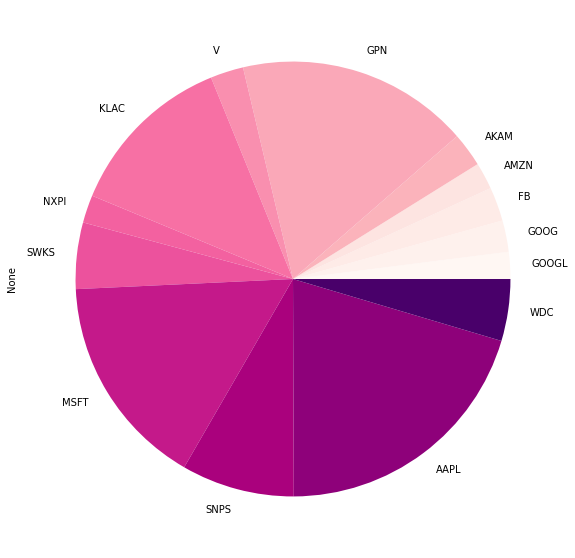

In [146]:
cmap = cm.get_cmap("RdPu")
pd.Series(adjw).plot.pie(figsize=(10,10), cmap=cmap);

In [147]:
#without readjustment:
noadj_portfolio = (sept_portfolio*w3b).sum(axis = 1)

In [148]:
new_all_portfolio_returns = pd.concat([noadj_portfolio,adj_portfolio], axis = 1)
new_all_portfolio_returns.columns = ["noadj_portfolio", "adj_portfolio"]
new_in_sample_results = new_all_portfolio_returns[:new_in_sample]
new_oos_results = new_all_portfolio_returns[new_in_sample:].iloc[1:]

# In Sample Results 
## Volatility, Sharpe Ratio, Returns

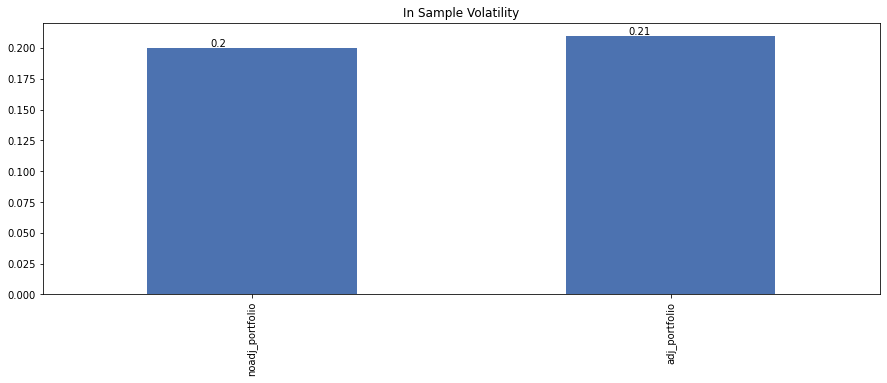

In [149]:
ax = round(new_in_sample_results.std(axis = 0) * 252 ** 0.5, 2).plot(kind="bar", figsize = (15, 5)) 
#avg 252 trading days a year
plt.title("In Sample Volatility")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.001))

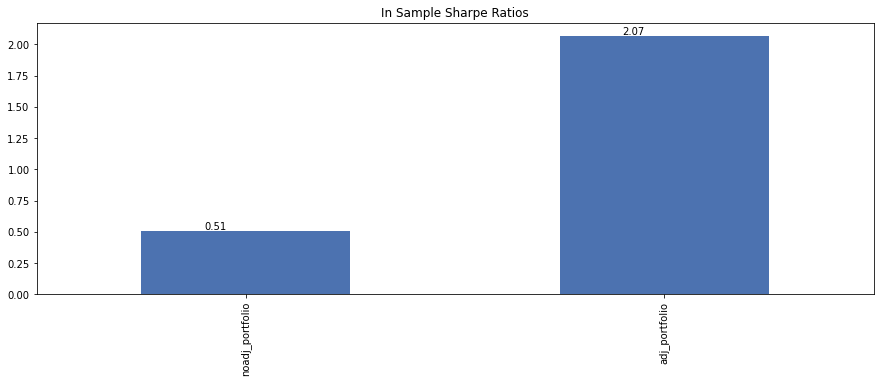

In [150]:
ax = round(new_in_sample_results.mean(axis = 0) / new_in_sample_results.std(axis = 0) * 260 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))
plt.title("In Sample Sharpe Ratios")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

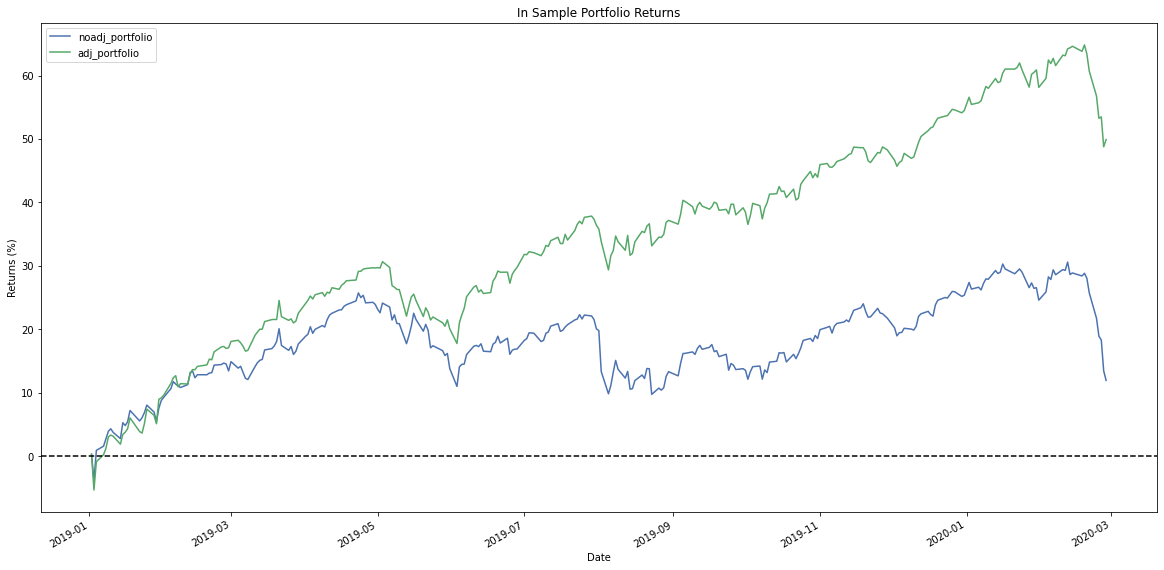

In [151]:
new_in_sample_results[1:].expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (20, 10))
plt.title("In Sample Portfolio Returns")
plt.ylabel("Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

# Out of Sample Results
## Volatility, Sharpe Ratio, Returns

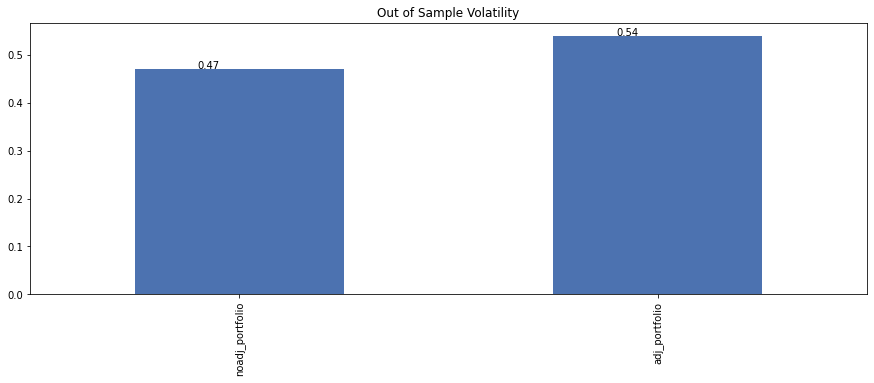

In [152]:
ax = round(new_oos_results.std(axis = 0) * 252 ** 0.5, 2).plot(kind="bar", figsize = (15, 5)) 
#avg 252 trading days a year
plt.title("Out of Sample Volatility")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.001))

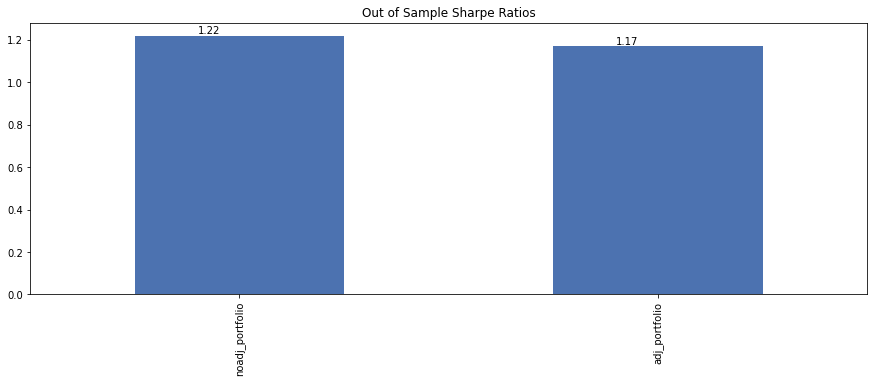

In [153]:
ax = round(new_oos_results.mean(axis = 0) / new_oos_results.std(axis = 0) * 260 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))
plt.title("Out of Sample Sharpe Ratios")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

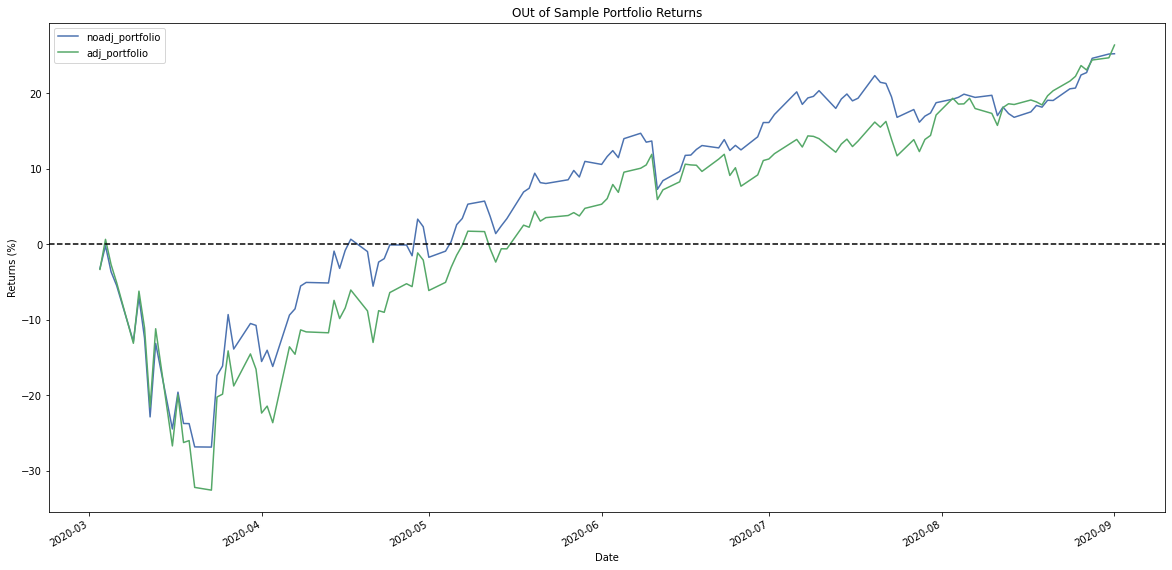

In [154]:
new_oos_results[1:].expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (20, 10))
plt.title("OUt of Sample Portfolio Returns")
plt.ylabel("Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

In [ ]:
#current weight of sectors
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in w3b.items():
        if sector_mapper[t] == sector:
            total_weight += w
    print(f"{sector}: {total_weight:.3f}")

new_sector_lower = {"Software—Infrastructure":0.25} 
new_sector_upper = {"Consumer Cyclical":0.07, "Semiconductors":0.07,"Computer Hardware":0.15} 

sept_portfolio = get_logre(tickers, start_date='2019-01-01',end_date= '2020-09-01')
sept_portfolio = pd.DataFrame(sept_portfolio)
sept_portfolio.head()

new_in_sample = "2020-02-28" #14 months of data for testing

is_logre_df = sept_portfolio.loc[:new_in_sample]
oos_logre_df = sept_portfolio.loc[new_in_sample:].iloc[1:] # one day after in_sample date

is_logre_df.head()

adj = EfficientFrontier(er_exp, s)
adj.add_sector_constraints(sector_mapper, new_sector_lower, new_sector_upper)
googl_index = adj.tickers.index("GOOGL")
adj.add_constraint(lambda w: w[googl_index] >= 0.02)
goog_index = adj.tickers.index("GOOG")
adj.add_constraint(lambda w: w[goog_index] >= 0.02)
fb = adj.tickers.index("FB")
adj.add_constraint(lambda w: w[fb] >= 0.02)
amzn = adj.tickers.index("AMZN")
adj.add_constraint(lambda w: w[amzn] >= 0.02)
msft = adj.tickers.index("MSFT")
adj.add_constraint(lambda w: w[msft] >= 0.02)
appl = adj.tickers.index("AAPL")
adj.add_constraint(lambda w: w[appl] >= 0.02)

adj.add_objective(objective_functions.L2_reg, gamma=2) 
adj.efficient_return(target_return = 0.40)
adjw = adj.clean_weights()
adj_portfolio = (sept_portfolio*adjw).sum(axis = 1)

adjw

cmap = cm.get_cmap("RdPu")
pd.Series(adjw).plot.pie(figsize=(10,10), cmap=cmap);

#without readjustment:
noadj_portfolio = (sept_portfolio*w3b).sum(axis = 1)

new_all_portfolio_returns = pd.concat([noadj_portfolio,adj_portfolio], axis = 1)
new_all_portfolio_returns.columns = ["noadj_portfolio", "adj_portfolio"]
new_in_sample_results = new_all_portfolio_returns[:new_in_sample]
new_oos_results = new_all_portfolio_returns[new_in_sample:].iloc[1:]

# In Sample Results 
## Volatility, Sharpe Ratio, Returns

ax = round(new_in_sample_results.std(axis = 0) * 252 ** 0.5, 2).plot(kind="bar", figsize = (15, 5)) 
#avg 252 trading days a year
plt.title("In Sample Volatility")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.001))

ax = round(new_in_sample_results.mean(axis = 0) / new_in_sample_results.std(axis = 0) * 260 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))
plt.title("In Sample Sharpe Ratios")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

new_in_sample_results[1:].expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (20, 10))
plt.title("In Sample Portfolio Returns")
plt.ylabel("Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

# Out of Sample Results
## Volatility, Sharpe Ratio, Returns

ax = round(new_oos_results.std(axis = 0) * 252 ** 0.5, 2).plot(kind="bar", figsize = (15, 5)) 
#avg 252 trading days a year
plt.title("Out of Sample Volatility")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.001))

ax = round(new_oos_results.mean(axis = 0) / new_oos_results.std(axis = 0) * 260 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))
plt.title("Out of Sample Sharpe Ratios")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

new_oos_results[1:].expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (20, 10))
plt.title("OUt of Sample Portfolio Returns")
plt.ylabel("Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

Software—Infrastructure: 0.264
Communication Services: 0.257
Information Technology Services: 0.033
Consumer Defensive: 0.010
 Information Technology Services: 0.000
Consumer Cyclical: 0.070
Communication Equipment: 0.002
Semiconductors: 0.100
Financial Services: 0.028
 Software—Application: 0.000
Semiconductor Equipment & Materials: 0.001
Consumer Electronics: 0.025
Computer Hardware: 0.209
